# **Дипломная работа по профессии "Аналитик данных"**
# **"Исследование читательских предпочтений пользователей на примере MTC Library"**

## Исходные данные

### Импорт библиотек и алгоритмов

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_score
import pickle
import re
import operator

### Файл с пользователями

In [2]:
df_users = pd.read_csv('users.csv')
df_users.head()

user_id     age  sex
0        1   45_54  NaN
1        2   18_24  0.0
2        3  65_inf  0.0
3        4   18_24  0.0
4        5   35_44  0.0

In [3]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142888 entries, 0 to 142887
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  142888 non-null  int64  
 1   age      142742 non-null  object 
 2   sex      136626 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.3+ MB


### Файл с книгами

In [4]:
df_items = pd.read_csv('items.csv')
df_items.head()

id              title  \
0  128115   Ворон-челобитчик   
1  210979  Скрипка Ротшильда   
2   95632   Испорченные дети   
3  247906   Странный человек   
4  294280  Господа ташкентцы   

                                              genres                 authors  \
0  Зарубежные детские книги,Сказки,Зарубежная кла...  Михаил Салтыков-Щедрин   
1  Классическая проза,Литература 19 века,Русская ...             Антон Чехов   
2  Зарубежная классика,Классическая проза,Литерат...  Михаил Салтыков-Щедрин   
3             Пьесы и драматургия,Литература 19 века        Михаил Лермонтов   
4  Зарубежная классика,Классическая проза,Литерат...  Михаил Салтыков-Щедрин   

   year  
0  1886  
1  1894  
2  1869  
3  1831  
4  1873

In [5]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59599 entries, 0 to 59598
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       59599 non-null  int64 
 1   title    59599 non-null  object
 2   genres   59568 non-null  object
 3   authors  52714 non-null  object
 4   year     46720 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


### Файл с взаимодействием (прочитанные пользователями книги)

In [6]:
df_reading = pd.read_csv('interactions.csv')
df_reading.head()

user_id  item_id  progress  rating  start_date
0   126706    14433        80     NaN  2018-01-01
1   127290   140952        58     NaN  2018-01-01
2    66991   198453        89     NaN  2018-01-01
3    46791    83486        23     5.0  2018-01-01
4    79313   188770        88     5.0  2018-01-01

In [7]:
df_reading.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533078 entries, 0 to 1533077
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   user_id     1533078 non-null  int64  
 1   item_id     1533078 non-null  int64  
 2   progress    1533078 non-null  int64  
 3   rating      285356 non-null   float64
 4   start_date  1533078 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 58.5+ MB


## Файл с книгами

### Работа с пропущенными данными

#### Определение "неизвестных" жанров

In [8]:
# посмотрим на книги, у которых не указаны ни жанр, ни автор

df_items[(df_items['genres'].isna()) & (df_items['authors'].isna())]

id                 title genres authors  year
54961  191297  Созвездие Чёрных Дыр    NaN     NaN  2018

In [9]:
# удалим строку, т.к. эту книгу сложно идентифицировать

df_items = df_items.drop([54961])

In [10]:
# выведем книги, жанр у которых не указан

df_items[df_items['genres'].isna()]

id                                              title genres  \
2925    91029                                           Поп-корн    NaN   
6486   145092    Заложница страха, или история моего одиночества    NaN   
9235   306751                                Контракт с плейбоем    NaN   
9800   271088                                      Скорая помощь    NaN   
9913   300462                             Табу на нежные чувства    NaN   
9919    18664                               Разделяй и властвуй!    NaN   
10486  116867                  Как изменить свою жизнь за 7 дней    NaN   
16837  158565                                 Кликни Деда Мороза    NaN   
20827  104613                                     Золотой павлин    NaN   
22872   52149                          Каталог работ. Карандаш 1    NaN   
25235  161204                        Финансовая оргия XVIII века    NaN   
28165  100866                                         Где выход?    NaN   
28199   14693                          Свобода книги и революция    NaN   
28858   27721                                 О внешней торговле    NaN   
30945  283428  Диагноз – жизнь. Рецепты. Практические советы ...    NaN   
32386   56327                                  Давние знакомства    NaN   
32534  100829  Моя жизнь – дизайн! Первые шаги в проектирован...    NaN   
33030   20634                         За культурный русский язык    NaN   
33034  289311                  Закон о частном радиолюбительстве    NaN   
35345  149385                                            Рыбалка    NaN   
37262  212317            Сказки Мишоги. Книга 1. Игры мироздания    NaN   
40760   41209                                          Бытие мое    NaN   
41575  118768  Закончи мысль автора. Тренинг по спасению от и...    NaN   
52828  135031  Простой способ понять и запомнить сложное: Кон...    NaN   
53847  190097                                            Танечка    NaN   
54543  236657                                            Одиссея    NaN   
54614   57302           Не только о татарах… Скорее, мысли вслух    NaN   
54900  280240                         Почему я выпрыгнул в окно?    NaN   
55293  122166                            Так распорядилась война    NaN   
57669  269363        У небес добавки не просят. Навеяно февралем    NaN   

                               authors  year  
2925                    Андрей Кивинов   NaN  
6486                       Юлия Шилова   NaN  
9235                     Марина Серова  2008  
9800                Татьяна 100 Рожева  2013  
9913                     Марина Серова  2007  
9919                     Марина Серова  2006  
10486                     Флоренс Шинн   NaN  
16837          Анна и Сергей Литвиновы  2011  
20827                 Наталья Солнцева  2010  
22872             Валентина Островская   NaN  
25235                   Федор Булгаков  1893  
28165                      Лев Толстой  1900  
28199             Анатолий Луначарский  1921  
28858                  Иван Вернадский  1856  
30945                     Юлия Болгова   NaN  
32386                    Дмитрий Ильин  2017  
32534                     Анна Миронец   NaN  
33030                 Александр Беляев  1940  
33034                 Александр Беляев  1924  
35345                   Марина Крумина  2017  
37262         Александр (Мишогу) Юшкин  2017  
40760                   Алексий Этимон  2000  
41575           Вольдемар Афористичный   NaN  
52828                 Ильдар Гильфанов  2018  
53847                  Марина Сушилова  2003  
54543                      Иван Егоров  2018  
54614                 Гочмурад Гутлыев  2019  
54900                Антон Романовский  2019  
55293                   Леонид Бударин  2019  
57669  JuNaVi JuNaVi,Наталья Журавлева  2005

In [11]:
# книг с отсутствующими жанрами немного - всего 30,
# удалять эти строки не будем: определим "наиболее частый жанр" для каждого
# из авторов для последующей замены пропущенных значений

condition_genre = df_items[df_items['genres'].isna()]
unknown_genres = pd.DataFrame()

for author in condition_genre['authors']:
    genre = df_items[df_items['authors'] == author].select_dtypes(include='object').mode().head(1)
    unknown_genres = unknown_genres.append(genre[['authors','genres']])

unknown_genres

authors  \
0                   Андрей Кивинов   
0                      Юлия Шилова   
0                    Марина Серова   
0               Татьяна 100 Рожева   
0                    Марина Серова   
0                    Марина Серова   
0                     Флоренс Шинн   
0          Анна и Сергей Литвиновы   
0                 Наталья Солнцева   
0             Валентина Островская   
0                   Федор Булгаков   
0                      Лев Толстой   
0             Анатолий Луначарский   
0                  Иван Вернадский   
0                     Юлия Болгова   
0                    Дмитрий Ильин   
0                     Анна Миронец   
0                 Александр Беляев   
0                 Александр Беляев   
0                   Марина Крумина   
0         Александр (Мишогу) Юшкин   
0                   Алексий Этимон   
0           Вольдемар Афористичный   
0                 Ильдар Гильфанов   
0                  Марина Сушилова   
0                      Иван Егоров   
0                 Гочмурад Гутлыев   
0                Антон Романовский   
0                   Леонид Бударин   
0  JuNaVi JuNaVi,Наталья Журавлева   

                                              genres  
0                              Полицейские детективы  
0                      Остросюжетные любовные романы  
0                              Современные детективы  
0                     Эротические рассказы и истории  
0                              Современные детективы  
0                              Современные детективы  
0  Эзотерика / оккультизм,Религии / верования / к...  
0                              Современные детективы  
0                              Современные детективы  
0                                   Общая психология  
0                                            Критика  
0                Литература 19 века,Русская классика  
0                                       Публицистика  
0                                                NaN  
0                                   Общая психология  
0                                                NaN  
0  Саморазвитие / личностный рост,Практическая пс...  
0  Литература 20 века,Научная фантастика,Классика...  
0  Литература 20 века,Научная фантастика,Классика...  
0  Короткие любовные романы,Современные любовные ...  
0                                                NaN  
0                                          Задачники  
0                                                NaN  
0                                                NaN  
0                                Семейная психология  
0                                                NaN  
0                                                NaN  
0                                                NaN  
0                                                NaN  
0                               Юмористическая проза

In [12]:
# удалим дубликаты и переиндексируем строки

unknown_genres = unknown_genres.drop_duplicates()
unknown_genres.reset_index(inplace=True)

In [13]:
# для 9-ти авторов жанр не найден,
# определим его "вручную" по названию книги на сайте ЛитРес: (https://www.litres.ru/)

variant_one = 'Публицистика,Русская классика'
variant_two = 'Современная русская литература'
variant_three = 'Практическая психология,Саморазвитие / личностный рост'
variant_four = 'Истории из жизни'
variant_five = 'Общая психология,Современная русская литература'
variant_six = 'Книги о войне'

unknown_genres.loc[unknown_genres['authors'] == 'Иван Вернадский', 'genres_new'] = variant_one
unknown_genres.loc[unknown_genres['authors'].isin(['Дмитрий Ильин','Александр (Мишогу) Юшкин','Иван Егоров']), 'genres_new'] = variant_two
unknown_genres.loc[unknown_genres['authors'].isin(['Вольдемар Афористичный','Ильдар Гильфанов']), 'genres_new'] = variant_three
unknown_genres.loc[unknown_genres['authors'] == 'Гочмурад Гутлыев', 'genres_new'] = variant_four
unknown_genres.loc[unknown_genres['authors'] == 'Антон Романовский', 'genres_new'] = variant_five
unknown_genres.loc[unknown_genres['authors'] == 'Леонид Бударин', 'genres_new'] = variant_six

unknown_genres.loc[~unknown_genres['genres'].isna(), 'genres_new'] = unknown_genres['genres']

unknown_genres

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

index                          authors  \
0       0                   Андрей Кивинов   
1       0                      Юлия Шилова   
2       0                    Марина Серова   
3       0               Татьяна 100 Рожева   
4       0                     Флоренс Шинн   
5       0          Анна и Сергей Литвиновы   
6       0                 Наталья Солнцева   
7       0             Валентина Островская   
8       0                   Федор Булгаков   
9       0                      Лев Толстой   
10      0             Анатолий Луначарский   
11      0                  Иван Вернадский   
12      0                     Юлия Болгова   
13      0                    Дмитрий Ильин   
14      0                     Анна Миронец   
15      0                 Александр Беляев   
16      0                   Марина Крумина   
17      0         Александр (Мишогу) Юшкин   
18      0                   Алексий Этимон   
19      0           Вольдемар Афористичный   
20      0                 Ильдар Гильфанов   
21      0                  Марина Сушилова   
22      0                      Иван Егоров   
23      0                 Гочмурад Гутлыев   
24      0                Антон Романовский   
25      0                   Леонид Бударин   
26      0  JuNaVi JuNaVi,Наталья Журавлева   

                                               genres  \
0                               Полицейские детективы   
1                       Остросюжетные любовные романы   
2                               Современные детективы   
3                      Эротические рассказы и истории   
4   Эзотерика / оккультизм,Религии / верования / к...   
5                               Современные детективы   
6                               Современные детективы   
7                                    Общая психология   
8                                             Критика   
9                 Литература 19 века,Русская классика   
10                                       Публицистика   
11                                                NaN   
12                                   Общая психология   
13                                                NaN   
14  Саморазвитие / личностный рост,Практическая пс...   
15  Литература 20 века,Научная фантастика,Классика...   
16  Короткие любовные романы,Современные любовные ...   
17                                                NaN   
18                                          Задачники   
19                                                NaN   
20                                                NaN   
21                                Семейная психология   
22                                                NaN   
23                                                NaN   
24                                                NaN   
25                                                NaN   
26                               Юмористическая проза   

                                           genres_new  
0                               Полицейские детективы  
1                       Остросюжетные любовные романы  
2                               Современные детективы  
3                      Эротические рассказы и истории  
4   Эзотерика / оккультизм,Религии / верования / к...  
5                               Современные детективы  
6                               Современные детективы  
7                                    Общая психология  
8                                             Критика  
9                 Литература 19 века,Русская классика  
10                                       Публицистика  
11                      Публицистика,Русская классика  
12                                   Общая психология  
13                     Современная русская литература  
14  Саморазвитие / личностный рост,Практическая пс...  
15  Литература 20 века,Научная фантастика,Классика...  
16  Короткие любовные романы,Современные любовные ...  
17                     Современная русская литература  
18                                          Задачники 

In [14]:
# удалим лишний столбец

unknown_genres = unknown_genres.drop('genres', axis=1)

In [15]:
# объединим таблицу найденных жанров с основной таблицей книг

df_items_new = df_items.merge(unknown_genres, how='left', on='authors')
df_items_new.head(7)

id                 title  \
0  128115      Ворон-челобитчик   
1  210979     Скрипка Ротшильда   
2   95632      Испорченные дети   
3  247906      Странный человек   
4  294280     Господа ташкентцы   
5  250772              Исповедь   
6  135463  Самоотверженный заяц   

                                              genres                 authors  \
0  Зарубежные детские книги,Сказки,Зарубежная кла...  Михаил Салтыков-Щедрин   
1  Классическая проза,Литература 19 века,Русская ...             Антон Чехов   
2  Зарубежная классика,Классическая проза,Литерат...  Михаил Салтыков-Щедрин   
3             Пьесы и драматургия,Литература 19 века        Михаил Лермонтов   
4  Зарубежная классика,Классическая проза,Литерат...  Михаил Салтыков-Щедрин   
5                  Стихи и поэзия,Литература 19 века        Михаил Лермонтов   
6  Зарубежные детские книги,Сказки,Зарубежная кла...  Михаил Салтыков-Щедрин   

        year  index genres_new  
0       1886    NaN        NaN  
1       1894    NaN        NaN  
2       1869    NaN        NaN  
3       1831    NaN        NaN  
4       1873    NaN        NaN  
5  1829-1830    NaN        NaN  
6       1883    NaN        NaN

In [16]:
# создадим итоговый столбец с жанрами

df_items_new.loc[df_items_new['genres'].isna(), 'genres_all'] = df_items_new['genres_new']
df_items_new.loc[~df_items_new['genres'].isna(), 'genres_all'] = df_items_new['genres']
df_items_new.head()

id              title  \
0  128115   Ворон-челобитчик   
1  210979  Скрипка Ротшильда   
2   95632   Испорченные дети   
3  247906   Странный человек   
4  294280  Господа ташкентцы   

                                              genres                 authors  \
0  Зарубежные детские книги,Сказки,Зарубежная кла...  Михаил Салтыков-Щедрин   
1  Классическая проза,Литература 19 века,Русская ...             Антон Чехов   
2  Зарубежная классика,Классическая проза,Литерат...  Михаил Салтыков-Щедрин   
3             Пьесы и драматургия,Литература 19 века        Михаил Лермонтов   
4  Зарубежная классика,Классическая проза,Литерат...  Михаил Салтыков-Щедрин   

   year  index genres_new                                         genres_all  
0  1886    NaN        NaN  Зарубежные детские книги,Сказки,Зарубежная кла...  
1  1894    NaN        NaN  Классическая проза,Литература 19 века,Русская ...  
2  1869    NaN        NaN  Зарубежная классика,Классическая проза,Литерат...  
3  1831    NaN        NaN             Пьесы и драматургия,Литература 19 века  
4  1873    NaN        NaN  Зарубежная классика,Классическая проза,Литерат...

In [17]:
# оставим нужные столбцы

df_items_new = df_items_new[['id','title','authors','year','genres_all']]
df_items_new.head()

id              title                 authors  year  \
0  128115   Ворон-челобитчик  Михаил Салтыков-Щедрин  1886   
1  210979  Скрипка Ротшильда             Антон Чехов  1894   
2   95632   Испорченные дети  Михаил Салтыков-Щедрин  1869   
3  247906   Странный человек        Михаил Лермонтов  1831   
4  294280  Господа ташкентцы  Михаил Салтыков-Щедрин  1873   

                                          genres_all  
0  Зарубежные детские книги,Сказки,Зарубежная кла...  
1  Классическая проза,Литература 19 века,Русская ...  
2  Зарубежная классика,Классическая проза,Литерат...  
3             Пьесы и драматургия,Литература 19 века  
4  Зарубежная классика,Классическая проза,Литерат...

#### Поиск пропущенных авторов

##### Абонемент "Пресса"

Среди фамилий авторов - около 12% пропущенных данных. Рассмотрим сначала ту часть, которая относится к абонементу МТС Library "Пресса": в него входят газеты и журнальные издания.

In [18]:
# посмотрим на строки с пропущенными авторами

df_items_new[df_items_new['authors'].isna()].tail(12)

id                                          title authors  year  \
59578   80291  Советский Спорт (Федеральный выпуск) 242-2019     NaN  2019   
59579   92573                              Известия 247-2019     NaN  2019   
59580  321542                              Труд 7 93-94-2019     NaN  2019   
59581  273677                                Труд 93-94-2019     NaN  2019   
59585  318609                               За Рулем 01-2020     NaN  2019   
59591  204613                                   Рейс 01-2020     NaN  2019   
59592  234852                                   Лиза 01-2020     NaN  2019   
59593   45640              МК Московский Комсомолец 291-2019     NaN  2019   
59594  321616              МК Московский Комсомолец 292-2019     NaN  2019   
59595  125582                          Известия 248-249-2019     NaN  2019   
59596   33188                           Men's Health 01-2020     NaN  2019   
59597   65317                            Знание-сила 01-2020     NaN  2019   

                                              genres_all  
59578                              Спорт / фитнес,Газеты  
59579                   Политология,Общая история,Газеты  
59580    Книги по экономике,Социальная психология,Газеты  
59581    Книги по экономике,Социальная психология,Газеты  
59585                Автомобили и ПДД,Журнальные издания  
59591                Автомобили и ПДД,Журнальные издания  
59592                                 Журнальные издания  
59593              Политология,Книги по экономике,Газеты  
59594              Политология,Книги по экономике,Газеты  
59595                   Политология,Общая история,Газеты  
59596                                 Журнальные издания  
59597  Журнальные издания,Энциклопедии,Научная фантас...

In [19]:
# внесем значения в новый столбец согласно условиям ниже

condition_paper = (df_items_new['authors'].isna()) & (df_items_new['genres_all'].str.contains('Газеты'))
condition_journal = (df_items_new['authors'].isna()) & (df_items_new['genres_all'].str.contains('Журнальные издания'))

df_items_new.loc[condition_paper, 'authors_new'] = 'пресса'
df_items_new.loc[condition_journal, 'authors_new'] = 'пресса'

In [20]:
# соберем авторов в итоговый столбец

df_items_new.loc[df_items_new['authors'].isna(), 'authors_all'] = df_items_new['authors_new']
df_items_new.loc[~(df_items_new['authors'].isna()), 'authors_all'] = df_items_new['authors']
df_items_new.tail(9)

id                              title               authors  year  \
59589  132718       Моя судьба под твоими ногами        Тальяна Орлова  2019   
59590  272075                    Игрушка Дьявола  Евлампий Бесподобный  2019   
59591  204613                       Рейс 01-2020                   NaN  2019   
59592  234852                       Лиза 01-2020                   NaN  2019   
59593   45640  МК Московский Комсомолец 291-2019                   NaN  2019   
59594  321616  МК Московский Комсомолец 292-2019                   NaN  2019   
59595  125582              Известия 248-249-2019                   NaN  2019   
59596   33188               Men's Health 01-2020                   NaN  2019   
59597   65317                Знание-сила 01-2020                   NaN  2019   

                                              genres_all authors_new  \
59589               Эротическое фэнтези,Любовное фэнтези         NaN   
59590  Эротические романы,Современные любовные романы...         NaN   
59591                Автомобили и ПДД,Журнальные издания      пресса   
59592                                 Журнальные издания      пресса   
59593              Политология,Книги по экономике,Газеты      пресса   
59594              Политология,Книги по экономике,Газеты      пресса   
59595                   Политология,Общая история,Газеты      пресса   
59596                                 Журнальные издания      пресса   
59597  Журнальные издания,Энциклопедии,Научная фантас...      пресса   

                authors_all  
59589        Тальяна Орлова  
59590  Евлампий Бесподобный  
59591                пресса  
59592                пресса  
59593                пресса  
59594                пресса  
59595                пресса  
59596                пресса  
59597                пресса

In [21]:
df_items_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59598 entries, 0 to 59597
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           59598 non-null  int64 
 1   title        59598 non-null  object
 2   authors      52714 non-null  object
 3   year         46719 non-null  object
 4   genres_all   59598 non-null  object
 5   authors_new  4426 non-null   object
 6   authors_all  57140 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.7+ MB


Фамилии авторов до конца не определены - "не хватает" 4% данных.

##### Абонемент "Книги"

Можно ли однозначно сказать кто автор книги, опираясь только на её название и жанр? Ответим на этот вопрос, используя названия-дубли.

(В файле с книгами еще указан год издания, но использовать данный параметр не будем, т.к. во-первых, значения есть не везде - в целом пропущено 22% данных, во-вторых, книги могут быть переизданы (отметок об этом нет)).

In [22]:
# выявим все повторяющиеся названия книг

df_items_new['title_dupl'] = df_items_new.duplicated(subset='title', keep=False)
df_items_new.head(6)

id              title                 authors       year  \
0  128115   Ворон-челобитчик  Михаил Салтыков-Щедрин       1886   
1  210979  Скрипка Ротшильда             Антон Чехов       1894   
2   95632   Испорченные дети  Михаил Салтыков-Щедрин       1869   
3  247906   Странный человек        Михаил Лермонтов       1831   
4  294280  Господа ташкентцы  Михаил Салтыков-Щедрин       1873   
5  250772           Исповедь        Михаил Лермонтов  1829-1830   

                                          genres_all authors_new  \
0  Зарубежные детские книги,Сказки,Зарубежная кла...         NaN   
1  Классическая проза,Литература 19 века,Русская ...         NaN   
2  Зарубежная классика,Классическая проза,Литерат...         NaN   
3             Пьесы и драматургия,Литература 19 века         NaN   
4  Зарубежная классика,Классическая проза,Литерат...         NaN   
5                  Стихи и поэзия,Литература 19 века         NaN   

              authors_all  title_dupl  
0  Михаил Салтыков-Щедрин       False  
1             Антон Чехов       False  
2  Михаил Салтыков-Щедрин       False  
3        Михаил Лермонтов        True  
4  Михаил Салтыков-Щедрин       False  
5        Михаил Лермонтов        True

In [23]:
# посмотрим на названия-дубликаты

df_items_new.loc[df_items_new['title_dupl'] == True].head(10)

id                                        title           authors  \
3   247906                             Странный человек  Михаил Лермонтов   
5   250772                                     Исповедь  Михаил Лермонтов   
14  167994                       Как вам это понравится    Уильям Шекспир   
16   99353                    Записки о Галльской войне   Гай Юлий Цезарь   
18   64274                                        Дуэль       Антон Чехов   
20   49230  Сказка о мертвой царевне и о семи богатырях  Александр Пушкин   
27  279038                                        Левша    Николай Лесков   
29   35488                        У страха глаза велики               NaN   
30  181367                                Электричество   Евгений Замятин   
33  270415                               Черный человек     Сергей Есенин   

                  year                                         genres_all  \
3                 1831             Пьесы и драматургия,Литература 19 века   
5            1829-1830                  Стихи и поэзия,Литература 19 века   
14                1600         Пьесы и драматургия,Зарубежная драматургия   
16  58-50 гг. до н. э.  Зарубежная старинная литература,Античная литер...   
18           1888-1891                Литература 19 века,Русская классика   
20                1834  Детские стихи,Сказки,Список школьной литератур...   
27                1881  Сказки,Список школьной литературы 5-6 класс,Ли...   
29                 NaN                                             Сказки   
30                1918             Зарубежная классика,Классическая проза   
33                 NaN                                     Стихи и поэзия   

   authors_new       authors_all  title_dupl  
3          NaN  Михаил Лермонтов        True  
5          NaN  Михаил Лермонтов        True  
14         NaN    Уильям Шекспир        True  
16         NaN   Гай Юлий Цезарь        True  
18         NaN       Антон Чехов        True  
20         NaN  Александр Пушкин        True  
27         NaN    Николай Лесков        True  
29         NaN               NaN        True  
30         NaN   Евгений Замятин        True  
33         NaN     Сергей Есенин        True

In [24]:
# выберем, например, книгу "Черный человек" и посмотрим на её авторов

df_items_new[df_items_new['title'] == 'Черный человек']

id           title            authors  year  \
33     270415  Черный человек      Сергей Есенин   NaN   
18395  212501  Черный человек  Василий Головачев  1996   
41332   28028  Черный человек      Ричард Морган  2007   
44198   35644  Черный человек  Василий Головачев  2018   

                                              genres_all authors_new  \
33                                        Стихи и поэзия         NaN   
18395          Космическая фантастика,Научная фантастика         NaN   
41332           Зарубежная фантастика,Научная фантастика         NaN   
44198  Социальная фантастика,Космическая фантастика,Н...         NaN   

             authors_all  title_dupl  
33         Сергей Есенин        True  
18395  Василий Головачев        True  
41332      Ричард Морган        True  
44198  Василий Головачев        True

Как видим, вариантов фантастики много и авторы не "уникальны". Отсюда вывод, что по названию книги и её жанру корректно определить автора невозможно.

Поэтому пропущенные значения фамилий авторов ( 4% данных ), а также неизвестные года издания книг, заменим на "не указан".

In [25]:
# заполним пропущенные значения и оставим нужные столбцы (год издания возможно пригодится)

df_items_work = df_items_new.fillna('не указан')
df_items_work = df_items_work[['id','title','authors_all','year','genres_all']]
df_items_work

id                              title             authors_all  \
0      128115                   Ворон-челобитчик  Михаил Салтыков-Щедрин   
1      210979                  Скрипка Ротшильда             Антон Чехов   
2       95632                   Испорченные дети  Михаил Салтыков-Щедрин   
3      247906                   Странный человек        Михаил Лермонтов   
4      294280                  Господа ташкентцы  Михаил Салтыков-Щедрин   
...       ...                                ...                     ...   
59593   45640  МК Московский Комсомолец 291-2019                  пресса   
59594  321616  МК Московский Комсомолец 292-2019                  пресса   
59595  125582              Известия 248-249-2019                  пресса   
59596   33188               Men's Health 01-2020                  пресса   
59597   65317                Знание-сила 01-2020                  пресса   

       year                                         genres_all  
0      1886  Зарубежные детские книги,Сказки,Зарубежная кла...  
1      1894  Классическая проза,Литература 19 века,Русская ...  
2      1869  Зарубежная классика,Классическая проза,Литерат...  
3      1831             Пьесы и драматургия,Литература 19 века  
4      1873  Зарубежная классика,Классическая проза,Литерат...  
...     ...                                                ...  
59593  2019              Политология,Книги по экономике,Газеты  
59594  2019              Политология,Книги по экономике,Газеты  
59595  2019                   Политология,Общая история,Газеты  
59596  2019                                 Журнальные издания  
59597  2019  Журнальные издания,Энциклопедии,Научная фантас...  

[59598 rows x 5 columns]

### Жанры книг: "разделение" названий и их корректировка

In [26]:
# определим текущее количество уникальных жанров

df_items_work['genres_all'].nunique()

10771

In [27]:
# разделим жанры на "составляющие" и визуально оценим полученный список
# (жанры разделены между собой ",")

list_genres = []

for genres in df_items_work['genres_all']:
    genre = genres.split(',')
    for genr in genre:
        if genr not in list_genres:
            list_genres.append(genr)
list_genres

['Зарубежные детские книги',
 'Сказки',
 'Зарубежная классика',
 'Литература 19 века',
 'Русская классика',
 'Классическая проза',
 'Пьесы и драматургия',
 'Стихи и поэзия',
 'Зарубежная старинная литература',
 'Зарубежная драматургия',
 'Античная литература',
 'Литература 20 века',
 'Детские стихи',
 'Список школьной литературы 5-6 класс',
 'Политология',
 'Государственное и муниципальное управление',
 'Критика',
 'Мистика',
 'Детская проза',
 'Книги по экономике',
 'Список школьной литературы 10-11 класс',
 'Список школьной литературы 7-8 класс',
 'Книги про вампиров',
 'Общая история',
 'Литература 18 века',
 'Мифы / легенды / эпос',
 'Древнерусская литература',
 'Публицистика',
 'Исторические приключения',
 'Зарубежные приключения',
 'Зарубежный юмор',
 'Юмористическая проза',
 'Исторические любовные романы',
 'Классические любовные романы',
 'Зарубежная образовательная литература',
 'Биографии и мемуары',
 'Советская литература',
 'Книги о войне',
 'Книги о путешествиях',
 'Зарубе

In [28]:
# выведем полученное количество жанров

len(list_genres)

640

После выявления конкретных названий жанров их уникальное количество сократилось на два порядка - до 640 (было 10771).

Обнаружены жанры, слова в которых изначально разделены не пробелом или знаком "/", а запятой с пробелом. Таких выявлено три:
- "Семья, дети, воспитание",
- "Финансы, инвестиции, экономика",
- "Документы, жалобы, образцы".

Некорректно "разделились" и жанры, где присутствует аббревиатура "ГВЭ". Но учитывая, что без неё не теряется смысл жанра, исправлять такие названия не будем.

In [29]:
# выведем список жанров, начинающихся с пробела (такие после сортировки попадают в начало)

sorted(list_genres)[0:10]

[' ГВЭ)',
 ' воспитание',
 ' дети',
 ' жалобы',
 ' инвестиции',
 ' образцы',
 ' экономика',
 'Cемья',
 'Forex',
 'IT-менеджмент']

Здесь выявляется еще одна "особенность": название жанра "Семья, дети, воспитание" начинается с английской буквы "С" - обязательно это учтем при корректировке.

In [30]:
# убедимся в написании одного из неправильно разделенных жанров

df_items_work[df_items_work['genres_all'].str.contains(', образцы')]

id                                              title  \
39800   74322  Закон РФ «О защите прав потребителей» с коммен...   
42029  175191           СНТ: Собрание VS Суд. Образцы документов   

          authors_all  year                                         genres_all  
39800       не указан  2020  Законы и постановления,Документы, жалобы, обра...  
42029  Роман Колганов  2018  Законы и постановления,Гражданское право,Докум...

In [31]:
# выведем жанр первой строки

df_items_work['genres_all'].iloc[39800]

'Законы и постановления,Документы, жалобы, образцы,Справочная литература,Нормативные правовые акты'

In [32]:
# создадим датафрейм с id-книг и "разделенными" жанрами

df_genres = df_items_work.set_index('id').genres_all.str.get_dummies(',')
df_genres

ГВЭ)   воспитание   дети   жалобы   инвестиции   образцы   экономика  \
id                                                                              
128115      0            0      0        0            0         0           0   
210979      0            0      0        0            0         0           0   
95632       0            0      0        0            0         0           0   
247906      0            0      0        0            0         0           0   
294280      0            0      0        0            0         0           0   
...       ...          ...    ...      ...          ...       ...         ...   
45640       0            0      0        0            0         0           0   
321616      0            0      0        0            0         0           0   
125582      0            0      0        0            0         0           0   
33188       0            0      0        0            0         0           0   
65317       0            0      0        0            0         0           0   

        Cемья  Forex  IT-менеджмент  ...  Юмор и сатира  Юмористическая проза  \
id                                   ...                                        
128115      0      0              0  ...              0                     0   
210979      0      0              0  ...              0                     0   
95632       0      0              0  ...              0                     0   
247906      0      0              0  ...              0                     0   
294280      0      0              0  ...              0                     0   
...       ...    ...            ...  ...            ...                   ...   
45640       0      0              0  ...              0                     0   
321616      0      0              0  ...              0                     0   
125582      0      0              0  ...              0                     0   
33188       0      0              0  ...              0                     0   
65317       0      0              0  ...              0                     0   

        Юмористическая фантастика  Юмористические стихи  \
id                                                        
128115                          0                     0   
210979                          0                     0   
95632                           0                     0   
247906                          0                     0   
294280                          0                     0   
...                           ...                   ...   
45640                           0                     0   
321616                          0                     0   
125582                          0                     0   
33188                           0                     0   
65317                           0                     0   

        Юмористическое фэнтези  Юридические журналы  Юриспруденция  \
id                                                                   
128115                       0                    0              0   
210979                       0                    0              0   
95632                        0                    0              0   
247906                       0                    0              0   
294280                       0                    0              0   
...                        ...                  ...            ...   
45640                        0                    0              0   
321616                       0                    0              0   
125582                       0                    0              0   
33188                        0                    0              0   
65317                        0                    0              0   

        Языковые словари  Языкознание  Японский менеджмент  
id                                                          
128115                 0            0                    0  
210979                 0            0  

In [33]:
# переиндексируем строки

df_genres = df_genres.reset_index()
df_genres

id   ГВЭ)   воспитание   дети   жалобы   инвестиции   образцы  \
0      128115      0            0      0        0            0         0   
1      210979      0            0      0        0            0         0   
2       95632      0            0      0        0            0         0   
3      247906      0            0      0        0            0         0   
4      294280      0            0      0        0            0         0   
...       ...    ...          ...    ...      ...          ...       ...   
59593   45640      0            0      0        0            0         0   
59594  321616      0            0      0        0            0         0   
59595  125582      0            0      0        0            0         0   
59596   33188      0            0      0        0            0         0   
59597   65317      0            0      0        0            0         0   

        экономика  Cемья  Forex  ...  Юмор и сатира  Юмористическая проза  \
0               0      0      0  ...              0                     0   
1               0      0      0  ...              0                     0   
2               0      0      0  ...              0                     0   
3               0      0      0  ...              0                     0   
4               0      0      0  ...              0                     0   
...           ...    ...    ...  ...            ...                   ...   
59593           0      0      0  ...              0                     0   
59594           0      0      0  ...              0                     0   
59595           0      0      0  ...              0                     0   
59596           0      0      0  ...              0                     0   
59597           0      0      0  ...              0                     0   

       Юмористическая фантастика  Юмористические стихи  \
0                              0                     0   
1                              0                     0   
2                              0                     0   
3                              0                     0   
4                              0                     0   
...                          ...                   ...   
59593                          0                     0   
59594                          0                     0   
59595                          0                     0   
59596                          0                     0   
59597                          0                     0   

       Юмористическое фэнтези  Юридические журналы  Юриспруденция  \
0                           0                    0              0   
1                           0                    0              0   
2                           0                    0              0   
3                           0                    0              0   
4                           0                    0              0   
...                       ...                  ...            ...   
59593                       0                    0              0   
59594                       0                    0              0   
59595                       0                    0              0   
59596                       0                    0              0   
59597                       0                    0              0   

       Языковые словари  Языкознание  Японский менеджмент  
0                     0            0                    0  
1                     0            0                    0  
2                     0            0                    0  
3                     0            0                    0  
4                     0            0                    0  
...                 ...          ...                  ...  
59593                 0            0                    0  
59594                 0            0                    0  
59595                 0            0                    0  
59596                 0            0           

In [34]:
# переименуем некорректные жанры: приведем к тому виду, как они "должны" называться

df_genres.rename(columns={'Cемья': 'Семья / дети / воспитание', 'Финансы': 'Финансы / инвестиции / экономика', 'Документы': 'Документы / жалобы / образцы'}, inplace=True)

In [35]:
# удалим лишние столбцы

df_genres = df_genres.drop([' ГВЭ)', ' воспитание', ' дети', ' жалобы', ' инвестиции', ' образцы', ' экономика'], axis=1)
df_genres

id  Семья / дети / воспитание  Forex  IT-менеджмент  MBA  PR  \
0      128115                          0      0              0    0   0   
1      210979                          0      0              0    0   0   
2       95632                          0      0              0    0   0   
3      247906                          0      0              0    0   0   
4      294280                          0      0              0    0   0   
...       ...                        ...    ...            ...  ...  ..   
59593   45640                          0      0              0    0   0   
59594  321616                          0      0              0    0   0   
59595  125582                          0      0              0    0   0   
59596   33188                          0      0              0    0   0   
59597   65317                          0      0              0    0   0   

       Project-менеджмент  Автомобили и ПДД  Автотранспорт  Агрохимия  ...  \
0                       0                 0              0          0  ...   
1                       0                 0              0          0  ...   
2                       0                 0              0          0  ...   
3                       0                 0              0          0  ...   
4                       0                 0              0          0  ...   
...                   ...               ...            ...        ...  ...   
59593                   0                 0              0          0  ...   
59594                   0                 0              0          0  ...   
59595                   0                 0              0          0  ...   
59596                   0                 0              0          0  ...   
59597                   0                 0              0          0  ...   

       Юмор и сатира  Юмористическая проза  Юмористическая фантастика  \
0                  0                     0                          0   
1                  0                     0                          0   
2                  0                     0                          0   
3                  0                     0                          0   
4                  0                     0                          0   
...              ...                   ...                        ...   
59593              0                     0                          0   
59594              0                     0                          0   
59595              0                     0                          0   
59596              0                     0                          0   
59597              0                     0                          0   

       Юмористические стихи  Юмористическое фэнтези  Юридические журналы  \
0                         0                       0                    0   
1                         0                       0                    0   
2                         0                       0                    0   
3                         0                       0                    0   
4                         0                       0                    0   
...                     ...                     ...                  ...   
59593                     0                       0                    0   
59594                     0                       0                    0   
59595                     0                       0                    0   
59596                     0                       0                    0   
59597                     0                       0                    0   

       Юриспруденция  Языковые словари  Языкознание  Японский менеджмент  
0                  0                 0            0                    0  
1                  0                 0            0                    0  
2                  0                 0            0                    0  
3                  0                 0            0                    0  
4       

In [36]:
# посмотрим (справочно) на популярность жанров

df_genres.iloc[:, 1:].sum().sort_values()

Социокультурная деятельность         1
Гражданский кодекс РФ                1
Муниципальное право                  1
Мерчендайзинг                        1
Машиностроение                       1
                                  ... 
Попаданцы                         2453
Боевая фантастика                 2625
Современные любовные романы       3033
Современные детективы             3166
Современная русская литература    3839
Length: 633, dtype: int64

In [37]:
# создадим итоговый файл с книгами - объединим их с "разделенными" жанрами

df_items_all = df_items_work.merge(df_genres, how='left', on='id')
df_items_all.head()

id              title             authors_all  year  \
0  128115   Ворон-челобитчик  Михаил Салтыков-Щедрин  1886   
1  210979  Скрипка Ротшильда             Антон Чехов  1894   
2   95632   Испорченные дети  Михаил Салтыков-Щедрин  1869   
3  247906   Странный человек        Михаил Лермонтов  1831   
4  294280  Господа ташкентцы  Михаил Салтыков-Щедрин  1873   

                                          genres_all  \
0  Зарубежные детские книги,Сказки,Зарубежная кла...   
1  Классическая проза,Литература 19 века,Русская ...   
2  Зарубежная классика,Классическая проза,Литерат...   
3             Пьесы и драматургия,Литература 19 века   
4  Зарубежная классика,Классическая проза,Литерат...   

   Семья / дети / воспитание  Forex  IT-менеджмент  MBA  PR  ...  \
0                          0      0              0    0   0  ...   
1                          0      0              0    0   0  ...   
2                          0      0              0    0   0  ...   
3                          0      0              0    0   0  ...   
4                          0      0              0    0   0  ...   

   Юмор и сатира  Юмористическая проза  Юмористическая фантастика  \
0              0                     0                          0   
1              0                     0                          0   
2              0                     0                          0   
3              0                     0                          0   
4              0                     0                          0   

   Юмористические стихи  Юмористическое фэнтези  Юридические журналы  \
0                     0                       0                    0   
1                     0                       0                    0   
2                     0                       0                    0   
3                     0                       0                    0   
4                     0                       0                    0   

   Юриспруденция  Языковые словари  Языкознание  Японский менеджмент  
0              0                 0            0                    0  
1              0                 0            0                    0  
2              0                 0            0                    0  
3              0                 0            0                    0  
4              0                 0            0                    0  

[5 rows x 638 columns]

In [38]:
# удалим лишний столбец с жанрами

df_items_all = df_items_all.drop('genres_all', axis=1)

### Сводный файл  "взаимодействие" + "книги"

Для корректного объединения таблиц из файла с взаимодействием, как и ранее из файла с книгами, удалим информацию об одной книге, у которой не указаны ни автор, ни жанр (id=191297 "Созвездие Чёрных Дыр").

Отмечу, что в данных о прочитанных пользователями книгах (файл с взаимодействием), за исключением выставленного рейтинга, пропущенных значений нет. Поэтому на данном этапе этот файл возьмем в работу в его исходном виде.

In [39]:
# посмотрим, есть ли записи о прочитанной книге с id=191297 в файле с взаимодействием

df_reading[df_reading['item_id'] == 191297]

user_id  item_id  progress  rating  start_date
18287      77982   191297        17     NaN  2018-01-09
140895     40061   191297        60     5.0  2018-03-09
265807    137004   191297        86     NaN  2018-05-09
283364     14677   191297        13     5.0  2018-05-17
402510     48558   191297        78     NaN  2018-07-14
454386    153686   191297        58     NaN  2018-08-07
540561    114791   191297        67     NaN  2018-09-17
623550    140133   191297        37     NaN  2018-10-27
655240      5545   191297        45     NaN  2018-11-11
783440     55755   191297        32     NaN  2019-01-10
805273    112584   191297        92     NaN  2019-01-20
1224944    83783   191297        88     NaN  2019-08-07
1226685    41510   191297        73     NaN  2019-08-08
1253837    52763   191297         0     NaN  2019-08-21
1343520    53753   191297        66     1.0  2019-10-03
1517496    70565   191297        24     NaN  2019-12-24
1525642    16725   191297        89     5.0  2019-12-28

In [40]:
# удалим эти 17 записей

df_reading.drop(df_reading[df_reading['item_id'] == 191297].index, inplace=True)

In [41]:
# объединим данные двух таблиц: "взаимодействие" + "книги"

df_read_item = df_reading.merge(df_items_all, how='left', left_on='item_id', right_on='id')
df_read_item.head()

user_id  item_id  progress  rating  start_date      id  \
0   126706    14433        80     NaN  2018-01-01   14433   
1   127290   140952        58     NaN  2018-01-01  140952   
2    66991   198453        89     NaN  2018-01-01  198453   
3    46791    83486        23     5.0  2018-01-01   83486   
4    79313   188770        88     5.0  2018-01-01  188770   

                                    title         authors_all       year  \
0                           Девятный Спас  Анатолий Брусникин       2007   
1                Алмаз в воровскую корону       Евгений Сухов       2006   
2                      Твой день 217-2015              пресса       2015   
3  Идеальная талия для вашего типа фигуры     Ванесса Томпсон       2003   
4                           Стихотворения     Игорь Северянин  не указан   

   Семья / дети / воспитание  ...  Юмор и сатира  Юмористическая проза  \
0                          0  ...              0                     0   
1                          0  ...              0                     0   
2                          0  ...              0                     0   
3                          0  ...              0                     0   
4                          0  ...              0                     0   

   Юмористическая фантастика  Юмористические стихи  Юмористическое фэнтези  \
0                          0                     0                       0   
1                          0                     0                       0   
2                          0                     0                       0   
3                          0                     0                       0   
4                          0                     0                       0   

   Юридические журналы  Юриспруденция  Языковые словари  Языкознание  \
0                    0              0                 0            0   
1                    0              0                 0            0   
2                    0              0                 0            0   
3                    0              0                 0            0   
4                    0              0                 0            0   

   Японский менеджмент  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 642 columns]

In [42]:
# удалим столбец-дубль с id-книг

df_read_item.drop('id', axis=1, inplace=True)

In [ ]:
# сохраним всю информацию по книгам в csv-файл

df_read_item.to_csv('read_item.csv', index=False)

## Файл с пользователями

### Подготовка данных для построения модели

В файле с пользователями есть пропущенные данные по возрасту и полу. Что из двух параметров можно предсказать? И какие из имеющихся данных для этого подходят?

В распоряжении есть информация по прочитанным книгам: авторы, названия и жанры. Последние уже "разделены по столбцам" и являются уникальными (их всего 633). Что касается авторов (количество неповторяющихся значений превышает 17 тысяч) и названий книг, - они для целей предсказания не очень-то подходят: во-первых, велик исходный объем вариативных значений, из которого выделить существенные - весьма сложно; а во-вторых, в силу "человеческого фактора", одна и та же книга может быть записана в файл по-разному, выявить такие дубли будет слишком трудозатратно и они искусственно увеличат возможное количество признаков. Это в итоге сильно "утяжелит" модель и приведет к минимальному результату предсказания.

Можно рассмотреть добавление к жанрам двух оставшихся признаков - "прогресс чтения" или "дата начала чтения". Но пользователи, вне зависимости от возраста и пола, могут в совершенно разное время скачивать и начинать читать книги. Эти два признака "не проясняют" ситуацию, поэтому для построения модели предсказания возраста и пола будем использовать только названия жанров.

А получится ли предсказать возраст пользователей? В исследуемых данных - шесть возрастных групп. Интересоваться, например, детективами, любовными романами, фантастикой или научно-популярной литературой, можно в любом возрасте: кто-то будет скачивать книги конкретного автора, потому что он нравился еще в детстве, а кого-то заинтересует только название книги и неважно к какому жанру она относится. Выявить четко выраженные возрастные предпочтения здесь вряд ли получится и точность предсказания модели будет также минимальной.

В итоге по жанрам книг будем строить модель предсказания только пола пользователей.

In [43]:
# сделаем копию сводных данных

df_users_genres = df_read_item.copy()

In [44]:
# и оставим нужные столбцы

df_users_genres.drop(['item_id','progress','rating','start_date','title','authors_all','year'], axis=1, inplace=True)

df_users_genres.head(3)

user_id  Семья / дети / воспитание  Forex  IT-менеджмент  MBA  PR  \
0   126706                          0      0              0    0   0   
1   127290                          0      0              0    0   0   
2    66991                          0      0              0    0   0   

   Project-менеджмент  Автомобили и ПДД  Автотранспорт  Агрохимия  ...  \
0                   0                 0              0          0  ...   
1                   0                 0              0          0  ...   
2                   0                 0              0          0  ...   

   Юмор и сатира  Юмористическая проза  Юмористическая фантастика  \
0              0                     0                          0   
1              0                     0                          0   
2              0                     0                          0   

   Юмористические стихи  Юмористическое фэнтези  Юридические журналы  \
0                     0                       0                    0   
1                     0                       0                    0   
2                     0                       0                    0   

   Юриспруденция  Языковые словари  Языкознание  Японский менеджмент  
0              0                 0            0                    0  
1              0                 0            0                    0  
2              0                 0            0                    0  

[3 rows x 634 columns]

In [45]:
# сгруппируем данные по пользователям и просуммируем "прочитанные" жанры

df_users_genres = df_users_genres.groupby('user_id', as_index=False).sum()
df_users_genres.head(3)

user_id  Семья / дети / воспитание  Forex  IT-менеджмент  MBA  PR  \
0        0                          0      0              0    0   0   
1        1                          0      0              0    0   0   
2        2                          0      0              0    0   0   

   Project-менеджмент  Автомобили и ПДД  Автотранспорт  Агрохимия  ...  \
0                   0                 0              0          0  ...   
1                   0                 0              0          0  ...   
2                   0                 0              0          0  ...   

   Юмор и сатира  Юмористическая проза  Юмористическая фантастика  \
0              0                     0                          0   
1              0                     0                          0   
2              0                     0                          0   

   Юмористические стихи  Юмористическое фэнтези  Юридические журналы  \
0                     0                       0                    0   
1                     0                       0                    0   
2                     0                       0                    0   

   Юриспруденция  Языковые словари  Языкознание  Японский менеджмент  
0              0                 0            1                    0  
1              0                 0            0                    0  
2              0                 0            0                    0  

[3 rows x 634 columns]

In [46]:
# уточним, отличается ли количество уникальных user_id в сводной таблице
# от количества пользователей в таблице df_users

df_users_genres.user_id.nunique() > df_users.user_id.nunique()

True

In [47]:
# в исходную таблицу с пользователями добавим
# номер возрастной группы (в дальнейшем может пригодиться)

df_users.loc[df_users['age'] == '18_24', 'age_group'] = 1
df_users.loc[df_users['age'] == '25_34', 'age_group'] = 2
df_users.loc[df_users['age'] == '35_44', 'age_group'] = 3
df_users.loc[df_users['age'] == '45_54', 'age_group'] = 4
df_users.loc[df_users['age'] == '55_64', 'age_group'] = 5
df_users.loc[df_users['age'] == '65_inf','age_group'] = 6
df_users.loc[df_users['age'].isna(), 'age_group'] = 0

In [48]:
# объединим данные о пользователях со сводной информацией о "прочитанных" жанрах
# (оставим только тех пользователей, которые есть в обеих таблицах)

df_users_age_genres = df_users.merge(df_users_genres, how='inner', on='user_id')
df_users_age_genres.head()

user_id     age  sex  age_group  Семья / дети / воспитание  Forex  \
0        1   45_54  NaN        4.0                          0      0   
1        2   18_24  0.0        1.0                          0      0   
2        3  65_inf  0.0        6.0                          0      0   
3        4   18_24  0.0        1.0                          0      0   
4        5   35_44  0.0        3.0                          0      0   

   IT-менеджмент  MBA  PR  Project-менеджмент  ...  Юмор и сатира  \
0              0    0   0                   0  ...              0   
1              0    0   0                   0  ...              0   
2              0    0   0                   0  ...              0   
3              0    0   0                   0  ...              0   
4              0    0   0                   0  ...              1   

   Юмористическая проза  Юмористическая фантастика  Юмористические стихи  \
0                     0                          0                     0   
1                     0                          0                     0   
2                     0                          0                     0   
3                     1                          0                     0   
4                     1                          0                     1   

   Юмористическое фэнтези  Юридические журналы  Юриспруденция  \
0                       0                    0              0   
1                       0                    0              0   
2                       1                    0              0   
3                       1                    0              0   
4                       0                    0              0   

   Языковые словари  Языкознание  Японский менеджмент  
0                 0            0                    0  
1                 0            0                    0  
2                 0            0                    0  
3                 0            0                    0  
4                 0            0                    0  

[5 rows x 637 columns]

In [ ]:
# сохраним данные в csv-файл

df_users_age_genres.to_csv('users_age_genres.csv', index=False)

Из 135.677 пользователей не указан возраст только у 124-х читателей - это 0,09% от общего числа. Данным количеством можно пренебречь и удалить соответствующие строки из датафрейма.

In [ ]:
# оставим пользователей, у которых возраст определен
# (сначала прочитаем сохраненный файл)

df_users_age_genres = pd.read_csv('users_age_genres.csv')

df_users_sex_genres = df_users_age_genres.loc[df_users_age_genres['age_group'] > 0]
df_users_sex_genres

user_id     age  sex  age_group  Семья / дети / воспитание  Forex  \
0             1   45_54  NaN        4.0                          0      0   
1             2   18_24  0.0        1.0                          0      0   
2             3  65_inf  0.0        6.0                          0      0   
3             4   18_24  0.0        1.0                          0      0   
4             5   35_44  0.0        3.0                          0      0   
...         ...     ...  ...        ...                        ...    ...   
135672   159606   25_34  0.0        2.0                          0      0   
135673   159607   25_34  NaN        2.0                          0      0   
135674   159609   18_24  0.0        1.0                          0      0   
135675   159610   35_44  0.0        3.0                          0      0   
135676   159611   35_44  0.0        3.0                          0      0   

        IT-менеджмент  MBA  PR  Project-менеджмент  ...  Юмор и сатира  \
0                   0    0   0                   0  ...              0   
1                   0    0   0                   0  ...              0   
2                   0    0   0                   0  ...              0   
3                   0    0   0                   0  ...              0   
4                   0    0   0                   0  ...              1   
...               ...  ...  ..                 ...  ...            ...   
135672              0    0   0                   0  ...              0   
135673              0    0   0                   0  ...              0   
135674              0    0   0                   0  ...              0   
135675              0    0   0                   0  ...              0   
135676              0    0   0                   0  ...              0   

        Юмористическая проза  Юмористическая фантастика  Юмористические стихи  \
0                          0                          0                     0   
1                          0                          0                     0   
2                          0                          0                     0   
3                          1                          0                     0   
4                          1                          0                     1   
...                      ...                        ...                   ...   
135672                     0                          0                     0   
135673                     0                          0                     0   
135674                     0                          0                     0   
135675                     0                          0                     0   
135676                     0                          0                     0   

        Юмористическое фэнтези  Юридические журналы  Юриспруденция  \
0                            0                    0              0   
1                            0                    0              0   
2                            1                    0              0   
3                            1                    0              0   
4                            0                    0              0   
...                        ...                  ...            ...   
135672                       0                    0              0   
135673                       0                    0              0   
135674                       0                    0              0   
135675                       0                    1              0   
135676                       0                    0              0   

        Языковые словари  Языкознание  Японский менеджмент  
0                      0            0                    0  
1                      0            0                    0  
2                      0            0                    0  
3                      0            0                    0  
4                      0            0                    0  
...           

In [ ]:
# сохраним данные в csv-файл

df_users_sex_genres.to_csv('users_sex_genres.csv', index=False)

In [ ]:
# оставим строки с "известным полом"

df_users_sex_genres_filter = df_users_sex_genres.loc[~df_users_sex_genres['sex'].isna()]
df_users_sex_genres_filter

user_id     age  sex  age_group  Семья / дети / воспитание  Forex  \
1             2   18_24  0.0        1.0                          0      0   
2             3  65_inf  0.0        6.0                          0      0   
3             4   18_24  0.0        1.0                          0      0   
4             5   35_44  0.0        3.0                          0      0   
5             6   55_64  0.0        5.0                          0      0   
...         ...     ...  ...        ...                        ...    ...   
135671   159605   18_24  0.0        1.0                          0      0   
135672   159606   25_34  0.0        2.0                          0      0   
135674   159609   18_24  0.0        1.0                          0      0   
135675   159610   35_44  0.0        3.0                          0      0   
135676   159611   35_44  0.0        3.0                          0      0   

        IT-менеджмент  MBA  PR  Project-менеджмент  ...  Юмор и сатира  \
1                   0    0   0                   0  ...              0   
2                   0    0   0                   0  ...              0   
3                   0    0   0                   0  ...              0   
4                   0    0   0                   0  ...              1   
5                   0    0   0                   0  ...              0   
...               ...  ...  ..                 ...  ...            ...   
135671              0    0   0                   0  ...              0   
135672              0    0   0                   0  ...              0   
135674              0    0   0                   0  ...              0   
135675              0    0   0                   0  ...              0   
135676              0    0   0                   0  ...              0   

        Юмористическая проза  Юмористическая фантастика  Юмористические стихи  \
1                          0                          0                     0   
2                          0                          0                     0   
3                          1                          0                     0   
4                          1                          0                     1   
5                          0                          0                     0   
...                      ...                        ...                   ...   
135671                     0                          0                     0   
135672                     0                          0                     0   
135674                     0                          0                     0   
135675                     0                          0                     0   
135676                     0                          0                     0   

        Юмористическое фэнтези  Юридические журналы  Юриспруденция  \
1                            0                    0              0   
2                            1                    0              0   
3                            1                    0              0   
4                            0                    0              0   
5                            0                    0              0   
...                        ...                  ...            ...   
135671                       0                    0              0   
135672                       0                    0              0   
135674                       0                    0              0   
135675                       0                    1              0   
135676                       0                    0              0   

        Языковые словари  Языкознание  Японский менеджмент  
1                      0            0                    0  
2                      0            0                    0  
3                      0            0                    0  
4                      0            0                    0  
5                      0            0                    0  
...           

In [ ]:
# и нужными столбцами

df_users_sex_genres_filter.drop(['user_id','age','age_group'], axis=1, inplace=True)
df_users_sex_genres_filter.head()

sex  Семья / дети / воспитание  Forex  IT-менеджмент  MBA  PR  \
1  0.0                          0      0              0    0   0   
2  0.0                          0      0              0    0   0   
3  0.0                          0      0              0    0   0   
4  0.0                          0      0              0    0   0   
5  0.0                          0      0              0    0   0   

   Project-менеджмент  Автомобили и ПДД  Автотранспорт  Агрохимия  ...  \
1                   0                 0              0          0  ...   
2                   0                 0              0          0  ...   
3                   0                 0              0          0  ...   
4                   0                 0              0          0  ...   
5                   0                 0              0          0  ...   

   Юмор и сатира  Юмористическая проза  Юмористическая фантастика  \
1              0                     0                          0   
2              0                     0                          0   
3              0                     1                          0   
4              1                     1                          0   
5              0                     0                          0   

   Юмористические стихи  Юмористическое фэнтези  Юридические журналы  \
1                     0                       0                    0   
2                     0                       1                    0   
3                     0                       1                    0   
4                     1                       0                    0   
5                     0                       0                    0   

   Юриспруденция  Языковые словари  Языкознание  Японский менеджмент  
1              0                 0            0                    0  
2              0                 0            0                    0  
3              0                 0            0                    0  
4              0                 0            0                    0  
5              0                 0            0                    0  

[5 rows x 634 columns]

In [ ]:
# сохраним данные в csv-файл

df_users_sex_genres_filter.to_csv('users_sex_genres_filter.csv', index=False)

### Построение модели предсказания пола пользователей

Предсказание пола - это задача классификации: отнесение пользователей к одной из двух исходных групп.

In [ ]:
# напишем функцию, которая создает новый датафрейм, исходя из выбранного
# количества (number) прочитанных книг

def model_dataframe (df, number):
    model_number = pd.DataFrame()

    for column in df.columns:
        if df[column].sum() > number:
            model_number[column] = df[column]
    return model_number

In [ ]:
# уменьшим количество исходных признаков - жанров - например, до 116

model_sex_116 = model_dataframe(df_users_sex_genres_filter, 5000)
model_sex_116

sex  Биографии и мемуары  Боевая фантастика  Боевики  Боевое фэнтези  \
1       0.0                    0                  0        0               0   
2       0.0                    0                  0        0               0   
3       0.0                    0                  0        0               1   
4       0.0                    0                  0        0               0   
5       0.0                    0                  0        2               0   
...     ...                  ...                ...      ...             ...   
135671  0.0                    0                  0        1               0   
135672  0.0                    0                  0        0               0   
135674  0.0                    2                  0        1               0   
135675  0.0                    0                  0        0               0   
135676  0.0                    0                  0        0               1   

        Военное дело / спецслужбы  Воспитание детей  Газеты  \
1                               0                 0       0   
2                               0                 0       0   
3                               0                 0       1   
4                               0                 0       1   
5                               1                 0       0   
...                           ...               ...     ...   
135671                          0                 0       1   
135672                          0                 0       0   
135674                          0                 0       0   
135675                          0                 0       0   
135676                          0                 0       0   

        Героическая фантастика  Героическое фэнтези  ...  Ужасы  \
1                            0                    0  ...      0   
2                            0                    0  ...      1   
3                            0                    0  ...      0   
4                            0                    0  ...      0   
5                            0                    0  ...      0   
...                        ...                  ...  ...    ...   
135671                       0                    1  ...      0   
135672                       0                    0  ...      0   
135674                       0                    0  ...      0   
135675                       0                    0  ...      0   
135676                       0                    1  ...      0   

        Фэнтези про драконов  Эзотерика / оккультизм  Эротическая литература  \
1                          0                       0                       0   
2                          0                       0                       0   
3                          0                       0                       0   
4                          0                       0                       0   
5                          0                       0                       0   
...                      ...                     ...                     ...   
135671                     0                       0                       0   
135672                     0                       0                       0   
135674                     0                       0                       0   
135675                     0                       0                       0   
135676                     0                       0                       0   

        Эротические романы  Эротическое фэнтези  Юмор и сатира  \
1                        0                    0              0   
2                        1                    0              0   
3                        0                    0              0   
4                        0                    0              1   
5                        0                    0              0   
...                    ...                  ...            ...   
135671                   0                    0              0

In [ ]:
# разделим данные на признаки (жанры) и метки (пол пользователей)

X_116 = model_sex_116.drop('sex', axis=1)
y_116 = model_sex_116['sex']

In [ ]:
# разделим данные на две выборки - для обучения и проверки

X_train, X_test, y_train, y_test = train_test_split(X_116, y_116, test_size=0.2)

In [ ]:
# приведем данные к одному масштабу (для устойчивого машинного обучения):
# в обучающей выборке + проверим на тесте

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# переведем полученные данные в датафрейм

X_train = pd.DataFrame(X_train, columns=X_116.columns)
X_test = pd.DataFrame(X_test, columns=X_116.columns)

Выборки для модели готовы, осталось определиться с методом решения. Попробуем алгоритм К-ближайших соседей, он кажется наиболее подходящим вариантом.

Небольшой комментарий. Среди читателей с "известным полом" (из 129.585 уникальных пользователей) только 33% составляют читатели-мужчины. Данный факт, очевидно, скажется и на результатах предсказания.

In [ ]:
# алгоритм К-ближайших соседей (по умолчанию количество соседей равно 5)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
# сделаем предсказание и оценим качество модели (метрика точности)

y_pred = knn.predict(X_test)
precision_score(y_test, y_pred)

0.36009099772505687

In [ ]:
# увеличим количество соседей до 200

knn = KNeighborsClassifier(n_neighbors = 200)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=200)

In [ ]:
# предсказание и оценка

y_pred = knn.predict(X_test)
precision_score(y_test, y_pred)

0.7716535433070866

In [ ]:
# увеличим количество соседей до 500

knn_1 = KNeighborsClassifier(n_neighbors = 500)
knn_1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=500)

In [ ]:
# предсказание и оценка

y_pred_1 = knn_1.predict(X_test)
precision_score(y_test, y_pred_1)

0.8235294117647058

Алгоритм К-ближайших соседей - не единственный алгоритм для решения задачи классификации. Попробуем другие решения и сравним результаты.

In [ ]:
# алгоритм SVC

svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [ ]:
# предсказание и оценка

y_pred_2 = svc.predict(X_test)
precision_score(y_test, y_pred_2)

0.7266666666666667

In [ ]:
# алгоритм "случайный лес"

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# предсказание и оценка

y_pred_3 = rf.predict(X_test)
precision_score(y_test, y_pred_3)

0.5201612903225806

In [ ]:
# увеличим в алгоритме "случайный лес" количество деревьев до 500

rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [ ]:
# предсказание и оценка

y_pred_4 = rf.predict(X_test)
precision_score(y_test, y_pred_4)

0.5182186234817814

In [ ]:
# алгоритм "градиентный бустинг"

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
# предсказание и оценка

y_pred_5 = gb.predict(X_test)
precision_score(y_test, y_pred_5)

0.6666666666666666

In [ ]:
# алгоритм "экстра деревья"

et = ExtraTreesClassifier()
et.fit(X_train, y_train)

ExtraTreesClassifier()

In [ ]:
# предсказание и оценка

y_pred_6 = et.predict(X_test)
precision_score(y_test, y_pred_6)

0.48467650397275824

Алгоритмы из группы "ансамбли" ("случайный лес", градиентный бустинг, "экстра деревья") показали низкую точность предсказания. Попробуем другие алгоритмы.

In [ ]:
# алгоритм "дерево решений" (из группы "деревья")

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
# предсказание и оценка

y_pred_7 = dt.predict(X_test)
precision_score(y_test, y_pred_7)

0.3515803193222548

In [ ]:
# наивный классификатор Байеса

nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [ ]:
# предсказание и оценка

y_pred_8 = nb.predict(X_test)
precision_score(y_test, y_pred_8)

0.35139340136365715

Из всех рассмотренных алгоритмов у "К-ближайших соседей" - наилучший результат по точности предсказания (82,3%). Попробуем увеличить точность, изменив число соседей.

In [ ]:
# увеличим количество соседей до 1000

knn_2 = KNeighborsClassifier(n_neighbors = 1000)
knn_2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1000)

In [ ]:
# предсказание и оценка

y_pred_9 = knn_2.predict(X_test)
precision_score(y_test, y_pred_9)

0.835820895522388

Ситуация кардинально не изменилась (+ 1,3% к точности предсказания). Применим данный алгоритм к новой модели с меньшим количеством признаков - жанров.

In [ ]:
# уменьшим количество жанров до 63-х (оставим книги, прочитанные больше 14.500 раз)

model_sex_63 = model_dataframe(df_users_sex_genres_filter, 14500)
model_sex_63

sex  Биографии и мемуары  Боевая фантастика  Боевики  Боевое фэнтези  \
1       0.0                    0                  0        0               0   
2       0.0                    0                  0        0               0   
3       0.0                    0                  0        0               1   
4       0.0                    0                  0        0               0   
5       0.0                    0                  0        2               0   
...     ...                  ...                ...      ...             ...   
135671  0.0                    0                  0        1               0   
135672  0.0                    0                  0        0               0   
135674  0.0                    2                  0        1               0   
135675  0.0                    0                  0        0               0   
135676  0.0                    0                  0        0               1   

        Газеты  Героическая фантастика  Героическое фэнтези  \
1            0                       0                    0   
2            0                       0                    0   
3            1                       0                    0   
4            1                       0                    0   
5            0                       0                    0   
...        ...                     ...                  ...   
135671       1                       0                    1   
135672       0                       0                    0   
135674       0                       0                    0   
135675       0                       0                    0   
135676       0                       0                    1   

        Городское фэнтези  Детективное фэнтези  ...  \
1                       0                    0  ...   
2                       0                    0  ...   
3                       0                    0  ...   
4                       0                    0  ...   
5                       0                    1  ...   
...                   ...                  ...  ...   
135671                  0                    1  ...   
135672                  0                    0  ...   
135674                  0                    0  ...   
135675                  0                    0  ...   
135676                  0                    0  ...   

        Современная русская литература  Современные детективы  \
1                                    1                      1   
2                                    0                      1   
3                                    0                      0   
4                                    0                      0   
5                                    0                      1   
...                                ...                    ...   
135671                               1                      0   
135672                               1                      1   
135674                               0                      0   
135675                               0                     49   
135676                               0                      0   

        Современные любовные романы  Социальная психология  \
1                                 0                      0   
2                                 1                      0   
3                                 1                      0   
4                                 0                      0   
5                                 0                      0   
...                             ...                    ...   
135671                            0                      0   
135672                            0                      0   
135674                            0                      0   
135675                            0                      1   
135676                            0                      0   

        Социальная фантастика  Стихи и поэзия  Триллеры  \
1                           0               

In [ ]:
# разделим данные на признаки (жанры) и метки (пол пользователей)

X_63 = model_sex_63.drop('sex', axis=1)
y_63 = model_sex_63['sex']

In [ ]:
# разделим на выборки для обучения и проверки

X_train, X_test, y_train, y_test = train_test_split(X_63, y_63, test_size=0.2)

In [ ]:
# приведем данные к одному масштабу (для устойчивого машинного обучения)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# переведем массивы в датафрейм

X_train = pd.DataFrame(X_train, columns=X_63.columns)
X_test = pd.DataFrame(X_test, columns=X_63.columns)

In [ ]:
# алгоритм К-ближайших соседей (в этой модели число соседей равно 200)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=200)

In [ ]:
# предсказание и оценка

y_pred_10 = knn.predict(X_test)
precision_score(y_test, y_pred_10)

0.7073170731707317

In [ ]:
# увеличим число соседей до 500

knn_1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=500)

In [ ]:
# предсказание и оценка

y_pred_11 = knn_1.predict(X_test)
precision_score(y_test, y_pred_11)

0.751937984496124

При уменьшении числа признаков качество модели заметно снижается. Посмотрим на точность предсказания алгоритма при исходном количестве жанров (их всего 633).

In [ ]:
# признаки и метки

X_633 = df_users_sex_genres_filter.drop('sex', axis=1)
y_633 = df_users_sex_genres_filter['sex']

In [ ]:
# выборки для обучения и проверки

X_train, X_test, y_train, y_test = train_test_split(X_633, y_633, test_size=0.2)

In [ ]:
# единый масштаб данных

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# перевод в датафрейм

X_train = pd.DataFrame(X_train, columns=X_633.columns)
X_test = pd.DataFrame(X_test, columns=X_633.columns)

In [ ]:
# алгоритм К-ближайших соседей (число соседей равно 200)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=200)

In [ ]:
# предсказание и оценка

y_pr = knn.predict(X_test)
precision_score(y_test, y_pr)

0.7941176470588235

In [ ]:
# увеличим количество соседей до 500

knn_1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=500)

In [ ]:
# предсказание и оценка

y_pr_1 = knn_1.predict(X_test)
precision_score(y_test, y_pr_1)

0.8235294117647058

Сведем в таблицу полученные значения precision_score для алгоритма К-ближайших соседей.

In [ ]:
svod_precision_sex = pd.DataFrame([
    [633, 79.4, 82.3, 'нет'],
    [116, 77.1, 82.3, 83.5],
    [63, 70.7, 75.2, 'нет']],
    columns=['quantity', 'n=200', 'n=500', 'n=1000']
)
svod_precision_sex

quantity  n=200  n=500 n=1000
0       633   79.4   82.3    нет
1       116   77.1   82.3   83.5
2        63   70.7   75.2    нет

Хорошая точность предсказания - у моделей с количеством признаков 116 и 633 (фактор "числа соседей" сейчас не рассматриваем). В этом интервале жанров построим новые модели и определим их качество.

In [ ]:
# изменим количество жанров, например, на 234 (оставим книги, которые прочитали более 1000 раз)

model_sex_234 = model_dataframe(df_users_sex_genres_filter, 1000)
model_sex_234

sex  Автомобили и ПДД  Альтернативная медицина  Английский язык  \
1       0.0                 0                        0                0   
2       0.0                 0                        0                0   
3       0.0                 0                        0                0   
4       0.0                 0                        0                0   
5       0.0                 0                        0                0   
...     ...               ...                      ...              ...   
135671  0.0                 1                        0                0   
135672  0.0                 0                        0                0   
135674  0.0                 0                        0                0   
135675  0.0                 0                        0                0   
135676  0.0                 0                        0                0   

        Анекдоты  Античная литература  Архитектура  Астрология  \
1              0                    0            0           0   
2              0                    0            0           0   
3              0                    0            0           0   
4              1                    0            0           0   
5              0                    0            0           0   
...          ...                  ...          ...         ...   
135671         0                    0            0           0   
135672         0                    0            0           0   
135674         0                    0            0           0   
135675         0                    0            0           0   
135676         0                    0            0           0   

        Афоризмы и цитаты  Бизнес-стратегии  ...  Эротические романы  \
1                       0                 0  ...                   0   
2                       0                 0  ...                   1   
3                       0                 0  ...                   0   
4                       0                 0  ...                   0   
5                       0                 0  ...                   0   
...                   ...               ...  ...                 ...   
135671                  0                 0  ...                   0   
135672                  0                 0  ...                   0   
135674                  0                 0  ...                   0   
135675                  0                 0  ...                   0   
135676                  0                 0  ...                   0   

        Эротическое фэнтези  Эффективность бизнеса  Юмор и сатира  \
1                         0                      0              0   
2                         0                      0              0   
3                         0                      0              0   
4                         0                      0              1   
5                         0                      0              0   
...                     ...                    ...            ...   
135671                    0                      0              0   
135672                    0                      0              0   
135674                    0                      0              0   
135675                    0                      0              0   
135676                    0                      0              0   

        Юмористическая проза  Юмористическая фантастика  Юмористические стихи  \
1                          0                          0                     0   
2                          0                          0                     0   
3                          1                          0                     0   
4                          1                          0                     1   
5                          0                          0                     0   
...                      ...                        ...                   ...   
135671                     0                         

In [ ]:
# признаки и метки

X_234 = model_sex_234.drop('sex', axis=1)
y_234 = model_sex_234['sex']

In [ ]:
# выборки для обучения и проверки

X_train, X_test, y_train, y_test = train_test_split(X_234, y_234, test_size=0.2)

In [ ]:
# единый масштаб данных

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# перевод в датафрейм

X_train = pd.DataFrame(X_train, columns=X_234.columns)
X_test = pd.DataFrame(X_test, columns=X_234.columns)

In [ ]:
# алгоритм К-ближайших соседей (количество соседей равно 200)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=200)

In [ ]:
# предсказание и оценка

y_pred_234 = knn.predict(X_test)
precision_score(y_test, y_pred_234)

0.8666666666666667

In [ ]:
# увеличим число соседей до 500

knn_1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=500)

In [ ]:
# предсказание и оценка

y_pred_234_1 = knn_1.predict(X_test)
precision_score(y_test, y_pred_234_1)

0.9069767441860465

In [ ]:
# увеличим число соседей до 700

knn_3 = KNeighborsClassifier(n_neighbors=700)
knn_3.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=700)

In [ ]:
# предсказание и оценка

y_pred_234_3 = knn_3.predict(X_test)
precision_score(y_test, y_pred_234_3)

0.9210526315789473

In [ ]:
# увеличим количество признаков-жанров, например, до 335-ти

model_sex_335 = model_dataframe(df_users_sex_genres_filter, 300)
model_sex_335

sex  Семья / дети / воспитание  PR  Автомобили и ПДД  Автотранспорт  \
1       0.0                          0   0                 0              0   
2       0.0                          0   0                 0              0   
3       0.0                          0   0                 0              0   
4       0.0                          0   0                 0              0   
5       0.0                          0   0                 0              0   
...     ...                        ...  ..               ...            ...   
135671  0.0                          0   0                 1              0   
135672  0.0                          0   0                 0              0   
135674  0.0                          0   0                 0              0   
135675  0.0                          0   0                 0              0   
135676  0.0                          0   0                 0              0   

        Акушерство и гинекология  Альтернативная медицина  \
1                              0                        0   
2                              0                        0   
3                              0                        0   
4                              0                        0   
5                              0                        0   
...                          ...                      ...   
135671                         0                        0   
135672                         0                        0   
135674                         0                        0   
135675                         0                        0   
135676                         0                        0   

        Анатомия и физиология  Английский язык  Анекдоты  ...  \
1                           0                0         0  ...   
2                           0                0         0  ...   
3                           0                0         0  ...   
4                           0                0         1  ...   
5                           0                0         0  ...   
...                       ...              ...       ...  ...   
135671                      0                0         0  ...   
135672                      0                0         0  ...   
135674                      0                0         0  ...   
135675                      0                0         0  ...   
135676                      0                0         0  ...   

        Эффективная презентация  Эффективность бизнеса  Юмор и сатира  \
1                             0                      0              0   
2                             0                      0              0   
3                             0                      0              0   
4                             0                      0              1   
5                             0                      0              0   
...                         ...                    ...            ...   
135671                        0                      0              0   
135672                        0                      0              0   
135674                        0                      0              0   
135675                        0                      0              0   
135676                        0                      0              0   

        Юмористическая проза  Юмористическая фантастика  Юмористические стихи  \
1                          0                          0                     0   
2                          0                          0                     0   
3                          1                          0                     0   
4                          1                          0                     1   
5                          0                          0                     0   
...                      ...                        ...                   ...   
135671                     0                          0                     0   
135672              

In [ ]:
# признаки и метки

X_335 = model_sex_335.drop('sex', axis=1)
y_335 = model_sex_335['sex']

In [ ]:
# выборки для обучения и проверки

X_train, X_test, y_train, y_test = train_test_split(X_335, y_335, test_size=0.2)

In [ ]:
# приведение данных к одному масштабу

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# перевод массивов в датафрейм

X_train = pd.DataFrame(X_train, columns=X_335.columns)
X_test = pd.DataFrame(X_test, columns=X_335.columns)

In [ ]:
# алгоритм К-ближайших соседей (количество соседей - 200)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=200)

In [ ]:
# предсказание и оценка

y_pred_335 = knn.predict(X_test)
precision_score(y_test, y_pred_335)

0.7922077922077922

In [ ]:
# увеличим количество соседей до 500

knn_1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=500)

In [ ]:
# предсказание и оценка

y_pred_335_1 = knn_1.predict(X_test)
precision_score(y_test, y_pred_335_1)

0.8070175438596491

Учитывая полученные значения precision_score, построим модель с числом признаков в интервале от 234 до 335: пусть их количество будет равно 263.

In [ ]:
# уменьшим количество жанров до 263-х

model_sex_263 = model_dataframe(df_users_sex_genres_filter, 700)
model_sex_263

sex  Автомобили и ПДД  Акушерство и гинекология  \
1       0.0                 0                         0   
2       0.0                 0                         0   
3       0.0                 0                         0   
4       0.0                 0                         0   
5       0.0                 0                         0   
...     ...               ...                       ...   
135671  0.0                 1                         0   
135672  0.0                 0                         0   
135674  0.0                 0                         0   
135675  0.0                 0                         0   
135676  0.0                 0                         0   

        Альтернативная медицина  Английский язык  Анекдоты  \
1                             0                0         0   
2                             0                0         0   
3                             0                0         0   
4                             0                0         1   
5                             0                0         0   
...                         ...              ...       ...   
135671                        0                0         0   
135672                        0                0         0   
135674                        0                0         0   
135675                        0                0         0   
135676                        0                0         0   

        Античная литература  Архитектура  Астрология  Афоризмы и цитаты  ...  \
1                         0            0           0                  0  ...   
2                         0            0           0                  0  ...   
3                         0            0           0                  0  ...   
4                         0            0           0                  0  ...   
5                         0            0           0                  0  ...   
...                     ...          ...         ...                ...  ...   
135671                    0            0           0                  0  ...   
135672                    0            0           0                  0  ...   
135674                    0            0           0                  0  ...   
135675                    0            0           0                  0  ...   
135676                    0            0           0                  0  ...   

        Этнография  Эффективность бизнеса  Юмор и сатира  \
1                0                      0              0   
2                0                      0              0   
3                0                      0              0   
4                0                      0              1   
5                0                      0              0   
...            ...                    ...            ...   
135671           0                      0              0   
135672           0                      0              0   
135674           0                      0              0   
135675           0                      0              0   
135676           0                      0              0   

        Юмористическая проза  Юмористическая фантастика  Юмористические стихи  \
1                          0                          0                     0   
2                          0                          0                     0   
3                          1                          0                     0   
4                          1                          0                     1   
5                          0                          0                     0   
...                      ...                        ...                   ...   
135671                     0                          0                     0   
135672                     0                          0                     0   
135674                     0                          0                     0   
135675                     0                          0       

In [ ]:
# признаки и метки

X_263 = model_sex_263.drop('sex', axis=1)
y_263 = model_sex_263['sex']

In [ ]:
# выборки для обучения и проверки

X_train, X_test, y_train, y_test = train_test_split(X_263, y_263, test_size=0.2)

In [ ]:
# приведение данных к одному масштабу

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# перевод массивов в датафрейм

X_train = pd.DataFrame(X_train, columns=X_263.columns)
X_test = pd.DataFrame(X_test, columns=X_263.columns)

In [ ]:
# алгоритм К-ближайших соседей (число соседей - 200)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=200)

In [ ]:
# предсказание и оценка

y_pred_263 = knn.predict(X_test)
precision_score(y_test, y_pred_263)

0.8554216867469879

In [ ]:
# увеличим количество соседей до 500

knn_1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=500)

In [ ]:
# предсказание и оценка

y_pred_263_1 = knn_1.predict(X_test)
precision_score(y_test, y_pred_263_1)

0.9107142857142857

In [ ]:
# увеличим количество соседей до 700

knn_3.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=700)

In [ ]:
# предсказание и оценка

y_pred_263_3 = knn_3.predict(X_test)
precision_score(y_test, y_pred_263_3)

0.9111111111111111

Снова сведем в таблицу полученные значения precision_score для алгоритма К-ближайших соседей.

In [ ]:
svod_precision_knn = pd.DataFrame([
    [633, 79.4, 82.3, 'нет', 'нет'],
    [335, 79.2, 80.7, 'нет', 'нет'],
    [263, 85.5, 91.0, 91.1, 'нет'],
    [234, 86.7, 90.7, 92.1, 'нет'],
    [116, 77.1, 82.3, 'нет', 83.5],
    [63, 70.7, 75.2, 'нет','нет']],
    columns=['quantity', 'n=200', 'n=500', 'n=700', 'n=1000']
)
svod_precision_knn

quantity  n=200  n=500 n=700 n=1000
0       633   79.4   82.3   нет    нет
1       335   79.2   80.7   нет    нет
2       263   85.5   91.0  91.1    нет
3       234   86.7   90.7  92.1    нет
4       116   77.1   82.3   нет   83.5
5        63   70.7   75.2   нет    нет

Наилучший результат - у модели с количеством жанров-признаков 234 и числом соседей, равным 700.

Данная модель, к большому сожалению, не была сохранена, а "переобучать" её - плохая идея. Поэтому построим новую, одновременно применив другой подход к формированию исходного датафрейма:

* сначала оставим жанры, которые суммарно "прочитали" больше 1000 раз (на этой идее была построена лучшая модель),
* затем выберем строки с известным полом пользователей.

In [ ]:
# прочитаем файл с необходимыми данными (возраст пользователей здесь определен)

df_users_sex_genres = pd.read_csv('users_sex_genres.csv')
df_users_sex_genres.head(3)

user_id     age  sex  age_group  Семья / дети / воспитание  Forex  \
0        1   45_54  NaN        4.0                          0      0   
1        2   18_24  0.0        1.0                          0      0   
2        3  65_inf  0.0        6.0                          0      0   

   IT-менеджмент  MBA  PR  Project-менеджмент  ...  Юмор и сатира  \
0              0    0   0                   0  ...              0   
1              0    0   0                   0  ...              0   
2              0    0   0                   0  ...              0   

   Юмористическая проза  Юмористическая фантастика  Юмористические стихи  \
0                     0                          0                     0   
1                     0                          0                     0   
2                     0                          0                     0   

   Юмористическое фэнтези  Юридические журналы  Юриспруденция  \
0                       0                    0              0   
1                       0                    0              0   
2                       1                    0              0   

   Языковые словари  Языкознание  Японский менеджмент  
0                 0            0                    0  
1                 0            0                    0  
2                 0            0                    0  

[3 rows x 637 columns]

In [ ]:
# удалим лишние столбцы

df_users_sex_predict = df_users_sex_genres.drop(['age','age_group'], axis=1)
df_users_sex_predict.head(3)

user_id  sex  Семья / дети / воспитание  Forex  IT-менеджмент  MBA  PR  \
0        1  NaN                          0      0              0    0   0   
1        2  0.0                          0      0              0    0   0   
2        3  0.0                          0      0              0    0   0   

   Project-менеджмент  Автомобили и ПДД  Автотранспорт  ...  Юмор и сатира  \
0                   0                 0              0  ...              0   
1                   0                 0              0  ...              0   
2                   0                 0              0  ...              0   

   Юмористическая проза  Юмористическая фантастика  Юмористические стихи  \
0                     0                          0                     0   
1                     0                          0                     0   
2                     0                          0                     0   

   Юмористическое фэнтези  Юридические журналы  Юриспруденция  \
0                       0                    0              0   
1                       0                    0              0   
2                       1                    0              0   

   Языковые словари  Языкознание  Японский менеджмент  
0                 0            0                    0  
1                 0            0                    0  
2                 0            0                    0  

[3 rows x 635 columns]

In [ ]:
# оставим в датафрейме жанры, суммарно "прочитанные" больше 1000 раз
# (используем ранее написанную функцию)

df_users_sex_pred = model_dataframe(df_users_sex_predict, 1000)
df_users_sex_pred.head(3)

user_id  sex  Автомобили и ПДД  Альтернативная медицина  Английский язык  \
0        1  NaN                 0                        0                0   
1        2  0.0                 0                        0                0   
2        3  0.0                 0                        0                0   

   Анекдоты  Античная литература  Архитектура  Астрология  Афоризмы и цитаты  \
0         0                    0            0           0                  0   
1         0                    0            0           0                  0   
2         0                    0            0           0                  0   

   ...  Эротические романы  Эротическое фэнтези  Эффективность бизнеса  \
0  ...                   0                    1                      0   
1  ...                   0                    0                      0   
2  ...                   1                    0                      0   

   Юмор и сатира  Юмористическая проза  Юмористическая фантастика  \
0              0                     0                          0   
1              0                     0                          0   
2              0                     0                          0   

   Юмористические стихи  Юмористическое фэнтези  Юриспруденция  Языкознание  
0                     0                       0              0            0  
1                     0                       0              0            0  
2                     0                       1              0            0  

[3 rows x 238 columns]

In [ ]:
# выберем строки с "известным" полом пользователей

df_users_sex_model = df_users_sex_pred.loc[~df_users_sex_pred['sex'].isna()]
df_users_sex_model.head(3)

user_id  sex  Автомобили и ПДД  Альтернативная медицина  Английский язык  \
1        2  0.0                 0                        0                0   
2        3  0.0                 0                        0                0   
3        4  0.0                 0                        0                0   

   Анекдоты  Античная литература  Архитектура  Астрология  Афоризмы и цитаты  \
1         0                    0            0           0                  0   
2         0                    0            0           0                  0   
3         0                    0            0           0                  0   

   ...  Эротические романы  Эротическое фэнтези  Эффективность бизнеса  \
1  ...                   0                    0                      0   
2  ...                   1                    0                      0   
3  ...                   0                    0                      0   

   Юмор и сатира  Юмористическая проза  Юмористическая фантастика  \
1              0                     0                          0   
2              0                     0                          0   
3              0                     1                          0   

   Юмористические стихи  Юмористическое фэнтези  Юриспруденция  Языкознание  
1                     0                       0              0            0  
2                     0                       1              0            0  
3                     0                       1              0            0  

[3 rows x 238 columns]

Важный комментарий: при изменении подхода к формированию данных для построения модели меняется и количество признаков-жанров.

Так в первом случае (в лучшей модели) сначала были выбраны строки с известным полом пользователей, а потом получены жанры с требуемым числом "прочтений". В итоге - 234 признака для построения модели.

Во втором, когда порядок действий поменялся (сначала жанры, потом пол), - количество жанров стало равно 236.

In [ ]:
# разделим данные на признаки и метки

X_model = df_users_sex_model.drop(['user_id','sex'], axis=1)
y_model = df_users_sex_model['sex']

In [ ]:
# сформируем обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2)

In [ ]:
# приведем данные к одному масштабу

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# переведем массивы в датафрейм

X_train = pd.DataFrame(X_train, columns=X_model.columns)
X_test = pd.DataFrame(X_test, columns=X_model.columns)

In [ ]:
# алгоритм К-ближайших соседей (количество соседей, как у лучшей модели, возьмем равным 700)

knn_700 = KNeighborsClassifier(n_neighbors=700)
knn_700.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=700)

In [ ]:
# предсказание и оценка

y_pred = knn_700.predict(X_test)
precision_score(y_test, y_pred)

0.8

In [ ]:
# сохраним построенную модель (в файл как поток байтов)

filemodel = 'final_knn_700.sav'
pickle.dump(knn_700, open(filemodel, 'wb'))

Точность предсказания последней модели - 80%. По сути, это средняя точность всех построенных ранее моделей, у которых менялись только два параметра: количество жанров и число "соседей".

Остановимся на данном варианте (не будем уже "доводить до совершенства") и сделаем предсказание пола у 5.968 пользователей.

### Предсказание

In [ ]:
# создадим датафрейм с пользователями, пол которых не указан

df_sex_predict = df_users_sex_pred.loc[df_users_sex_pred['sex'].isna()]
df_sex_predict

user_id  sex  Автомобили и ПДД  Альтернативная медицина  \
0             1  NaN                 0                        0   
19           23  NaN                 0                        0   
26           31  NaN                 0                        0   
28           33  NaN                 0                        0   
86          105  NaN                 0                        0   
...         ...  ...               ...                      ...   
135494   159544  NaN                 0                        0   
135516   159570  NaN                 0                        0   
135535   159590  NaN                 0                        0   
135540   159595  NaN                 0                        0   
135549   159607  NaN                 0                        0   

        Английский язык  Анекдоты  Античная литература  Архитектура  \
0                     0         0                    0            0   
19                    0         0                    0            0   
26                    0         0                    0            0   
28                    0         0                    0            0   
86                    0         0                    0            0   
...                 ...       ...                  ...          ...   
135494                0         0                    0            0   
135516                0         0                    0            0   
135535                0         0                    0            0   
135540                0         0                    0            0   
135549                0         0                    0            0   

        Астрология  Афоризмы и цитаты  ...  Эротические романы  \
0                0                  0  ...                   0   
19               0                  0  ...                   0   
26               0                  0  ...                   1   
28               0                  0  ...                   1   
86               0                  0  ...                   0   
...            ...                ...  ...                 ...   
135494           0                  0  ...                   0   
135516           0                  0  ...                   0   
135535           0                  0  ...                   0   
135540           0                  0  ...                   1   
135549           0                  0  ...                   1   

        Эротическое фэнтези  Эффективность бизнеса  Юмор и сатира  \
0                         1                      0              0   
19                        0                      0              0   
26                        0                      0              0   
28                        0                      0              0   
86                        0                      0              0   
...                     ...                    ...            ...   
135494                    0                      0              0   
135516                    0                      0              0   
135535                    0                      0              0   
135540                    0                      0              0   
135549                    0                      0              0   

        Юмористическая проза  Юмористическая фантастика  Юмористические стихи  \
0                          0                          0                     0   
19                         0                          1                     0   
26                         0                          0                     0   
28                         0                          0                     0   
86                         0                          0                     0   
...                      ...                        ...                   ...   
135494                     0                          0                     0   
135516                     0                          0                     0   

In [ ]:
# запишем предсказание в отдельный столбец

for index in range(len(df_sex_predict)):
    X_list = list(df_sex_predict.iloc[index])[3:]
    predict_sex = knn_700.predict([X_list])
    df_sex_predict['sex_new'] = int(predict_sex)

df_sex_predict.head(3)

user_id  sex  Автомобили и ПДД  Альтернативная медицина  Английский язык  \
0         1  NaN                 0                        0                0   
19       23  NaN                 0                        0                0   
26       31  NaN                 0                        0                0   

    Анекдоты  Античная литература  Архитектура  Астрология  Афоризмы и цитаты  \
0          0                    0            0           0                  0   
19         0                    0            0           0                  0   
26         0                    0            0           0                  0   

    ...  Эротическое фэнтези  Эффективность бизнеса  Юмор и сатира  \
0   ...                    1                      0              0   
19  ...                    0                      0              0   
26  ...                    0                      0              0   

    Юмористическая проза  Юмористическая фантастика  Юмористические стихи  \
0                      0                          0                     0   
19                     0                          1                     0   
26                     0                          0                     0   

    Юмористическое фэнтези  Юриспруденция  Языкознание  sex_new  
0                        0              0            0        0  
19                       1              0            0        0  
26                       0              0            0        0  

[3 rows x 239 columns]

In [ ]:
# выделим предсказанный пол пользователей

df_sex_new = df_sex_predict[['user_id', 'sex_new']]
df_sex_new

user_id  sex_new
0             1        0
19           23        0
26           31        0
28           33        0
86          105        0
...         ...      ...
135494   159544        0
135516   159570        0
135535   159590        0
135540   159595        0
135549   159607        0

[5968 rows x 2 columns]

In [ ]:
# соберем информацию о пользователях: к имеющимся данным

df_users_new = df_users_sex_genres[['user_id','age','age_group','sex']]
df_users_new.head(3)

user_id     age  age_group  sex
0        1   45_54        4.0  NaN
1        2   18_24        1.0  0.0
2        3  65_inf        6.0  0.0

In [ ]:
# добавим предсказанный пол

df_users_all = df_users_new.merge(df_sex_new, how='left', on='user_id')
df_users_all.head(3)

user_id     age  age_group  sex  sex_new
0        1   45_54        4.0  NaN      0.0
1        2   18_24        1.0  0.0      NaN
2        3  65_inf        6.0  0.0      NaN

In [ ]:
# создадим итоговый столбец с полом пользователей

df_users_all.loc[df_users_all['sex_new'].isna(), 'sex_all'] = df_users_all['sex']
df_users_all.loc[~df_users_all['sex_new'].isna(), 'sex_all'] = df_users_all['sex_new']

df_users_all.head(3)

user_id     age  age_group  sex  sex_new  sex_all
0        1   45_54        4.0  NaN      0.0      0.0
1        2   18_24        1.0  0.0      NaN      0.0
2        3  65_inf        6.0  0.0      NaN      0.0

In [ ]:
# удалим лишние столбцы

df_users_all.drop(['sex','sex_new'], axis=1, inplace=True)

In [ ]:
# посмотрим на данные

df_users_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135553 entries, 0 to 135552
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    135553 non-null  int64  
 1   age        135553 non-null  object 
 2   age_group  135553 non-null  float64
 3   sex_all    135553 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 10.2+ MB


In [ ]:
# сохраним датафрейм с пользователями

df_users_all.to_csv('users_all.csv', index=False)

### Сводный файл "взаимодействие и книги" + "пользователи"

In [ ]:
# прочитаем сводный файл с книгами

df_read_item = pd.read_csv('read_item.csv')
df_read_item.head()

user_id  item_id  progress  rating  start_date  \
0   126706    14433        80     NaN  2018-01-01   
1   127290   140952        58     NaN  2018-01-01   
2    66991   198453        89     NaN  2018-01-01   
3    46791    83486        23     5.0  2018-01-01   
4    79313   188770        88     5.0  2018-01-01   

                                    title         authors_all       year  \
0                           Девятный Спас  Анатолий Брусникин       2007   
1                Алмаз в воровскую корону       Евгений Сухов       2006   
2                      Твой день 217-2015              пресса       2015   
3  Идеальная талия для вашего типа фигуры     Ванесса Томпсон       2003   
4                           Стихотворения     Игорь Северянин  не указан   

   Семья / дети / воспитание  Forex  ...  Юмор и сатира  Юмористическая проза  \
0                          0      0  ...              0                     0   
1                          0      0  ...              0                     0   
2                          0      0  ...              0                     0   
3                          0      0  ...              0                     0   
4                          0      0  ...              0                     0   

   Юмористическая фантастика  Юмористические стихи  Юмористическое фэнтези  \
0                          0                     0                       0   
1                          0                     0                       0   
2                          0                     0                       0   
3                          0                     0                       0   
4                          0                     0                       0   

   Юридические журналы  Юриспруденция  Языковые словари  Языкознание  \
0                    0              0                 0            0   
1                    0              0                 0            0   
2                    0              0                 0            0   
3                    0              0                 0            0   
4                    0              0                 0            0   

   Японский менеджмент  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 641 columns]

In [ ]:
# прочитаем итоговый файл с пользователями

df_users_all = pd.read_csv('users_all.csv')
df_users_all.head()

user_id     age  age_group  sex_all
0        1   45_54        4.0      0.0
1        2   18_24        1.0      0.0
2        3  65_inf        6.0      0.0
3        4   18_24        1.0      0.0
4        5   35_44        3.0      0.0

In [ ]:
# объединим сводные данные о чтении и книгах с итоговыми данными о пользователях

df_data_all = df_read_item.merge(df_users_all, how='left', on='user_id')
df_data_all

user_id  item_id  progress  rating  start_date  \
0         126706    14433        80     NaN  2018-01-01   
1         127290   140952        58     NaN  2018-01-01   
2          66991   198453        89     NaN  2018-01-01   
3          46791    83486        23     5.0  2018-01-01   
4          79313   188770        88     5.0  2018-01-01   
...          ...      ...       ...     ...         ...   
1533056    76968   285394        95     NaN  2019-12-31   
1533057   153877   285394        76     5.0  2019-12-31   
1533058    90021    73789        97     NaN  2019-12-31   
1533059     6452    77993        39     NaN  2019-12-31   
1533060    70445   230195         2     NaN  2019-12-31   

                                            title  \
0                                   Девятный Спас   
1                        Алмаз в воровскую корону   
2                              Твой день 217-2015   
3          Идеальная талия для вашего типа фигуры   
4                                   Стихотворения   
...                                           ...   
1533056                                  Хитрость   
1533057                                  Хитрость   
1533058                               Дикая охота   
1533059  Новогодние детективные истории (сборник)   
1533060                                 По счетам   

                                               authors_all       year  \
0                                       Анатолий Брусникин       2007   
1                                            Евгений Сухов       2006   
2                                                   пресса       2015   
3                                          Ванесса Томпсон       2003   
4                                          Игорь Северянин  не указан   
...                                                    ...        ...   
1533056                                     Ги де Мопассан  не указан   
1533057                                     Ги де Мопассан  не указан   
1533058                                    Роман Афанасьев       2014   
1533059  Мария Брикер,Наталья Александрова,Анна и Серге...       2018   
1533060                                Андрей Константинов       2019   

         Семья / дети / воспитание  Forex  ...  Юмористические стихи  \
0                                0      0  ...                     0   
1                                0      0  ...                     0   
2                                0      0  ...                     0   
3                                0      0  ...                     0   
4                                0      0  ...                     0   
...                            ...    ...  ...                   ...   
1533056                          0      0  ...                     0   
1533057                          0      0  ...                     0   
1533058                          0      0  ...                     0   
1533059                          0      0  ...                     0   
1533060                          0      0  ...                     0   

         Юмористическое фэнтези  Юридические журналы  Юриспруденция  \
0                             0                    0              0   
1                             0                    0              0   
2                             0                    0              0   
3                             0                    0              0   
4                             0                    0              0   
...                         ...                  ...            ...   
1533056                       0                    0              0   
1533057                       0                    0              0   
1533058                       0                    0              0   
1533059                       0                    0              0   
1533060                       0                    0              0   

         Языковые словари  Языкознание  Японский менеджмент     age 

Количество уникальных *user_id*, как определили ранее, в каждом датафрейме различно: в массиве данных с чтением книг их больше. Именно поэтому в объединенном датафрейме есть строки с отсутствующей информацией о пользователях.

In [ ]:
# оставим строки с полными записями

df_data_all = df_data_all.loc[~df_data_all['age_group'].isna()]
df_data_all

user_id  item_id  progress  rating  start_date  \
0         126706    14433        80     NaN  2018-01-01   
1         127290   140952        58     NaN  2018-01-01   
3          46791    83486        23     5.0  2018-01-01   
4          79313   188770        88     5.0  2018-01-01   
5          63454    78434        87     NaN  2018-01-01   
...          ...      ...       ...     ...         ...   
1533056    76968   285394        95     NaN  2019-12-31   
1533057   153877   285394        76     5.0  2019-12-31   
1533058    90021    73789        97     NaN  2019-12-31   
1533059     6452    77993        39     NaN  2019-12-31   
1533060    70445   230195         2     NaN  2019-12-31   

                                            title  \
0                                   Девятный Спас   
1                        Алмаз в воровскую корону   
3          Идеальная талия для вашего типа фигуры   
4                                   Стихотворения   
5                             Рай со свистом пуль   
...                                           ...   
1533056                                  Хитрость   
1533057                                  Хитрость   
1533058                               Дикая охота   
1533059  Новогодние детективные истории (сборник)   
1533060                                 По счетам   

                                               authors_all       year  \
0                                       Анатолий Брусникин       2007   
1                                            Евгений Сухов       2006   
3                                          Ванесса Томпсон       2003   
4                                          Игорь Северянин  не указан   
5                                            Сергей Зверев       2012   
...                                                    ...        ...   
1533056                                     Ги де Мопассан  не указан   
1533057                                     Ги де Мопассан  не указан   
1533058                                    Роман Афанасьев       2014   
1533059  Мария Брикер,Наталья Александрова,Анна и Серге...       2018   
1533060                                Андрей Константинов       2019   

         Семья / дети / воспитание  Forex  ...  Юмористические стихи  \
0                                0      0  ...                     0   
1                                0      0  ...                     0   
3                                0      0  ...                     0   
4                                0      0  ...                     0   
5                                0      0  ...                     0   
...                            ...    ...  ...                   ...   
1533056                          0      0  ...                     0   
1533057                          0      0  ...                     0   
1533058                          0      0  ...                     0   
1533059                          0      0  ...                     0   
1533060                          0      0  ...                     0   

         Юмористическое фэнтези  Юридические журналы  Юриспруденция  \
0                             0                    0              0   
1                             0                    0              0   
3                             0                    0              0   
4                             0                    0              0   
5                             0                    0              0   
...                         ...                  ...            ...   
1533056                       0                    0              0   
1533057                       0                    0              0   
1533058                       0                    0              0   
1533059                       0                    0              0   
1533060                       0                    0              0   

         Языковые словари  Языкознание  Японский менеджмент     age 

In [ ]:
# убедимся, что количество уникальных пользователей равно 135.553

df_data_all['user_id'].nunique()

135553

In [ ]:
# сохраним сводные данные

df_data_all.to_csv('data_all.csv', index=False)

## Анализ данных

### Общая информация о пользователях библиотеки

In [ ]:
# прочитаем файлы: с информацией о пользователях

df_users_all = pd.read_csv('users_all.csv')
df_users_all.head(3)

user_id     age  age_group  sex_all
0        1   45_54        4.0      0.0
1        2   18_24        1.0      0.0
2        3  65_inf        6.0      0.0

In [ ]:
# и большой сводный файл

df_data_all = pd.read_csv('data_all.csv')
df_data_all.head(3)

user_id  item_id  progress  rating  start_date  \
0   126706    14433        80     NaN  2018-01-01   
1   127290   140952        58     NaN  2018-01-01   
2    46791    83486        23     5.0  2018-01-01   

                                    title         authors_all  year  \
0                           Девятный Спас  Анатолий Брусникин  2007   
1                Алмаз в воровскую корону       Евгений Сухов  2006   
2  Идеальная талия для вашего типа фигуры     Ванесса Томпсон  2003   

   Семья / дети / воспитание  Forex  ...  Юмористические стихи  \
0                          0      0  ...                     0   
1                          0      0  ...                     0   
2                          0      0  ...                     0   

   Юмористическое фэнтези  Юридические журналы  Юриспруденция  \
0                       0                    0              0   
1                       0                    0              0   
2                       0                    0              0   

   Языковые словари  Языкознание  Японский менеджмент    age  age_group  \
0                 0            0                    0  25_34        2.0   
1                 0            0                    0  25_34        2.0   
2                 0            0                    0  18_24        1.0   

   sex_all  
0      0.0  
1      0.0  
2      1.0  

[3 rows x 644 columns]

Определим количество пользователей в разрезе возраста и пола, а также посмотрим, был ли пророст новых пользователей за год.

In [ ]:
# подсчитаем количество пользователей по возрасту

quantity_users_age = df_users_all.groupby('age').count()\
                    .rename(columns={'user_id': 'quantity_users'})[['quantity_users']]
quantity_users_age

quantity_users
age                   
18_24            51889
25_34            28617
35_44            16780
45_54            13750
55_64            15849
65_inf            8668

In [ ]:
# аналогично - по полу пользователей
# (0 - женщина, 1 - мужчина)

quantity_users_sex = df_users_all.rename(columns={'user_id': 'quantity_users','sex_all': 'sex'})

quantity_users_sex = quantity_users_sex.groupby('sex')\
                    .count()[['quantity_users']]
quantity_users_sex

quantity_users
sex                
0.0           92989
1.0           42564

In [ ]:
# сгруппируем пользователей по двум категориям - по возрасту и полу

quantity_users_age_sex = df_users_all.groupby(['age','sex_all'])\
                        .count().unstack('sex_all')[['user_id']]

quantity_users_age_sex.columns = ['women','men']
quantity_users_age_sex

women    men
age                 
18_24   35919  15970
25_34   20011   8606
35_44   11580   5200
45_54    9280   4470
55_64   10556   5293
65_inf   5643   3025

In [ ]:
# переведем дату начала чтения в формат datetime (сейчас object)

df_data_all['start_date'] = pd.to_datetime(df_data_all['start_date'])
df_data_all.head(3)

user_id  item_id  progress  rating start_date  \
0   126706    14433        80     NaN 2018-01-01   
1   127290   140952        58     NaN 2018-01-01   
2    46791    83486        23     5.0 2018-01-01   

                                    title         authors_all  year  \
0                           Девятный Спас  Анатолий Брусникин  2007   
1                Алмаз в воровскую корону       Евгений Сухов  2006   
2  Идеальная талия для вашего типа фигуры     Ванесса Томпсон  2003   

   Семья / дети / воспитание  Forex  ...  Юмористические стихи  \
0                          0      0  ...                     0   
1                          0      0  ...                     0   
2                          0      0  ...                     0   

   Юмористическое фэнтези  Юридические журналы  Юриспруденция  \
0                       0                    0              0   
1                       0                    0              0   
2                       0                    0              0   

   Языковые словари  Языкознание  Японский менеджмент    age  age_group  \
0                 0            0                    0  25_34        2.0   
1                 0            0                    0  25_34        2.0   
2                 0            0                    0  18_24        1.0   

   sex_all  
0      0.0  
1      0.0  
2      1.0  

[3 rows x 644 columns]

In [ ]:
# выделим год в отдельный столбец

df_data_all['start_year'] = df_data_all['start_date'].map(lambda x: x.strftime('%Y'))

df_data_all.head(1)

user_id  item_id  progress  rating start_date          title  \
0   126706    14433        80     NaN 2018-01-01  Девятный Спас   

          authors_all  year  Семья / дети / воспитание  Forex  ...  \
0  Анатолий Брусникин  2007                          0      0  ...   

   Юмористическое фэнтези  Юридические журналы  Юриспруденция  \
0                       0                    0              0   

   Языковые словари  Языкознание  Японский менеджмент    age  age_group  \
0                 0            0                    0  25_34        2.0   

   sex_all  start_year  
0      0.0        2018  

[1 rows x 645 columns]

In [ ]:
# поступим аналогично с месяцем

df_data_all['start_month'] = df_data_all['start_date'].map(lambda x: x.strftime('%m'))

df_data_all.head(2)

user_id  item_id  progress  rating start_date                     title  \
0   126706    14433        80     NaN 2018-01-01             Девятный Спас   
1   127290   140952        58     NaN 2018-01-01  Алмаз в воровскую корону   

          authors_all  year  Семья / дети / воспитание  Forex  ...  \
0  Анатолий Брусникин  2007                          0      0  ...   
1       Евгений Сухов  2006                          0      0  ...   

   Юридические журналы  Юриспруденция  Языковые словари  Языкознание  \
0                    0              0                 0            0   
1                    0              0                 0            0   

   Японский менеджмент    age  age_group  sex_all  start_year  start_month  
0                    0  25_34        2.0      0.0        2018           01  
1                    0  25_34        2.0      0.0        2018           01  

[2 rows x 646 columns]

In [ ]:
# сохраним обновленные сводные данные

df_data_all.to_csv('data_all_1.csv', index=False)

In [ ]:
# определим количество уникальных пользователей библиотеки по годам

unique_users_year = df_data_all.groupby('start_year')['user_id'].nunique()
unique_users_year

start_year
2018    131320
2019    129745
Name: user_id, dtype: int64

Количество читателей за год уменьшилось на 1575. Определим постоянных и "временных" пользователей библиотеки.

In [4]:
# выделим в отдельный датафрейм нужные столбцы

df_data_all_short = df_data_all[['user_id','age','sex_all','start_year']]
df_data_all_short

user_id     age  sex_all  start_year
0         126706   25_34      0.0        2018
1         127290   25_34      0.0        2018
2          46791   18_24      1.0        2018
3          79313   55_64      0.0        2018
4          63454   25_34      0.0        2018
...          ...     ...      ...         ...
1398876    76968   55_64      1.0        2019
1398877   153877  65_inf      0.0        2019
1398878    90021   45_54      0.0        2019
1398879     6452   55_64      1.0        2019
1398880    70445  65_inf      0.0        2019

[1398881 rows x 4 columns]

In [5]:
# создадим список пользователей 2018

user_2018 = df_data_all_short.loc[df_data_all_short.start_year == 2018]
user_2018 = list(user_2018.user_id)

In [6]:
# и 2019 годов

user_2019 = df_data_all_short.loc[df_data_all_short.start_year == 2019]
user_2019 = list(user_2019.user_id)

In [7]:
# определим количество постоянных читателей (пересечение множеств уникальных user_id)

regular_reader = list(set(user_2018) & set(user_2019))
len(regular_reader)

125512

In [8]:
# и количество "временных" пользователей библиотеки

not_regular_reader = list(set(user_2018) ^ set(user_2019))
len(not_regular_reader)

10041

Из всех зарегистрированных пользователей (их 135.553) постоянных читателей 92,6%. Посмотрим на структуру "временных" читателей.

In [9]:
# соберем в отдельный датафрейм информацию о "временных" пользователях

df_users_not_regular = pd.DataFrame()

for ind in not_regular_reader:
    line = df_data_all_short[df_data_all_short['user_id'] == ind]
    df_users_not_regular = df_users_not_regular.append(line)

df_users_not_regular

user_id    age  sex_all  start_year
1367212       24  25_34      0.0        2019
786118        29  18_24      0.0        2019
786120        29  18_24      0.0        2019
787824        29  18_24      0.0        2019
869152        29  18_24      0.0        2019
...          ...    ...      ...         ...
395113    159603  18_24      1.0        2018
395558    159603  18_24      1.0        2018
406964    159603  18_24      1.0        2018
411057    159603  18_24      1.0        2018
665113    159603  18_24      1.0        2018

[57415 rows x 4 columns]

In [10]:
# удалим дубликаты строк по user_id

df_users_not_regular = df_users_not_regular.drop_duplicates(subset = 'user_id')
df_users_not_regular

user_id    age  sex_all  start_year
1367212       24  25_34      0.0        2019
786118        29  18_24      0.0        2019
39766         30  18_24      0.0        2018
696465        45  25_34      0.0        2019
147827        74  18_24      1.0        2018
...          ...    ...      ...         ...
202539    159562  18_24      1.0        2018
103109    159566  25_34      0.0        2018
416919    159571  18_24      0.0        2018
1005908   159599  18_24      1.0        2019
162217    159603  18_24      1.0        2018

[10041 rows x 4 columns]

In [11]:
# выделим "временных" пользователей 2018

group_2018 = df_users_not_regular.loc[df_users_not_regular['start_year'] == 2018]
group_2018

user_id     age  sex_all  start_year
39766        30   18_24      0.0        2018
147827       74   18_24      1.0        2018
37856        87   18_24      1.0        2018
118578      101  65_inf      0.0        2018
302913      121   18_24      0.0        2018
...         ...     ...      ...         ...
8776     159554   18_24      0.0        2018
202539   159562   18_24      1.0        2018
103109   159566   25_34      0.0        2018
416919   159571   18_24      0.0        2018
162217   159603   18_24      1.0        2018

[5808 rows x 4 columns]

In [12]:
# и 2019 годов

group_2019 = df_users_not_regular.loc[df_users_not_regular['start_year'] == 2019]
group_2019

user_id     age  sex_all  start_year
1367212       24   25_34      0.0        2019
786118        29   18_24      0.0        2019
696465        45   25_34      0.0        2019
718846        78   18_24      0.0        2019
745996       102   25_34      0.0        2019
...          ...     ...      ...         ...
723344    159355   25_34      0.0        2019
698625    159431   35_44      0.0        2019
939006    159471   25_34      0.0        2019
1380146   159538  65_inf      0.0        2019
1005908   159599   18_24      1.0        2019

[4233 rows x 4 columns]

In [13]:
# сгруппируем данные по возрасту: 2018

group_2018_age =  group_2018.groupby(['age']).count()[['user_id']]

group_2018_age.columns = ['user_2018']
group_2018_age = group_2018_age.reset_index()

group_2018_age

age  user_2018
0   18_24       2338
1   25_34       1263
2   35_44        714
3   45_54        578
4   55_64        633
5  65_inf        282

In [14]:
# и 2019 год

group_2019_age =  group_2019.groupby(['age']).count()[['user_id']]

group_2019_age.columns = ['user_2019']
group_2019_age = group_2019_age.reset_index()

group_2019_age

age  user_2019
0   18_24       1576
1   25_34        884
2   35_44        520
3   45_54        421
4   55_64        523
5  65_inf        309

In [16]:
# определим соотношение мужчин и женщин среди "временных" пользователей: в 2018

group_2018_sex =  group_2018.groupby(['sex_all']).count()[['user_id']]
group_2018_sex.columns = ['2018']

group_2018_sex['percent'] = group_2018_sex['2018'] / group_2018_sex['2018'].sum() * 100
group_2018_sex.round(0).astype(int)

2018  percent
sex_all               
0.0      4039       70
1.0      1769       30

In [17]:
# и 2019 годах

group_2019_sex =  group_2019.groupby(['sex_all']).count()[['user_id']]
group_2019_sex.columns = ['2019']

group_2019_sex['percent'] = group_2019_sex['2019'] / group_2019_sex['2019'].sum() * 100
group_2019_sex.round(0).astype(int)

2019  percent
sex_all               
0.0      2817       67
1.0      1416       33

Соотношение мужчин и женщин среди всех зарегистрированных пользователей библиотеки - 31 на 69 процентов. Среди непостоянных читателей - аналогичная ситуация:

- в 2018 году это соотношение было 30 на 70,
- в 2019 - 33 на 67 процентов соответственно.

Представим графически полученную информацию о пользователях библиотеки.

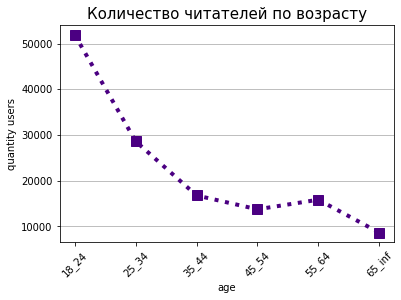

In [ ]:
# построим график распределения пользователей по возрасту

quantity_users_age.plot(linestyle=':',
                        linewidth=4,
                        marker='s',
                        markersize=10,
                        color='indigo',
                        legend=None,
                        rot=45)

plt.title('Количество читателей по возрасту', fontsize=15)
plt.ylabel('quantity users')
plt.grid(axis='y')

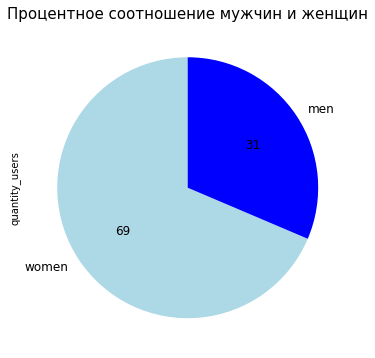

In [ ]:
# построим график соотношения мужчин и женщин среди всех зарегистрированных читателей

quantity_users_sex.plot.pie(y='quantity_users',
                            autopct='%.0f',
                            labels=['women','men'],
                            colors=['lightblue','blue'],
                            fontsize=12,
                            figsize=(6,6),
                            legend=None,
                            startangle=90)
plt.title('Процентное соотношение мужчин и женщин', fontsize=15)
plt.grid()

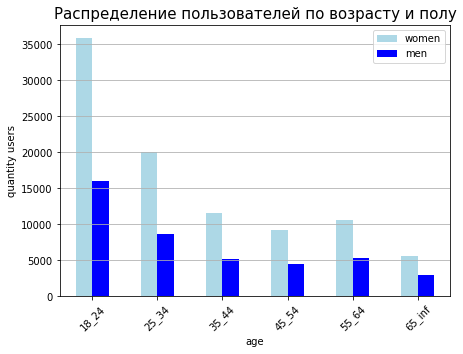

In [ ]:
# построим график распределения пользователей по возрасту и полу

quantity_users_age_sex.plot.bar(label=['women','men'],
                                color=['lightblue','blue'],
                                figsize=(7,5),
                                rot=45)
plt.legend(loc='upper right')
plt.title('Распределение пользователей по возрасту и полу', fontsize=15)
plt.ylabel('quantity users')
plt.grid(axis='y')

In [ ]:
# переиндексируем строки в датафрейме (для следующего графика)

unique_users_year = unique_users_year.reset_index()
unique_users_year

start_year  user_id
0       2018   131320
1       2019   129745

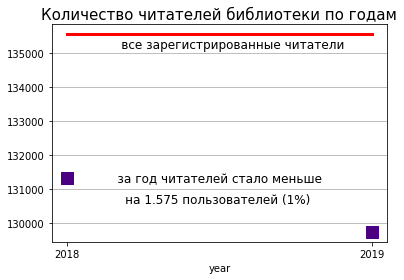

In [ ]:
# построим график количества читателей библиотеки по годам

plt.scatter(['2018', '2019'], unique_users_year['user_id'],
            s=150,
            marker='s',
            color='indigo')

# добавим линию с общим количеством зарегистрированных читателей (их 135.553)
u_u = df_data_all['user_id'].nunique()

plt.plot(['2018', '2019'], [u_u, u_u],
        color='red',
        linewidth=3)

# добавим комментарии к графику
plt.text('2018', 135150, '              все зарегистрированные читатели', fontsize=12)
plt.text('2018', 131200, '             за год читателей стало меньше', fontsize=12)
plt.text('2018', 130600, '               на 1.575 пользователей (1%)', fontsize=12)

plt.title('Количество читателей библиотеки по годам', fontsize=15)
plt.xlabel('year')
plt.grid(axis='y')

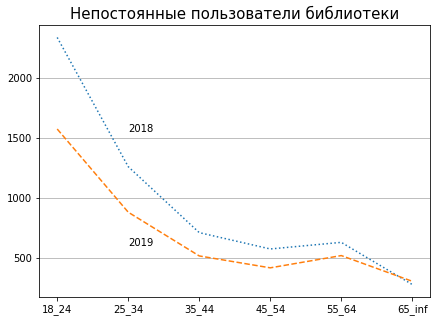

In [21]:
# построим график распределения "временных" читателей по возрасту

plt.figure(figsize=(7,5))
plt.plot(group_2018_age['age'], group_2018_age['user_2018'], ':', group_2019_age['age'], group_2019_age['user_2019'], '--')

plt.title('Непостоянные пользователи библиотеки', fontsize=15)
plt.text('25_34', 1550, '2018')
plt.text('25_34', 600, '2019')

plt.grid(axis='y')

Графики возрастного распределения всех зарегистрированных читателей библиотеки и непостоянных пользователей - идентичны (и от года - по имеющимся данным - не зависят).

### Выявление самых популярных жанров

In [ ]:
# создадим датафрейм жанров

df_data_genres = df_data_all.drop(['user_id','item_id','progress','rating','start_date','title','authors_all','year','age','age_group','sex_all','start_year','start_month'], axis=1)
df_data_genres.head(2)

Семья / дети / воспитание  Forex  IT-менеджмент  MBA  PR  \
0                          0      0              0    0   0   
1                          0      0              0    0   0   

   Project-менеджмент  Автомобили и ПДД  Автотранспорт  Агрохимия  Адвокатура  \
0                   0                 0              0          0           0   
1                   0                 0              0          0           0   

   ...  Юмор и сатира  Юмористическая проза  Юмористическая фантастика  \
0  ...              0                     0                          0   
1  ...              0                     0                          0   

   Юмористические стихи  Юмористическое фэнтези  Юридические журналы  \
0                     0                       0                    0   
1                     0                       0                    0   

   Юриспруденция  Языковые словари  Языкознание  Японский менеджмент  
0              0                 0            0                    0  
1              0                 0            0                    0  

[2 rows x 633 columns]

In [ ]:
# сохраним данные в csv-файл

df_data_genres.to_csv('data_genres.csv', index=False)

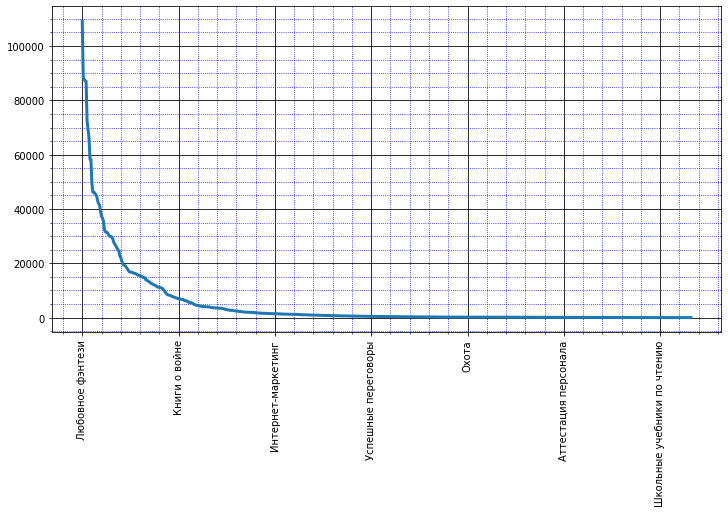

In [ ]:
# посмотрим на общую "читаемость" жанров

df_data_genres.sum()\
    .sort_values(ascending=False)\
    .plot(linewidth=3, figsize=(12,6), x_compat=True, rot=90)

# добавим основную сетку
plt.grid(which='major', color='k')

# добавим вспомогательную сетку, "включив" второстепенные деления
plt.minorticks_on()
plt.grid(which='minor', color='b', linestyle=':')

Согласно графику, значимый рост популярности жанров начинается с отметки 20.000 - столько раз за два года читатели интересовались книгами выбранной тематики.

In [ ]:
# выделим в датафрейм жанры, "прочитанные" более 20.000 раз
# (воспользуемся ранее написанной функцией)

df_data_genres_20000 = model_dataframe(df_data_genres, 20000)
df_data_genres_20000

Биографии и мемуары  Боевая фантастика  Боевое фэнтези  Газеты  \
0                          0                  0               0       0   
1                          0                  0               0       0   
2                          0                  0               0       0   
3                          0                  0               0       0   
4                          0                  0               0       0   
...                      ...                ...             ...     ...   
1398876                    0                  0               0       0   
1398877                    0                  0               0       0   
1398878                    0                  1               0       0   
1398879                    0                  0               0       0   
1398880                    0                  0               0       0   

         Героическое фэнтези  Городское фэнтези  Журнальные издания  \
0                          0                  0                   0   
1                          0                  0                   0   
2                          0                  0                   0   
3                          0                  0                   0   
4                          0                  0                   0   
...                      ...                ...                 ...   
1398876                    0                  0                   0   
1398877                    0                  0                   0   
1398878                    0                  0                   0   
1398879                    0                  0                   0   
1398880                    0                  0                   0   

         Зарубежная классика  Зарубежная психология  Зарубежная фантастика  \
0                          0                      0                      0   
1                          0                      0                      0   
2                          0                      0                      0   
3                          0                      0                      0   
4                          0                      0                      0   
...                      ...                    ...                    ...   
1398876                    1                      0                      0   
1398877                    1                      0                      0   
1398878                    0                      0                      0   
1398879                    0                      0                      0   
1398880                    0                      0                      0   

         ...  Саморазвитие / личностный рост  \
0        ...                               0   
1        ...                               0   
2        ...                               0   
3        ...                               0   
4        ...                               0   
...      ...                             ...   
1398876  ...                               0   
1398877  ...                               0   
1398878  ...                               0   
1398879  ...                               0   
1398880  ...                               0   

         Современная зарубежная литература  Современная русская литература  \
0                                        0                               0   
1                                        0                               0   
2                                        0                               0   
3                                        0                               0   
4                                        0                               0   
...                                    ...                             ...   
1398876                                  0                               0   
1398877                                  0                               0   
1398878                                

In [ ]:
# посмотрим на названия отобранных жанров

df_data_genres_20000.columns

Index(['Биографии и мемуары', 'Боевая фантастика', 'Боевое фэнтези', 'Газеты',
       'Героическое фэнтези', 'Городское фэнтези', 'Журнальные издания',
       'Зарубежная классика', 'Зарубежная психология', 'Зарубежная фантастика',
       'Зарубежное фэнтези', 'Зарубежные детективы',
       'Зарубежные любовные романы', 'Здоровье', 'Иронические детективы',
       'Историческая фантастика', 'Книги о приключениях',
       'Книги про волшебников', 'Короткие любовные романы',
       'Космическая фантастика', 'Литература 19 века', 'Литература 20 века',
       'Любовное фэнтези', 'Магические академии', 'Мистика',
       'Научная фантастика', 'Общая история', 'Остросюжетные любовные романы',
       'Полицейские детективы', 'Попаданцы', 'Публицистика',
       'Русская классика', 'Саморазвитие / личностный рост',
       'Современная зарубежная литература', 'Современная русская литература',
       'Современные детективы', 'Современные любовные романы',
       'Социальная фантастика', 'Триллеры',

In [ ]:
# создадим датафрейм с 42-мя популярными жанрами из итогового сводного

columns = ['user_id','item_id','progress','rating','title','authors_all','year','age','age_group','sex_all','start_year','start_month']

df_data_all_42best_genres = df_data_all[[x for x in columns] + [y for y in df_data_genres_20000.columns]]

df_data_all_42best_genres

user_id  item_id  progress  rating  \
0         126706    14433        80     NaN   
1         127290   140952        58     NaN   
2          46791    83486        23     5.0   
3          79313   188770        88     5.0   
4          63454    78434        87     NaN   
...          ...      ...       ...     ...   
1398876    76968   285394        95     NaN   
1398877   153877   285394        76     5.0   
1398878    90021    73789        97     NaN   
1398879     6452    77993        39     NaN   
1398880    70445   230195         2     NaN   

                                            title  \
0                                   Девятный Спас   
1                        Алмаз в воровскую корону   
2          Идеальная талия для вашего типа фигуры   
3                                   Стихотворения   
4                             Рай со свистом пуль   
...                                           ...   
1398876                                  Хитрость   
1398877                                  Хитрость   
1398878                               Дикая охота   
1398879  Новогодние детективные истории (сборник)   
1398880                                 По счетам   

                                               authors_all       year     age  \
0                                       Анатолий Брусникин       2007   25_34   
1                                            Евгений Сухов       2006   25_34   
2                                          Ванесса Томпсон       2003   18_24   
3                                          Игорь Северянин  не указан   55_64   
4                                            Сергей Зверев       2012   25_34   
...                                                    ...        ...     ...   
1398876                                     Ги де Мопассан  не указан   55_64   
1398877                                     Ги де Мопассан  не указан  65_inf   
1398878                                    Роман Афанасьев       2014   45_54   
1398879  Мария Брикер,Наталья Александрова,Анна и Серге...       2018   55_64   
1398880                                Андрей Константинов       2019  65_inf   

         age_group  sex_all  ... Саморазвитие / личностный рост  \
0              2.0      0.0  ...                              0   
1              2.0      0.0  ...                              0   
2              1.0      1.0  ...                              0   
3              5.0      0.0  ...                              0   
4              2.0      0.0  ...                              0   
...            ...      ...  ...                            ...   
1398876        5.0      1.0  ...                              0   
1398877        6.0      0.0  ...                              0   
1398878        4.0      0.0  ...                              0   
1398879        5.0      1.0  ...                              0   
1398880        6.0      0.0  ...                              0   

        Современная зарубежная литература  Современная русская литература  \
0                                       0                               0   
1                                       0                               0   
2                                       0                               0   
3                                       0                               0   
4                                       0                               0   
...                                   ...                             ...   
1398876                                 0                               0   
1398877                                 0                               0   
1398878                                 0                               0   
1398879                                 0                               0   
1398880                                 0                               0   

         Современные детективы  Современные любовные романы  \
0                            0           

In [ ]:
# сохраним данные в csv-файл

df_data_all_42best_genres.to_csv('data_all_42best_genres.csv', index=False)

In [5]:
# прочитаем сохраненный csv-файл

df_data_all_42best_genres = pd.read_csv('data_all_42best_genres.csv')
df_data_all_42best_genres.head(3)

user_id  item_id  progress  rating                                   title  \
0   126706    14433        80     NaN                           Девятный Спас   
1   127290   140952        58     NaN                Алмаз в воровскую корону   
2    46791    83486        23     5.0  Идеальная талия для вашего типа фигуры   

          authors_all  year    age  age_group  sex_all  ...  \
0  Анатолий Брусникин  2007  25_34        2.0      0.0  ...   
1       Евгений Сухов  2006  25_34        2.0      0.0  ...   
2     Ванесса Томпсон  2003  18_24        1.0      1.0  ...   

   Саморазвитие / личностный рост  Современная зарубежная литература  \
0                               0                                  0   
1                               0                                  0   
2                               0                                  0   

   Современная русская литература  Современные детективы  \
0                               0                      0   
1                               0                      0   
2                               0                      0   

   Современные любовные романы  Социальная фантастика  Триллеры  \
0                            0                      0         0   
1                            0                      0         0   
2                            0                      0         0   

   Эзотерика / оккультизм  Эротические романы  Юмористическое фэнтези  
0                       0                   0                       0  
1                       0                   0                       0  
2                       0                   0                       0  

[3 rows x 54 columns]

In [ ]:
# выделим жанры и возраст пользователей

df_data_all_42best_genres_age = df_data_all_42best_genres.drop(['user_id','item_id','progress','rating','title','authors_all','year','age_group','sex_all','start_year','start_month'], axis=1)

df_data_all_42best_genres_age.head(3)

age  Биографии и мемуары  Боевая фантастика  Боевое фэнтези  Газеты  \
0  25_34                    0                  0               0       0   
1  25_34                    0                  0               0       0   
2  18_24                    0                  0               0       0   

   Героическое фэнтези  Городское фэнтези  Журнальные издания  \
0                    0                  0                   0   
1                    0                  0                   0   
2                    0                  0                   0   

   Зарубежная классика  Зарубежная психология  ...  \
0                    0                      0  ...   
1                    0                      0  ...   
2                    0                      0  ...   

   Саморазвитие / личностный рост  Современная зарубежная литература  \
0                               0                                  0   
1                               0                                  0   
2                               0                                  0   

   Современная русская литература  Современные детективы  \
0                               0                      0   
1                               0                      0   
2                               0                      0   

   Современные любовные романы  Социальная фантастика  Триллеры  \
0                            0                      0         0   
1                            0                      0         0   
2                            0                      0         0   

   Эзотерика / оккультизм  Эротические романы  Юмористическое фэнтези  
0                       0                   0                       0  
1                       0                   0                       0  
2                       0                   0                       0  

[3 rows x 43 columns]

In [ ]:
# сгруппируем данные по возрасту

df_data_all_42_age = df_data_all_42best_genres_age\
                    .groupby('age')\
                    .sum()
df_data_all_42_age

Биографии и мемуары  Боевая фантастика  Боевое фэнтези  Газеты  \
age                                                                      
18_24                 13395              17905           16070   10949   
25_34                  7645              13369           11669    6393   
35_44                  4558               9837            8012    3786   
45_54                  3851              10017            7385    3229   
55_64                  4623              12391            9934    3631   
65_inf                 2625               5974            5244    3412   

        Героическое фэнтези  Городское фэнтези  Журнальные издания  \
age                                                                  
18_24                 19333               8218               10581   
25_34                 14215               5855                6049   
35_44                 10247               4087                3530   
45_54                  9373               3609                3449   
55_64                 12715               4950                3541   
65_inf                 6558               2783                2709   

        Зарубежная классика  Зарубежная психология  Зарубежная фантастика  \
age                                                                         
18_24                 11520                  17564                   8237   
25_34                  6555                   8377                   4974   
35_44                  4039                   4594                   3219   
45_54                  3340                   3394                   2746   
55_64                  3784                   3411                   3456   
65_inf                 2095                   1680                   1897   

        ...  Саморазвитие / личностный рост  \
age     ...                                   
18_24   ...                           25426   
25_34   ...                           12699   
35_44   ...                            6941   
45_54   ...                            5263   
55_64   ...                            5398   
65_inf  ...                            2644   

        Современная зарубежная литература  Современная русская литература  \
age                                                                         
18_24                               11218                           26377   
25_34                                6704                           17059   
35_44                                4268                           11554   
45_54                                3327                           10573   
55_64                                4382                           14065   
65_inf                               2511                            8943   

        Современные детективы  Современные любовные романы  \
age                                                          
18_24                   22489                        30597   
25_34                   16487                        18197   
35_44                   11633                        11589   
45_54                   10583                         8359   
55_64                   15412                        12247   
65_inf                  10615                         6812   

        Социальная фантастика  Триллеры  Эзотерика / оккультизм  \
age                                                               
18_24                    8588     13492                   10739   
25_34                    5334      9026                    5686   
35_44                    3332      6472                    3365   
45_54                    2927      5304                    2461   
55_64                    3566      7239                    2722   
65_inf                   1990      3718                    1314   

        Эротические романы  Юмористическое фэнтези  
age                                                 
18_24                16155                    8090  
25_34                10012                    5855

In [ ]:
# сохраним данные в csv-файл

df_data_all_42_age.to_csv('df_data_all_42_age.csv', index=False)

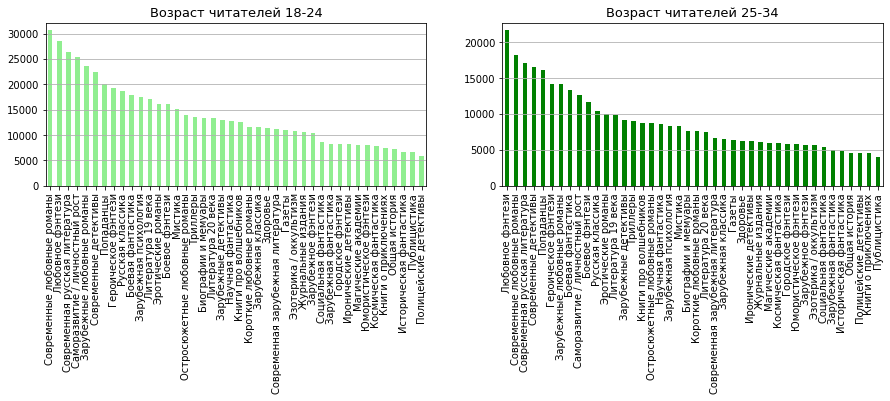

In [ ]:
# построим парные графики по возрастным категориям

plt.figure(figsize=(15,3))

plt.subplot(1, 2, 1)
df_data_all_42_age.iloc[0,0:]\
        .sort_values(ascending=False)\
        .plot.bar(legend=None, rot=90, color='lightgreen')
plt.title('Возраст читателей 18-24', fontsize=13)
plt.grid(axis='y')

plt.subplot(1, 2, 2)
df_data_all_42_age.iloc[1,0:]\
        .sort_values(ascending=False)\
        .plot.bar(legend=None, rot=90, color='green')
plt.title('Возраст читателей 25-34', fontsize=13)
plt.grid(axis='y')

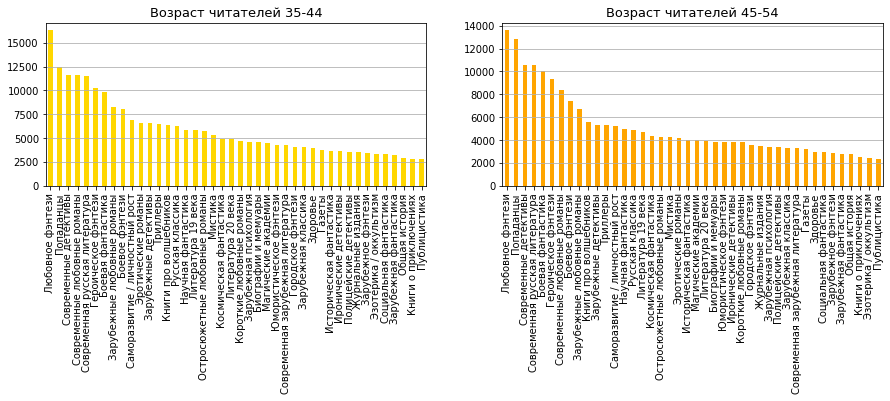

In [ ]:
# график следующей пары

plt.figure(figsize=(15,3))

plt.subplot(1, 2, 1)
df_data_all_42_age.iloc[2,0:]\
        .sort_values(ascending=False)\
        .plot.bar(legend=None, rot=90, color='gold')
plt.title('Возраст читателей 35-44', fontsize=13)
plt.grid(axis='y')

plt.subplot(1, 2, 2)
df_data_all_42_age.iloc[3,0:]\
        .sort_values(ascending=False)\
        .plot.bar(legend=None, rot=90, color='orange')
plt.title('Возраст читателей 45-54', fontsize=13)
plt.grid(axis='y')

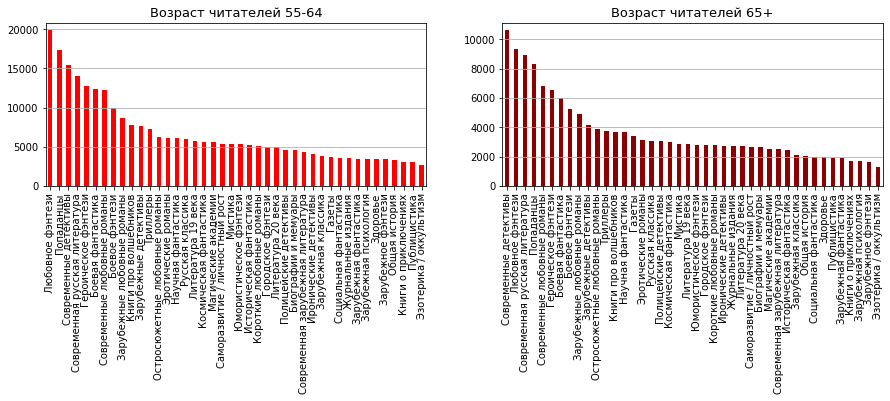

In [ ]:
# график старшей возрастной группы

plt.figure(figsize=(15,3))

plt.subplot(1, 2, 1)
df_data_all_42_age.iloc[4,0:]\
        .sort_values(ascending=False)\
        .plot.bar(legend=None, rot=90, color='red')
plt.title('Возраст читателей 55-64', fontsize=13)
plt.grid(axis='y')

plt.subplot(1, 2, 2)
df_data_all_42_age.iloc[5,0:]\
        .sort_values(ascending=False)\
        .plot.bar(legend=None, rot=90, color='darkred')
plt.title('Возраст читателей 65+', fontsize=13)
plt.grid(axis='y')

In [ ]:
# соберем топ-10 жанров по каждой возрастной группе

top_10_genres_age = pd.DataFrame([
    ['современные любовные романы','V','V','V','V','V','V'],
    ['любовное фэнтези','V','V','V','V','V','V'],
    ['современная русская литература','V','V','V','V','V','V'],
    ['саморазвитие/личностный рост','V','V','V','-','-','-'],
    ['зарубежные любовные романы','V','V','V','V','V','V'],
    ['современные детективы','V','V','V','V','V','V'],
    ['попаданцы','V','V','V','V','V','V'],
    ['боевая фантастика','V','V','V','V','V','V'],
    ['героическое фэнтези','V','V','V','V','V','V'],
    ['русская классика','V','-','-','-','-','-'],
    ['боевое фэнтези','-','V','V','V','V','V'],
    ['книги про волшебников','-','-','-','V','V','-'],
    ['зарубежные детективы','-','-','-','-','-','V']
    ],
    columns=['genres','18-24','25-34','35-44','45-54','55-64','65+']
)
top_10_genres_age

genres 18-24 25-34 35-44 45-54 55-64 65+
0      современные любовные романы     V     V     V     V     V   V
1                 любовное фэнтези     V     V     V     V     V   V
2   современная русская литература     V     V     V     V     V   V
3     саморазвитие/личностный рост     V     V     V     -     -   -
4       зарубежные любовные романы     V     V     V     V     V   V
5            современные детективы     V     V     V     V     V   V
6                        попаданцы     V     V     V     V     V   V
7                боевая фантастика     V     V     V     V     V   V
8              героическое фэнтези     V     V     V     V     V   V
9                 русская классика     V     -     -     -     -   -
10                  боевое фэнтези     -     V     V     V     V   V
11           книги про волшебников     -     -     -     V     V   -
12            зарубежные детективы     -     -     -     -     -   V

Неподвластными времени, т.е. возрасту, оказались следующие жанры:

1) "Современные любовные романы",
2) "Любовное фэнтези",
3) "Современная русская литература",
4) "Зарубежные любовные романы",
5) "Современные детективы",
6) "Попаданцы",
7) "Боевая фантастика",
8) "Героическое фэнтези".

Жанр "Боевое фэнтези" не попал в топ-10 только у самых молодых читателей.

In [ ]:
# выделим жанры и пол пользователей

df_data_all_42best_genres_sex = df_data_all_42best_genres.drop(['user_id','item_id','progress','rating','title','authors_all','year','age','age_group','start_year','start_month'], axis=1)

df_data_all_42best_genres_sex.head(3)

sex_all  Биографии и мемуары  Боевая фантастика  Боевое фэнтези  Газеты  \
0      0.0                    0                  0               0       0   
1      0.0                    0                  0               0       0   
2      1.0                    0                  0               0       0   

   Героическое фэнтези  Городское фэнтези  Журнальные издания  \
0                    0                  0                   0   
1                    0                  0                   0   
2                    0                  0                   0   

   Зарубежная классика  Зарубежная психология  ...  \
0                    0                      0  ...   
1                    0                      0  ...   
2                    0                      0  ...   

   Саморазвитие / личностный рост  Современная зарубежная литература  \
0                               0                                  0   
1                               0                                  0   
2                               0                                  0   

   Современная русская литература  Современные детективы  \
0                               0                      0   
1                               0                      0   
2                               0                      0   

   Современные любовные романы  Социальная фантастика  Триллеры  \
0                            0                      0         0   
1                            0                      0         0   
2                            0                      0         0   

   Эзотерика / оккультизм  Эротические романы  Юмористическое фэнтези  
0                       0                   0                       0  
1                       0                   0                       0  
2                       0                   0                       0  

[3 rows x 43 columns]

In [ ]:
# сгруппируем данные по полу

df_data_all_42_sex = df_data_all_42best_genres_sex\
                    .groupby('sex_all')\
                    .sum()
df_data_all_42_sex

Биографии и мемуары  Боевая фантастика  Боевое фэнтези  Газеты  \
sex_all                                                                   
0.0                    25408              35080           32969   20556   
1.0                    11289              34413           25345   10844   

         Героическое фэнтези  Городское фэнтези  Журнальные издания  \
sex_all                                                               
0.0                    46530              20915               19595   
1.0                    25911               8587               10264   

         Зарубежная классика  Зарубежная психология  Зарубежная фантастика  \
sex_all                                                                      
0.0                    22518                  28714                  16043   
1.0                     8815                  10306                   8486   

         ...  Саморазвитие / личностный рост  \
sex_all  ...                                   
0.0      ...                           42429   
1.0      ...                           15942   

         Современная зарубежная литература  Современная русская литература  \
sex_all                                                                      
0.0                                  25264                           64823   
1.0                                   7146                           23748   

         Современные детективы  Современные любовные романы  \
sex_all                                                       
0.0                      67580                        71172   
1.0                      19639                        16629   

         Социальная фантастика  Триллеры  Эзотерика / оккультизм  \
sex_all                                                            
0.0                      16069     33309                   18641   
1.0                       9668     11942                    7646   

         Эротические романы  Юмористическое фэнтези  
sex_all                                              
0.0                   37027                   23341  
1.0                    9173                    6870  

[2 rows x 42 columns]

In [ ]:
# сохраним данные

df_data_all_42_sex.to_csv('df_data_all_42_sex.csv', index=False)

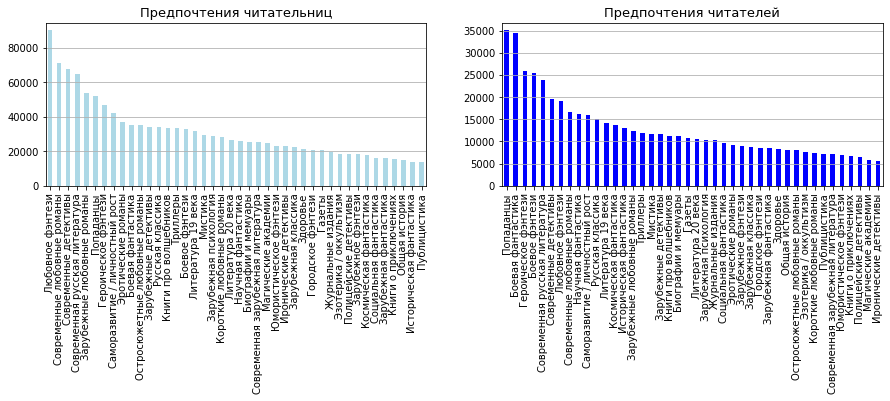

In [ ]:
# построим графики по читателям и читательницам

plt.figure(figsize=(15,3))

plt.subplot(1, 2, 1)
df_data_all_42_sex.iloc[0,0:]\
        .sort_values(ascending=False)\
        .plot.bar(legend=None, rot=90, color='lightblue')
plt.title('Предпочтения читательниц', fontsize=13)
plt.grid(axis='y')

plt.subplot(1, 2, 2)
df_data_all_42_sex.iloc[1,0:]\
        .sort_values(ascending=False)\
        .plot.bar(legend=None, rot=90, color='blue')
plt.title('Предпочтения читателей', fontsize=13)
plt.grid(axis='y')

In [ ]:
# соберем топ-10 жанров по читателям и читательницам

top_10_genres_sex = pd.DataFrame([
    ['любовное фэнтези','V','V'],
    ['современные любовные романы','V','V'],
    ['современные детективы','V','V'],
    ['современная русская литература','V','V'],
    ['зарубежные любовные романы','V','-'],
    ['попаданцы','V','V'],
    ['героическое фэнтези','V','V'],
    ['саморазвитие/личностный рост','V','V'],
    ['эротические романы', 'V', '-'],
    ['боевая фантастика','V','V'],
    ['боевое фэнтези','-','V'],
    ['научная фантастика','-','V'],
    ],
    columns=['genres','women','men']
)
top_10_genres_sex

genres women men
0                 любовное фэнтези     V   V
1      современные любовные романы     V   V
2            современные детективы     V   V
3   современная русская литература     V   V
4       зарубежные любовные романы     V   -
5                        попаданцы     V   V
6              героическое фэнтези     V   V
7     саморазвитие/личностный рост     V   V
8               эротические романы     V   -
9                боевая фантастика     V   V
10                  боевое фэнтези     -   V
11              научная фантастика     -   V

In [ ]:
# объединим два датафрейма

genres_age_sex = top_10_genres_age.merge(top_10_genres_sex, left_on='genres', right_on='genres', how='outer')
genres_age_sex = genres_age_sex.fillna('-')
genres_age_sex

genres 18-24 25-34 35-44 45-54 55-64 65+ women men
0      современные любовные романы     V     V     V     V     V   V     V   V
1                 любовное фэнтези     V     V     V     V     V   V     V   V
2   современная русская литература     V     V     V     V     V   V     V   V
3     саморазвитие/личностный рост     V     V     V     -     -   -     V   V
4       зарубежные любовные романы     V     V     V     V     V   V     V   -
5            современные детективы     V     V     V     V     V   V     V   V
6                        попаданцы     V     V     V     V     V   V     V   V
7                боевая фантастика     V     V     V     V     V   V     V   V
8              героическое фэнтези     V     V     V     V     V   V     V   V
9                 русская классика     V     -     -     -     -   -     -   -
10                  боевое фэнтези     -     V     V     V     V   V     -   V
11           книги про волшебников     -     -     -     V     V   -     -   -
12            зарубежные детективы     -     -     -     -     -   V     -   -
13              эротические романы     -     -     -     -     -   -     V   -
14              научная фантастика     -     -     -     -     -   -     -   V

Из выбранных жанров, интересных как пользователям всех возрастов, так и читателям с читательницами, выделим самые популярные для дальнейшего рассмотрения:

1. "Современные любовные романы",
2. "Любовное фэнтези",
3. "Современная русская литература",
4. "Зарубежные любовные романы",
5. "Современные детективы",
6. "Попаданцы",
7. "Боевая фантастика",
8. "Героическое фэнтези",
9. "Боевое фэнтези".

Оставшиеся шесть жанров рассматривать не будем, т.к.:

* "Саморазвитие/личностный рост" - интересны лишь первой половине возрастных групп,
* "Русская классика" - вошла в топ-10 только у читателей до 25 лет,
* "Книги про волшебников" - читает 1/5 всей аудитории (по количеству пользователей),
* "Зарубежные детективы", "Эротические романы" и "Научная фантастика" - в числе популярных жанров у отдельных категорий читателей.

### Абонемент "пресса": газеты и журналы

В библиотеке МТС есть абонемент "пресса", куда входят различные газеты и журналы.

Периодические издания пользуются спросом - они оказались в списке изначально отобранных самых популярных 42-х жанров. Посмотрим, всем ли группам читателей интересны газеты и журналы и что из них читают чаще.

In [ ]:
# выделим данные по прочитанным газетам и журналам

df_data_all_age_pressa = df_data_all_42_age[['Газеты', 'Журнальные издания']]
df_data_all_age_pressa

Газеты  Журнальные издания
age                               
18_24    10949               10581
25_34     6393                6049
35_44     3786                3530
45_54     3229                3449
55_64     3631                3541
65_inf    3412                2709

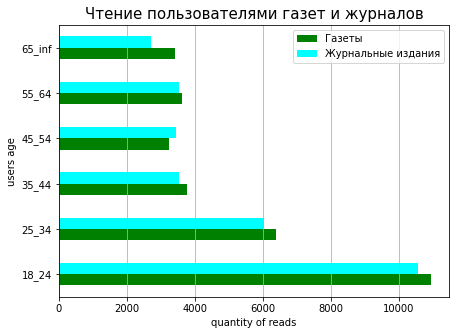

In [ ]:
# построим график

df_data_all_age_pressa.plot.barh(figsize=(7,5),
                                color=['green','cyan'])
plt.legend()
plt.title('Чтение пользователями газет и журналов', fontsize=15)
plt.xlabel('quantity of reads')
plt.ylabel('users age')
plt.grid(axis='x')

График построен, и это важно, по исходным данным: корректность отнесения того или иного издания к "газетам" или "журналам" еще не проверялась!

Тем не менее, наглядно отражена общая заинтересованность периодическими изданиями у читательских групп.

In [ ]:
# сформируем датафрейм по газетам и журналам

df_data_all_newspaper_journal = df_data_all_42best_genres[['item_id','title','age','sex_all','Газеты', 'Журнальные издания']]

df_data_all_newspaper_journal = df_data_all_newspaper_journal\
    .loc[(df_data_all_newspaper_journal['Газеты']==1) | (df_data_all_newspaper_journal['Журнальные издания']==1)]
df_data_all_newspaper_journal

item_id                                   title     age  sex_all  \
43        285667                 Спорт-экспресс 198-2019   18_24      0.0   
54        269175                         Сабрина 12-2019  65_inf      0.0   
64        213283                         Профиль 15-2017   25_34      1.0   
66        258019           Комсомольская правда 47т-2012   18_24      0.0   
86        250030  Добрые Советы. Люблю Готовить! 09-2018   18_24      1.0   
...          ...                                     ...     ...      ...   
1398752   261203                            Лиза 52-2019   45_54      0.0   
1398776   243588                 Караван Историй 01-2013  65_inf      1.0   
1398840   155624               Интерес-кроссворд 38-2017   55_64      1.0   
1398846    92946               Интерес-кроссворд 46-2017   25_34      0.0   
1398872     4804                         Сабрина 01-2016   55_64      1.0   

         Газеты  Журнальные издания  
43            1                   0  
54            1                   0  
64            0                   1  
66            1                   0  
86            0                   1  
...         ...                 ...  
1398752       0                   1  
1398776       0                   1  
1398840       1                   0  
1398846       1                   0  
1398872       1                   0  

[59733 rows x 6 columns]

Названия периодических изданий содержат "лишнюю" информацию в виде номера и года выпуска - уберем это с помощью регулярных выражений.

In [ ]:
# создадим паттерн

pattern = r'[а-яёА-ЯЁa-zA-Z\d\s\§\@\#\№\$\%\&\*\;\=\[\]\{\}\.\,\:\!\?\(\)\'\-\|\/\\\+]+\s'

In [ ]:
# поместим названия в кавычки (для работы с регулярным выражением)

df_data_all_newspaper_journal.update('"' + df_data_all_newspaper_journal['title'] + '"')
df_data_all_newspaper_journal.head(3)

item_id                      title     age  sex_all  Газеты  \
43   285667  "Спорт-экспресс 198-2019"   18_24      0.0       1   
54   269175          "Сабрина 12-2019"  65_inf      0.0       1   
64   213283          "Профиль 15-2017"   25_34      1.0       0   

    Журнальные издания  
43                   0  
54                   0  
64                   1

In [ ]:
# запишем в новый столбец "очищенные" названия

df_data_all_newspaper_journal['издания'] = df_data_all_newspaper_journal['title'].map(lambda x: re.findall(pattern, x))
df_data_all_newspaper_journal.head(3)

item_id                      title     age  sex_all  Газеты  \
43   285667  "Спорт-экспресс 198-2019"   18_24      0.0       1   
54   269175          "Сабрина 12-2019"  65_inf      0.0       1   
64   213283          "Профиль 15-2017"   25_34      1.0       0   

    Журнальные издания            издания  
43                   0  [Спорт-экспресс ]  
54                   0         [Сабрина ]  
64                   1         [Профиль ]

In [ ]:
# преобразуем полученные значения в строки (сейчас это строки-списки)
# запишем названия большими буквами (для единообразия)

df_data_all_newspaper_journal.update(df_data_all_newspaper_journal['издания'].astype(str).str.replace('\[|\]',''))
df_data_all_newspaper_journal['издания'] = df_data_all_newspaper_journal['издания'].str.upper()
df_data_all_newspaper_journal.head(3)

item_id                      title     age  sex_all  Газеты  \
43   285667  "Спорт-экспресс 198-2019"   18_24      0.0       1   
54   269175          "Сабрина 12-2019"  65_inf      0.0       1   
64   213283          "Профиль 15-2017"   25_34      1.0       0   

    Журнальные издания            издания  
43                   0  'СПОРТ-ЭКСПРЕСС '  
54                   0         'САБРИНА '  
64                   1         'ПРОФИЛЬ '

In [ ]:
# определим количество уникальных изданий

df_data_all_newspaper_journal['издания'].nunique()

169

In [ ]:
# посмотрим на их перечень

df_data_all_newspaper_journal['издания'].unique()

array(["'СПОРТ-ЭКСПРЕСС '", "'САБРИНА '", "'ПРОФИЛЬ '",
       "'КОМСОМОЛЬСКАЯ ПРАВДА '", "'ДОБРЫЕ СОВЕТЫ. ЛЮБЛЮ ГОТОВИТЬ! '",
       "'ТВОЙ ДЕНЬ '", "'INTEREST-CROSSWORD '",
       "'АРГУМЕНТЫ И ФАКТЫ МОСКВА '", '"MEN\'S HEALTH "', "'ПРАВДА '",
       "'СЕМЬ ДНЕЙ ТВ-ПРОГРАММА '", "'ЗВЕЗДЫ И СОВЕТЫ '",
       "'ЗНАНИЕ-СИЛА '", "'ТАЙНЫ ЗВЕЗД '", "'ВСЕ ДЛЯ ЖЕНЩИНЫ '",
       "'МК МОСКОВСКИЙ КОМСОМОЛЕЦ '", "'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '",
       "'КЛАССНЫЙ ЖУРНАЛ '",
       "'КОМСОМОЛЬСКАЯ ПРАВДА (ТОЛСТУШКА ', ' РОССИЯ) '", "'СМЕНА '",
       "'КУЛЬТУРА '", "'КАРАВАН ИСТОРИЙ. КОЛЛЕКЦИЯ '", "'АВТОМИР '",
       "'НАША ВЕРСИЯ '", "'ЖЕЛТАЯ ГАЗЕТА. ЗАЖИГАЙ! '", "'ЗА РУЛЕМ '",
       "'MAXIM '", "'ОГОНЁК '", "'ЖЕЛТАЯ ГАЗЕТА. ТОЛЬКО ЗВЕЗДЫ '",
       "'ДАЧА PRESSA.RU '", "'ВЯЗАНИЕ\\XA0', ' ВАШЕ ХОББИ '",
       "'ОРАКУЛ. ГАЗЕТА ПРЕДСКАЗАНИЙ '",
       "'КОМСОМОЛЬСКАЯ ПРАВДА. САНКТ-ПЕТЕРБУРГ '", "'ИЗВЕСТИЯ '",
       "'ДОБРЫЕ СОВЕТЫ '", "'КАРАВАН ИСТОРИЙ '", "'ELLE '",
       "'ЖДУ МАЛЫША '", "'MAR

Среди изданий оказались "непонятные" названия - их четыре, посмотрим, каковы они в оригинале.

In [ ]:
# журнал по вязанию

df_data_all_newspaper_journal[df_data_all_newspaper_journal['издания'].str.contains("' ВАШЕ ХОББИ '")]

item_id                           title    age  sex_all  Газеты  \
922       256645  "Вязание – Ваше Хобби 03-2015"  55_64      1.0       0   
1011      223931       "Вязание – Ваше Хобби 09"  35_44      0.0       0   
3119      185027  "Вязание – Ваше Хобби 05-2019"  35_44      1.0       0   
3403      201578  "Вязание – Ваше Хобби 03-2019"  45_54      0.0       0   
5481        6645  "Вязание – Ваше Хобби 06-2015"  35_44      0.0       0   
...          ...                             ...    ...      ...     ...   
1396628   300914  "Вязание – Ваше Хобби 03-2016"  18_24      0.0       0   
1397152   161284  "Вязание – Ваше Хобби 05-2018"  55_64      0.0       0   
1397717   127774  "Вязание – Ваше Хобби 12-2012"  25_34      0.0       0   
1397855   141773  "Вязание – Ваше Хобби 10-2019"  18_24      1.0       0   
1398047   242739  "Вязание – Ваше Хобби 06-2018"  45_54      0.0       0   

         Журнальные издания                        издания  
922                       1  'ВЯЗАНИЕ\XA0', ' ВАШЕ ХОББИ '  
1011                      1  'ВЯЗАНИЕ\XA0', ' ВАШЕ ХОББИ '  
3119                      1  'ВЯЗАНИЕ\XA0', ' ВАШЕ ХОББИ '  
3403                      1  'ВЯЗАНИЕ\XA0', ' ВАШЕ ХОББИ '  
5481                      1  'ВЯЗАНИЕ\XA0', ' ВАШЕ ХОББИ '  
...                     ...                            ...  
1396628                   1  'ВЯЗАНИЕ\XA0', ' ВАШЕ ХОББИ '  
1397152                   1  'ВЯЗАНИЕ\XA0', ' ВАШЕ ХОББИ '  
1397717                   1  'ВЯЗАНИЕ\XA0', ' ВАШЕ ХОББИ '  
1397855                   1  'ВЯЗАНИЕ\XA0', ' ВАШЕ ХОББИ '  
1398047                   1  'ВЯЗАНИЕ\XA0', ' ВАШЕ ХОББИ '  

[1088 rows x 7 columns]

In [ ]:
# журнал по истории

df_data_all_newspaper_journal[df_data_all_newspaper_journal['издания'].str.contains("'РУССКОЙ '")]

item_id                                   title     age  sex_all  \
1274       49181  "История от «Русской Семерки» 01-2018"   35_44      1.0   
1914      269352  "История от «Русской Семерки» 02-2016"   18_24      0.0   
4331      174469  "История от «Русской Семерки» 02-2018"   25_34      1.0   
5003       85320  "История от «Русской Семерки» 10-2017"   55_64      0.0   
5688      257365  "История от «Русской Семерки» 11-2017"   25_34      0.0   
...          ...                                     ...     ...      ...   
1390107   225339  "История от «Русской Семерки» 10-2019"   25_34      0.0   
1393353   308636  "История от «Русской Семерки» 03-2018"  65_inf      0.0   
1394104   225339  "История от «Русской Семерки» 10-2019"   18_24      0.0   
1397674   302254  "История от «Русской Семерки» 08-2017"   25_34      1.0   
1397757   234564  "История от «Русской Семерки» 10-2016"   55_64      0.0   

         Газеты  Журнальные издания                    издания  
1274          0                   1  'ИСТОРИЯ ОТ ', 'РУССКОЙ '  
1914          0                   1  'ИСТОРИЯ ОТ ', 'РУССКОЙ '  
4331          0                   1  'ИСТОРИЯ ОТ ', 'РУССКОЙ '  
5003          0                   1  'ИСТОРИЯ ОТ ', 'РУССКОЙ '  
5688          0                   1  'ИСТОРИЯ ОТ ', 'РУССКОЙ '  
...         ...                 ...                        ...  
1390107       0                   1  'ИСТОРИЯ ОТ ', 'РУССКОЙ '  
1393353       0                   1  'ИСТОРИЯ ОТ ', 'РУССКОЙ '  
1394104       0                   1  'ИСТОРИЯ ОТ ', 'РУССКОЙ '  
1397674       0                   1  'ИСТОРИЯ ОТ ', 'РУССКОЙ '  
1397757       0                   1  'ИСТОРИЯ ОТ ', 'РУССКОЙ '  

[604 rows x 7 columns]

In [ ]:
# журнал про фантастику

df_data_all_newspaper_journal[df_data_all_newspaper_journal['издания'].str.contains("'ФАНТАСТИКА И '")]

item_id                                           title     age  \
7819      266363            "Журнал «Фантастика и Детективы» №9"   45_54   
9018      302001            "Журнал «Фантастика и Детективы» №1"  65_inf   
9064      128789           "Журнал «Фантастика и Детективы» №12"  65_inf   
25525     128147            "Журнал «Фантастика и Детективы» №8"   45_54   
25867      41301  "Журнал «Фантастика и Детективы» №4 (16) 2014"   35_44   
...          ...                                             ...     ...   
1355459   128789           "Журнал «Фантастика и Детективы» №12"   18_24   
1379641   302001            "Журнал «Фантастика и Детективы» №1"   35_44   
1384194    72357            "Журнал «Фантастика и Детективы» №7"  65_inf   
1392468   317111            "Журнал «Фантастика и Детективы» №4"   18_24   
1392651   151434            "Журнал «Фантастика и Детективы» №6"   25_34   

         sex_all  Газеты  Журнальные издания  \
7819         1.0       0                   1   
9018         0.0       0                   1   
9064         0.0       0                   1   
25525        1.0       0                   1   
25867        1.0       0                   1   
...          ...     ...                 ...   
1355459      0.0       0                   1   
1379641      1.0       0                   1   
1384194      0.0       0                   1   
1392468      0.0       0                   1   
1392651      0.0       0                   1   

                                         издания  
7819                  'ЖУРНАЛ ', 'ФАНТАСТИКА И '  
9018                  'ЖУРНАЛ ', 'ФАНТАСТИКА И '  
9064                  'ЖУРНАЛ ', 'ФАНТАСТИКА И '  
25525                 'ЖУРНАЛ ', 'ФАНТАСТИКА И '  
25867    'ЖУРНАЛ ', 'ФАНТАСТИКА И ', ' №4 (16) '  
...                                          ...  
1355459               'ЖУРНАЛ ', 'ФАНТАСТИКА И '  
1379641               'ЖУРНАЛ ', 'ФАНТАСТИКА И '  
1384194               'ЖУРНАЛ ', 'ФАНТАСТИКА И '  
1392468               'ЖУРНАЛ ', 'ФАНТАСТИКА И '  
1392651               'ЖУРНАЛ ', 'ФАНТАСТИКА И '  

[232 rows x 7 columns]

In [ ]:
# журнал издательства Оксфордского университета

df_data_all_newspaper_journal[df_data_all_newspaper_journal['издания'].str.contains("'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '")]

item_id                                              title    age  \
88615     155520  "Notes and Queries, Number 56, November 23, 1850"  25_34   
98647     155520  "Notes and Queries, Number 56, November 23, 1850"  18_24   
161965    155520  "Notes and Queries, Number 56, November 23, 1850"  35_44   
269506    155520  "Notes and Queries, Number 56, November 23, 1850"  55_64   
294421    155520  "Notes and Queries, Number 56, November 23, 1850"  18_24   
345662    155520  "Notes and Queries, Number 56, November 23, 1850"  18_24   
422772    155520  "Notes and Queries, Number 56, November 23, 1850"  25_34   
512764    155520  "Notes and Queries, Number 56, November 23, 1850"  45_54   
513478    155520  "Notes and Queries, Number 56, November 23, 1850"  25_34   
842881    155520  "Notes and Queries, Number 56, November 23, 1850"  35_44   
878905    155520  "Notes and Queries, Number 56, November 23, 1850"  35_44   
996722    155520  "Notes and Queries, Number 56, November 23, 1850"  18_24   
1070889   155520  "Notes and Queries, Number 56, November 23, 1850"  45_54   
1309270   155520  "Notes and Queries, Number 56, November 23, 1850"  55_64   
1334160   155520  "Notes and Queries, Number 56, November 23, 1850"  18_24   

         sex_all  Газеты  Журнальные издания  \
88615        0.0       0                   1   
98647        0.0       0                   1   
161965       1.0       0                   1   
269506       1.0       0                   1   
294421       1.0       0                   1   
345662       0.0       0                   1   
422772       0.0       0                   1   
512764       0.0       0                   1   
513478       0.0       0                   1   
842881       1.0       0                   1   
878905       1.0       0                   1   
996722       1.0       0                   1   
1070889      1.0       0                   1   
1309270      0.0       0                   1   
1334160      0.0       0                   1   

                                               издания  
88615    'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
98647    'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
161965   'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
269506   'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
294421   'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
345662   'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
422772   'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
512764   'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
513478   'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
842881   'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
878905   'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
996722   'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
1070889  'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
1309270  'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '  
1334160  'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '

In [ ]:
# скорректируем названия (часть 1)

df_data_all_newspaper_journal\
    .loc[df_data_all_newspaper_journal['издания'] == "'ВЯЗАНИЕ\\XA0', ' ВАШЕ ХОББИ '", 'title_new'] = "'ВЯЗАНИЕ - ВАШЕ ХОББИ '"

df_data_all_newspaper_journal\
    .loc[df_data_all_newspaper_journal['издания'] == "'ИСТОРИЯ ОТ ', 'РУССКОЙ '", 'title_new'] = "'ИСТОРИЯ ОТ РУССКОЙ СЕМЕРКИ '"

df_data_all_newspaper_journal\
    .loc[df_data_all_newspaper_journal['издания'] == "'NOTES AND QUERIES, NUMBER 56, NOVEMBER 23, '", 'title_new'] = "'NOTES AND QUERIES '"

In [ ]:
# скорректируем названия (часть 2)

journal_fantasy = ["'ЖУРНАЛ ', 'ФАНТАСТИКА И '", "'ЖУРНАЛ ', 'ФАНТАСТИКА И ', ' №4 (16) '", "'ЖУРНАЛ ', 'ФАНТАСТИКА И ', ' №6 (18) '", "'ЖУРНАЛ ', 'ФАНТАСТИКА И ', ' №11 (23) '", "'ЖУРНАЛ ', 'ФАНТАСТИКА И ', ' №1 (13) '", 
"'ЖУРНАЛ ', 'ФАНТАСТИКА И ', ' №7 (19) '"]

df_data_all_newspaper_journal\
    .loc[df_data_all_newspaper_journal['издания'].isin(journal_fantasy), 'title_new'] = "'ЖУРНАЛ ФАНТАСТИКА И ДЕТЕКТИВЫ '"

df_data_all_newspaper_journal

item_id                                     title     age  sex_all  \
43        285667                 "Спорт-экспресс 198-2019"   18_24      0.0   
54        269175                         "Сабрина 12-2019"  65_inf      0.0   
64        213283                         "Профиль 15-2017"   25_34      1.0   
66        258019           "Комсомольская правда 47т-2012"   18_24      0.0   
86        250030  "Добрые Советы. Люблю Готовить! 09-2018"   18_24      1.0   
...          ...                                       ...     ...      ...   
1398752   261203                            "Лиза 52-2019"   45_54      0.0   
1398776   243588                 "Караван Историй 01-2013"  65_inf      1.0   
1398840   155624               "Интерес-кроссворд 38-2017"   55_64      1.0   
1398846    92946               "Интерес-кроссворд 46-2017"   25_34      0.0   
1398872     4804                         "Сабрина 01-2016"   55_64      1.0   

         Газеты  Журнальные издания                            издания  \
43            1                   0                  'СПОРТ-ЭКСПРЕСС '   
54            1                   0                         'САБРИНА '   
64            0                   1                         'ПРОФИЛЬ '   
66            1                   0            'КОМСОМОЛЬСКАЯ ПРАВДА '   
86            0                   1  'ДОБРЫЕ СОВЕТЫ. ЛЮБЛЮ ГОТОВИТЬ! '   
...         ...                 ...                                ...   
1398752       0                   1                            'ЛИЗА '   
1398776       0                   1                 'КАРАВАН ИСТОРИЙ '   
1398840       1                   0               'ИНТЕРЕС-КРОССВОРД '   
1398846       1                   0               'ИНТЕРЕС-КРОССВОРД '   
1398872       1                   0                         'САБРИНА '   

        title_new  
43            NaN  
54            NaN  
64            NaN  
66            NaN  
86            NaN  
...           ...  
1398752       NaN  
1398776       NaN  
1398840       NaN  
1398846       NaN  
1398872       NaN  

[59733 rows x 8 columns]

In [ ]:
# внесем недостающие значения

df_data_all_newspaper_journal\
    .loc[df_data_all_newspaper_journal['title_new'].isna(), 'title_new'] = df_data_all_newspaper_journal['издания']

df_data_all_newspaper_journal.head()

item_id                                     title     age  sex_all  \
43   285667                 "Спорт-экспресс 198-2019"   18_24      0.0   
54   269175                         "Сабрина 12-2019"  65_inf      0.0   
64   213283                         "Профиль 15-2017"   25_34      1.0   
66   258019           "Комсомольская правда 47т-2012"   18_24      0.0   
86   250030  "Добрые Советы. Люблю Готовить! 09-2018"   18_24      1.0   

    Газеты  Журнальные издания                            издания  \
43       1                   0                  'СПОРТ-ЭКСПРЕСС '   
54       1                   0                         'САБРИНА '   
64       0                   1                         'ПРОФИЛЬ '   
66       1                   0            'КОМСОМОЛЬСКАЯ ПРАВДА '   
86       0                   1  'ДОБРЫЕ СОВЕТЫ. ЛЮБЛЮ ГОТОВИТЬ! '   

                            title_new  
43                  'СПОРТ-ЭКСПРЕСС '  
54                         'САБРИНА '  
64                         'ПРОФИЛЬ '  
66            'КОМСОМОЛЬСКАЯ ПРАВДА '  
86  'ДОБРЫЕ СОВЕТЫ. ЛЮБЛЮ ГОТОВИТЬ! '

In [ ]:
# удалим лишний столбец

df_data_all_newspaper_journal = df_data_all_newspaper_journal.drop(['издания'], axis=1)
df_data_all_newspaper_journal.head(3)

item_id                      title     age  sex_all  Газеты  \
43   285667  "Спорт-экспресс 198-2019"   18_24      0.0       1   
54   269175          "Сабрина 12-2019"  65_inf      0.0       1   
64   213283          "Профиль 15-2017"   25_34      1.0       0   

    Журнальные издания          title_new  
43                   0  'СПОРТ-ЭКСПРЕСС '  
54                   0         'САБРИНА '  
64                   1         'ПРОФИЛЬ '

Предположение о том, что периодические издания могут быть отнесены не к той категории, оказалось верным. Подтверждение тому - журнал "Сабрина", который учтен в "газетах".

Сделаем еще одну проверку - на журнале "Советский спорт. Футбол".

In [ ]:
# выведем строки с данным изданием

df_data_all_newspaper_journal\
    .loc[df_data_all_newspaper_journal['title_new'] == "'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '"]

item_id                              title    age  sex_all  Газеты  \
426       114938       "Советский Спорт. Футбол 40"  55_64      0.0       1   
1058        6037       "Советский Спорт. Футбол 43"  18_24      0.0       1   
1085      302924      "Советский Спорт. Футбол 31п"  35_44      1.0       1   
1168      131164       "Советский Спорт. Футбол 52"  25_34      0.0       1   
1293      214464  "Советский Спорт. Футбол 33-2019"  55_64      0.0       1   
...          ...                                ...    ...      ...     ...   
1395858   306783  "Советский Спорт. Футбол 43-2017"  18_24      0.0       1   
1396184   122500  "Советский Спорт. Футбол 46-2016"  45_54      1.0       1   
1397287   148261  "Советский Спорт. Футбол 32-2016"  18_24      0.0       1   
1398166   132984       "Советский Спорт. Футбол 48"  45_54      0.0       1   
1398556   302369       "Советский Спорт. Футбол 49"  18_24      0.0       1   

         Журнальные издания                   title_new  
426                       0  'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '  
1058                      0  'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '  
1085                      0  'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '  
1168                      0  'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '  
1293                      1  'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '  
...                     ...                         ...  
1395858                   1  'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '  
1396184                   1  'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '  
1397287                   1  'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '  
1398166                   0  'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '  
1398556                   0  'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '  

[2048 rows x 7 columns]

Как видим, текущее деление периодических изданий на газеты и журналы для аналитики не пригодно. Для определения читательских предпочтений будем использовать конкретные названия.

В перечне российских изданий присутствуют их английские аналоги, например: "Интерес-кроссворд" и "INTEREST-CROSSWORD", "Советский спорт" и "SOVIET SPORT", "МК Московский комсомолец" и "MK MOSKOVSKII KOMSOMOLETS" и другие.

Поскольку мы не располагаем информацией о том, ошибка это или "специальный перевод" изданий, подобные "английские" газеты и журналы рассматриваться не будут.

In [ ]:
# сгруппируем данные по названию

news_group = df_data_all_newspaper_journal\
            .groupby(['title_new'])\
            .count().sort_values(by='Газеты', ascending=False)\
            .rename(columns={'Газеты':'количество'})[['количество']]
news_group

количество
title_new                               
'ТВОЙ ДЕНЬ '                        6469
'НАША ВЕРСИЯ '                      2543
'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '          2048
'ПРОФИЛЬ '                          2000
'ИНТЕРЕС-КРОССВОРД '                1833
...                                  ...
'ЛОШАДКИ '                            10
'THE RAKE '                           10
'AVTOMIR '                            10
'ПРИХОД № 22 (ЯНВАРЬ 2016) '           6
'MK MOSKOVSKII KOMSOMOLETS '           2

[164 rows x 1 columns]

Рассмотрим издания, которыми интересовались больше 1 раза за день, иначе - которые прочитали более 900 раз (если разделить 900 на 24 (данные за два года), получится 37.5, т.е. за месяц газету или журнал прочитали больше 37 раз, а именно - больше 1 раза за день).

In [ ]:
# выделим требуемый перечень изданий

news_group[news_group['количество'] > 900]

количество
title_new                                           
'ТВОЙ ДЕНЬ '                                    6469
'НАША ВЕРСИЯ '                                  2543
'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '                      2048
'ПРОФИЛЬ '                                      2000
'ИНТЕРЕС-КРОССВОРД '                            1833
'МК МОСКОВСКИЙ КОМСОМОЛЕЦ '                     1827
'ТАЙНЫ ЗВЕЗД '                                  1755
'ЗВЕЗДЫ И СОВЕТЫ '                              1670
'ИЗВЕСТИЯ '                                     1647
'ВСЕ ДЛЯ ЖЕНЩИНЫ '                              1582
'СОВЕТСКИЙ СПОРТ (ФЕДЕРАЛЬНЫЙ ВЫПУСК) '         1337
'СПОРТ-ЭКСПРЕСС '                               1203
'КАРАВАН ИСТОРИЙ '                              1124
'ВЯЗАНИЕ - ВАШЕ ХОББИ '                         1088
'КОММЕРСАНТЪ (ПОНЕДЕЛЬНИК-ПЯТНИЦА) '            1050
'ЛИЗА '                                          970
'КОМСОМОЛЬСКАЯ ПРАВДА. САНКТ-ПЕТЕРБУРГ '         912
'КОМСОМОЛЬСКАЯ ПРАВДА '                          905

Газета "Комсомольская правда" издается во многих городах, названия которых присутствуют в названии газеты. Популярность такого издания логично рассматривать в целом по Издательскому дому, т.е. с охватом по всем городам, но это уже отдельное исследование.

Здесь же рассмотрим другие популярные издания (их 16), которые "разделим" на газеты и журналы согласно данным сайта *https://pressa.ru*.

In [ ]:
# составим список газет

news_top = ["'ТВОЙ ДЕНЬ '",
"'НАША ВЕРСИЯ '",
"'ИНТЕРЕС-КРОССВОРД '",
"'МК МОСКОВСКИЙ КОМСОМОЛЕЦ '",
"'ИЗВЕСТИЯ '",
"'СОВЕТСКИЙ СПОРТ (ФЕДЕРАЛЬНЫЙ ВЫПУСК) '",
"'СПОРТ-ЭКСПРЕСС '",
"'КОММЕРСАНТЪ (ПОНЕДЕЛЬНИК-ПЯТНИЦА) '"]

In [ ]:
# и журналов

jour_top = ["'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '",
"'ПРОФИЛЬ '",
"'ТАЙНЫ ЗВЕЗД '",
"'ЗВЕЗДЫ И СОВЕТЫ '",
"'ВСЕ ДЛЯ ЖЕНЩИНЫ '",
"'КАРАВАН ИСТОРИЙ '",
"'ВЯЗАНИЕ - ВАШЕ ХОББИ '",
"'ЛИЗА '"]

Сначала рассмотрим выбранные газеты.

In [ ]:
# создадим датафрейм - данные по газетам и читателям-женщинам

paper_group_women = df_data_all_newspaper_journal\
        .loc[(df_data_all_newspaper_journal['title_new'].isin(news_top)) & (df_data_all_newspaper_journal['sex_all']==0)]

paper_group_women

item_id                                            title    age  \
43        285667                        "Спорт-экспресс 198-2019"  18_24   
92        216463                             "Твой день 211-2015"  18_24   
404       315424                             "Твой день 190-2014"  18_24   
690       142279                            "Наша версия 35-2014"  18_24   
694       230557                            "Наша Версия 06-2018"  55_64   
...          ...                                              ...    ...   
1398402   202239                            "Наша версия 50-2015"  55_64   
1398618   209974  "Советский Спорт (Федеральный выпуск) 193-2019"  55_64   
1398628   164672                               "Известия 54-2017"  18_24   
1398741    88254                               "Известия 20-2019"  18_24   
1398846    92946                      "Интерес-кроссворд 46-2017"  25_34   

         sex_all  Газеты  Журнальные издания  \
43           0.0       1                   0   
92           0.0       1                   0   
404          0.0       1                   0   
690          0.0       1                   0   
694          0.0       1                   0   
...          ...     ...                 ...   
1398402      0.0       1                   0   
1398618      0.0       1                   0   
1398628      0.0       1                   0   
1398741      0.0       1                   0   
1398846      0.0       1                   0   

                                       title_new  
43                             'СПОРТ-ЭКСПРЕСС '  
92                                  'ТВОЙ ДЕНЬ '  
404                                 'ТВОЙ ДЕНЬ '  
690                               'НАША ВЕРСИЯ '  
694                               'НАША ВЕРСИЯ '  
...                                          ...  
1398402                           'НАША ВЕРСИЯ '  
1398618  'СОВЕТСКИЙ СПОРТ (ФЕДЕРАЛЬНЫЙ ВЫПУСК) '  
1398628                              'ИЗВЕСТИЯ '  
1398741                              'ИЗВЕСТИЯ '  
1398846                     'ИНТЕРЕС-КРОССВОРД '  

[11575 rows x 7 columns]

In [ ]:
# сделаем группировку по возрасту

paper_top_women = paper_group_women.groupby(['title_new','age'])\
                .count().rename(columns={'Газеты': 'quantity'})[['quantity']]

paper_top_women.to_csv('paper_top_women.csv', index=False)

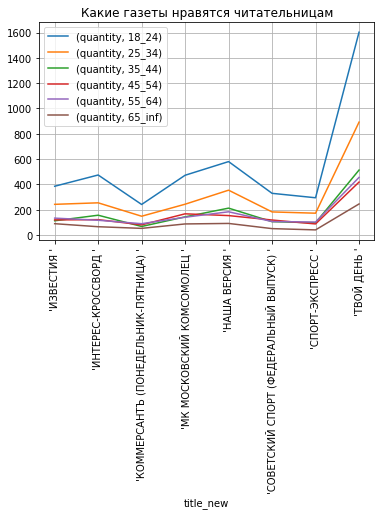

In [ ]:
# и построим график

paper_top_women.unstack('age').plot(rot=90)
plt.title('Какие газеты нравятся читательницам')
plt.legend()
plt.grid()

In [ ]:
# создадим датафрейм - данные по газетам и читателям-мужчинам

paper_group_men = df_data_all_newspaper_journal\
        .loc[(df_data_all_newspaper_journal['title_new'].isin(news_top)) & (df_data_all_newspaper_journal['sex_all']==1)]

paper_group_men

item_id                                            title     age  \
334       321216              "МК Московский Комсомолец 164-2019"   25_34   
358        29763                        "Спорт-экспресс 176-2019"   45_54   
541        46183                             "Твой день 133-2015"   18_24   
549       259795                        "Спорт-экспресс 260-2019"   45_54   
920       190735                             "Твой день 134-2014"  65_inf   
...          ...                                              ...     ...   
1398445   121476                             "Твой день 177-2014"   25_34   
1398504   129911                             "Твой день 100-2014"   35_44   
1398720    80291  "Советский Спорт (Федеральный выпуск) 242-2019"   45_54   
1398728   282951                             "Твой день 215-2014"   18_24   
1398840   155624                      "Интерес-кроссворд 38-2017"   55_64   

         sex_all  Газеты  Журнальные издания  \
334          1.0       1                   0   
358          1.0       1                   0   
541          1.0       1                   0   
549          1.0       1                   0   
920          1.0       1                   0   
...          ...     ...                 ...   
1398445      1.0       1                   0   
1398504      1.0       1                   0   
1398720      1.0       1                   0   
1398728      1.0       1                   0   
1398840      1.0       1                   0   

                                       title_new  
334                  'МК МОСКОВСКИЙ КОМСОМОЛЕЦ '  
358                            'СПОРТ-ЭКСПРЕСС '  
541                                 'ТВОЙ ДЕНЬ '  
549                            'СПОРТ-ЭКСПРЕСС '  
920                                 'ТВОЙ ДЕНЬ '  
...                                          ...  
1398445                             'ТВОЙ ДЕНЬ '  
1398504                             'ТВОЙ ДЕНЬ '  
1398720  'СОВЕТСКИЙ СПОРТ (ФЕДЕРАЛЬНЫЙ ВЫПУСК) '  
1398728                             'ТВОЙ ДЕНЬ '  
1398840                     'ИНТЕРЕС-КРОССВОРД '  

[6334 rows x 7 columns]

In [ ]:
# сделаем группировку по возрасту

paper_top_men = paper_group_men.groupby(['title_new','age'])\
                .count().rename(columns={'Газеты': 'quantity'})[['quantity']]

paper_top_men.to_csv('paper_top_men.csv', index=False)

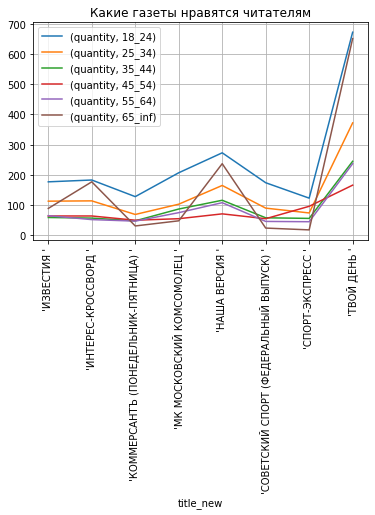

In [ ]:
# и построим график

paper_top_men.unstack('age').plot(rot=90)
plt.title('Какие газеты нравятся читателям')
plt.legend()
plt.grid()

Самой популярной и всеми читаемой оказалась газета "Твой день" - ежедневное издание со светской хроникой, шоу-бизнесом, гороскопом, гаданием и другими подобными рубриками.

Отметим, что если у читательниц интерес к выбранным изданиям практически одинаков, то у читателей-мужчин выделяется самая возрастная группа (от 65 и старше): по количеству прочитанных газет ("Интерес-кроссворд", "Наша версия", "Твой день") эти пользователи приближаются к молодежи, обгоняя остальных.

Теперь обратимся к журналам.

In [ ]:
# создадим датафрейм - данные по журналам и читателям-женщинам

jour_group_women = df_data_all_newspaper_journal\
        .loc[(df_data_all_newspaper_journal['title_new'].isin(jour_top)) & (df_data_all_newspaper_journal['sex_all']==0)]

jour_group_women

item_id                         title    age  sex_all  Газеты  \
300       129084     "Все Для Женщины 42-2017"  45_54      0.0       0   
325       277434     "Звезды и Советы 18-2018"  18_24      0.0       0   
426       114938  "Советский Спорт. Футбол 40"  55_64      0.0       1   
449        33868     "Звезды и Советы 26-2018"  25_34      0.0       0   
560       220877             "Профиль 47-2018"  25_34      0.0       0   
...          ...                           ...    ...      ...     ...   
1398166   132984  "Советский Спорт. Футбол 48"  45_54      0.0       1   
1398203   235622         "Тайны Звезд 04-2018"  25_34      0.0       1   
1398556   302369  "Советский Спорт. Футбол 49"  18_24      0.0       1   
1398568    31262             "Профиль 01-2015"  35_44      0.0       0   
1398752   261203                "Лиза 52-2019"  45_54      0.0       0   

         Журнальные издания                   title_new  
300                       1          'ВСЕ ДЛЯ ЖЕНЩИНЫ '  
325                       1          'ЗВЕЗДЫ И СОВЕТЫ '  
426                       0  'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '  
449                       1          'ЗВЕЗДЫ И СОВЕТЫ '  
560                       1                  'ПРОФИЛЬ '  
...                     ...                         ...  
1398166                   0  'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '  
1398203                   0              'ТАЙНЫ ЗВЕЗД '  
1398556                   0  'СОВЕТСКИЙ СПОРТ. ФУТБОЛ '  
1398568                   1                  'ПРОФИЛЬ '  
1398752                   1                     'ЛИЗА '  

[7973 rows x 7 columns]

In [ ]:
# сделаем группировку по возрасту

jour_top_women = jour_group_women.groupby(['title_new','age'])\
                    .count().rename(columns={'title': 'quantity'})[['quantity']]

jour_top_women.to_csv('jour_top_women.csv', index=False)

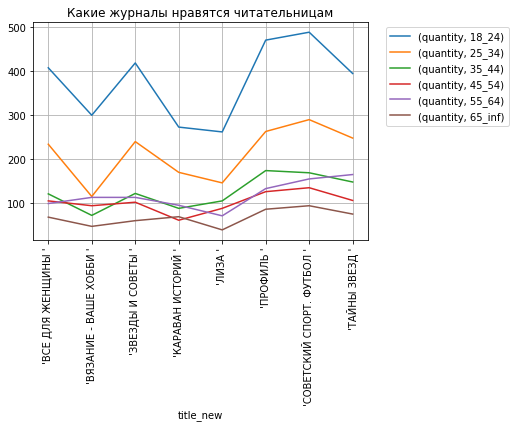

In [ ]:
# и построим график

jour_top_women.unstack('age').plot(rot=90)
plt.title('Какие журналы нравятся читательницам')

# вынесем легенду за рамки
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid()

In [ ]:
# создадим датафрейм - данные по журналам и читателям-мужчинам

jour_group_men = df_data_all_newspaper_journal\
        .loc[(df_data_all_newspaper_journal['title_new'].isin(jour_top)) & (df_data_all_newspaper_journal['sex_all']==1)]
jour_group_men

item_id                           title     age  sex_all  Газеты  \
64        213283               "Профиль 15-2017"   25_34      1.0       0   
211       294406       "Звезды и Советы 30-2019"   18_24      1.0       0   
214        13613               "Профиль 48-2018"   25_34      1.0       0   
299       212309           "Тайны Звезд 32-2016"   18_24      1.0       1   
922       256645  "Вязание – Ваше Хобби 03-2015"   55_64      1.0       0   
...          ...                             ...     ...      ...     ...   
1397855   141773  "Вязание – Ваше Хобби 10-2019"   18_24      1.0       0   
1398232   139207       "Все Для Женщины 45-2017"   45_54      1.0       0   
1398239   244190                  "Лиза 02-2018"   55_64      1.0       0   
1398732   120537       "Все Для Женщины 39-2017"   55_64      1.0       0   
1398776   243588       "Караван Историй 01-2013"  65_inf      1.0       0   

         Журнальные издания                title_new  
64                        1               'ПРОФИЛЬ '  
211                       1       'ЗВЕЗДЫ И СОВЕТЫ '  
214                       1               'ПРОФИЛЬ '  
299                       0           'ТАЙНЫ ЗВЕЗД '  
922                       1  'ВЯЗАНИЕ - ВАШЕ ХОББИ '  
...                     ...                      ...  
1397855                   1  'ВЯЗАНИЕ - ВАШЕ ХОББИ '  
1398232                   1       'ВСЕ ДЛЯ ЖЕНЩИНЫ '  
1398239                   1                  'ЛИЗА '  
1398732                   1       'ВСЕ ДЛЯ ЖЕНЩИНЫ '  
1398776                   1       'КАРАВАН ИСТОРИЙ '  

[4264 rows x 7 columns]

In [ ]:
# сделаем группировку по возрасту

jour_top_men = jour_group_men.groupby(['title_new','age'])\
                    .count().rename(columns={'title': 'quantity'})[['quantity']]

jour_top_men.to_csv('jour_top_men.csv', index=False)

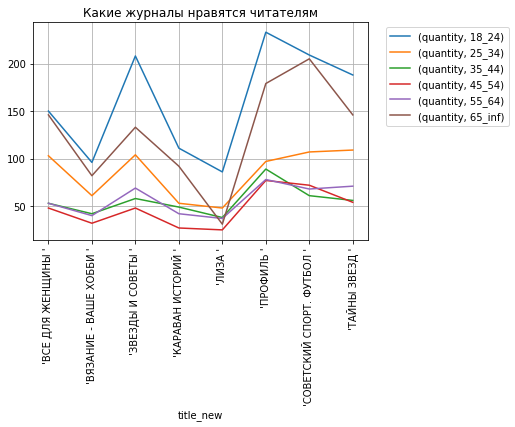

In [ ]:
# и построим график

jour_top_men.unstack('age').plot(rot=90)
plt.title('Какие журналы нравятся читателям')

# вынесем легенду
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.grid()

Чтение популярных журналов сравнимо с чтением популярных газет:

(1) у **читательниц** интерес к выбранным изданиям одинаковый и не зависит от возраста. Отметим журнал "Вязание - ваше хобби": возрастная категория 55-64 читает его наравне с тридцатилетними (если создать отдельный абонемент "Хобби", включив туда издания по вязанию, можно целенаправленно предлагать его этой группе пользователей).

(2) **читатели-мужчины** старше 65 читают выбранные журналы также активно, как и самая молодая группа. Всем одинаково интересны как журнал "Тайны звезд" или "Звезды и советы", так и женский журнал "Все для женщины". Примечательно, что возрастая категория от 35 до 65 лет читает журналы значительно меньше других.

У читательниц самым популярным стал журнал "Советский спорт. Футбол" (вероятно, это связано с проходившим в 2018 году чемпионатом мира по футболу), а у мужчин - журнал "Профиль" (еженедельное деловое издание с аналитическими прогнозами, рейтингами и обзорами в сфере экономики, политики, бизнеса и др.).

Определим газеты и журналы, которые за два года прочитали менее 25 раз, т.е. 1 раз за месяц и меньше.

In [ ]:
# определим малочитаемые издания

news_group[news_group['количество'] < 25]

количество
title_new                               
'PROFILE '                            24
'ЖДУ МАЛЫША '                         24
'ЭКСПЕРТ ЮГ '                         23
'БИЗНЕС ЖУРНАЛ '                      23
'КОМПАНИЯ '                           22
'МЕЖДУ НАМИ, ЖЕНЩИНАМИ '              19
'КОММЕРСАНТЪ ВЛАСТЬ '                 19
'KOMMERSANT '                         18
'СВАТЫ. ЗАГОТОВКИ '                   17
'ЭКСПЕРТ '                            16
'СТИЛЬНЫЕ ПРИЧЕСКИ '                  16
'NOTES AND QUERIES '                  15
'АИФ. ПРО ЗДОРОВЬЕ '                  15
'RBK '                                14
'OUR VERSION '                        13
'КОММЕРСАНТЪ ДЕНЬГИ '                 12
'МАМА, ЭТО Я! '                       12
'SOVIET SPORT '                       12
'КОТЭЛЛО '                            10
'ЛОШАДКИ '                            10
'THE RAKE '                           10
'AVTOMIR '                            10
'ПРИХОД № 22 (ЯНВАРЬ 2016) '           6
'MK MOSKOVSKII KOMSOMOLETS '           2

Перечень данных изданий не является окончательным - все зависит от интересов читателей (количества прочтений за период). Тем не менее, подобная выборка может служить ориентиром для внесения изменений в абонемент "пресса".

Добавим, что наличие в базе данных российских газет и журналов, написанных по-английски, требует разъяснений и приведения названий к единому языку и стилю написания.

### Авторы и их книги, написанные в востребованных жанрах

In [6]:
# создадим датафрейм с 9-ю популярными жанрами (их перечень определили ранее)

col = ['user_id','item_id','progress','rating','title','authors_all','year','age','age_group','sex_all','start_year','start_month',
       'Боевая фантастика',
       'Боевое фэнтези',
       'Героическое фэнтези',
       'Зарубежные любовные романы',
       'Любовное фэнтези',
       'Попаданцы',
       'Современная русская литература',
       'Современные детективы',
       'Современные любовные романы']

df_data_all_best_9genres = df_data_all_42best_genres[[x for x in col]]

df_data_all_best_9genres

user_id  item_id  progress  rating  \
0         126706    14433        80     NaN   
1         127290   140952        58     NaN   
2          46791    83486        23     5.0   
3          79313   188770        88     5.0   
4          63454    78434        87     NaN   
...          ...      ...       ...     ...   
1398876    76968   285394        95     NaN   
1398877   153877   285394        76     5.0   
1398878    90021    73789        97     NaN   
1398879     6452    77993        39     NaN   
1398880    70445   230195         2     NaN   

                                            title  \
0                                   Девятный Спас   
1                        Алмаз в воровскую корону   
2          Идеальная талия для вашего типа фигуры   
3                                   Стихотворения   
4                             Рай со свистом пуль   
...                                           ...   
1398876                                  Хитрость   
1398877                                  Хитрость   
1398878                               Дикая охота   
1398879  Новогодние детективные истории (сборник)   
1398880                                 По счетам   

                                               authors_all       year     age  \
0                                       Анатолий Брусникин       2007   25_34   
1                                            Евгений Сухов       2006   25_34   
2                                          Ванесса Томпсон       2003   18_24   
3                                          Игорь Северянин  не указан   55_64   
4                                            Сергей Зверев       2012   25_34   
...                                                    ...        ...     ...   
1398876                                     Ги де Мопассан  не указан   55_64   
1398877                                     Ги де Мопассан  не указан  65_inf   
1398878                                    Роман Афанасьев       2014   45_54   
1398879  Мария Брикер,Наталья Александрова,Анна и Серге...       2018   55_64   
1398880                                Андрей Константинов       2019  65_inf   

         age_group  sex_all  ...  start_month  Боевая фантастика  \
0              2.0      0.0  ...            1                  0   
1              2.0      0.0  ...            1                  0   
2              1.0      1.0  ...            1                  0   
3              5.0      0.0  ...            1                  0   
4              2.0      0.0  ...            1                  0   
...            ...      ...  ...          ...                ...   
1398876        5.0      1.0  ...           12                  0   
1398877        6.0      0.0  ...           12                  0   
1398878        4.0      0.0  ...           12                  1   
1398879        5.0      1.0  ...           12                  0   
1398880        6.0      0.0  ...           12                  0   

         Боевое фэнтези  Героическое фэнтези  Зарубежные любовные романы  \
0                     0                    0                           0   
1                     0                    0                           0   
2                     0                    0                           0   
3                     0                    0                           0   
4                     0                    0                           0   
...                 ...                  ...                         ...   
1398876               0                    0                           0   
1398877               0                    0                           0   
1398878               0                    0                           0   
1398879               0                    0                           0   
1398880               0                    0                           0   

         Любовное фэнтези  Попаданцы  Современная русская литература  \
0                       0       

In [7]:
# оставим строки, имеющие признаки любого из 9-ти жанров

df_data_all_best_9genres = df_data_all_best_9genres.loc[(df_data_all_best_9genres['Боевая фантастика']==1)\
                                                     | (df_data_all_best_9genres['Боевое фэнтези']==1)\
                                                     | (df_data_all_best_9genres['Героическое фэнтези']==1)\
                                                     | (df_data_all_best_9genres['Зарубежные любовные романы']==1)\
                                                     | (df_data_all_best_9genres['Любовное фэнтези']==1)\
                                                     | (df_data_all_best_9genres['Попаданцы']==1)\
                                                     | (df_data_all_best_9genres['Современная русская литература']==1)\
                                                     | (df_data_all_best_9genres['Современные детективы']==1)\
                                                     | (df_data_all_best_9genres['Современные любовные романы']==1)]
df_data_all_best_9genres

user_id  item_id  progress  rating  \
6          42797   315927        69     5.0   
7          47287   258483        22     NaN   
8          47551    64060        55     NaN   
12         64211    47139        12     NaN   
13          7074   164341        15     NaN   
...          ...      ...       ...     ...   
1398870    96118   282267        46     NaN   
1398875    33221   251316        50     NaN   
1398878    90021    73789        97     NaN   
1398879     6452    77993        39     NaN   
1398880    70445   230195         2     NaN   

                                            title  \
6                          Рассвет кровавой удачи   
7                       Русский фронтир (сборник)   
8                               Быстрая и шустрая   
12                     Весенний подарок (сборник)   
13                               Парк развлечений   
...                                           ...   
1398870               Жизнь взаймы и без гарантий   
1398875                                Дар оружия   
1398878                               Дикая охота   
1398879  Новогодние детективные истории (сборник)   
1398880                                 По счетам   

                                               authors_all       year     age  \
6                            Андрей Ворон (Mr. Incognito2)       2019   25_34   
7        Дмитрий Володихин,Далия Трускиновская,Александ...       2018   18_24   
8                                  Анна и Сергей Литвиновы       2002   35_44   
12        Елена Нестерина,Татьяна Тронина,Светлана Лубенец  не указан   25_34   
13                                           Карла Кэссиди       2015   55_64   
...                                                    ...        ...     ...   
1398870                                  Наталья Перфилова       2008   18_24   
1398875                                        Морган Райс       2013  65_inf   
1398878                                    Роман Афанасьев       2014   45_54   
1398879  Мария Брикер,Наталья Александрова,Анна и Серге...       2018   55_64   
1398880                                Андрей Константинов       2019  65_inf   

         age_group  sex_all  ...  start_month  Боевая фантастика  \
6              2.0      0.0  ...            1                  1   
7              1.0      0.0  ...            1                  1   
8              3.0      0.0  ...            1                  0   
12             2.0      1.0  ...            1                  0   
13             5.0      1.0  ...            1                  0   
...            ...      ...  ...          ...                ...   
1398870        1.0      0.0  ...           12                  0   
1398875        6.0      1.0  ...           12                  0   
1398878        4.0      0.0  ...           12                  1   
1398879        5.0      1.0  ...           12                  0   
1398880        6.0      0.0  ...           12                  0   

         Боевое фэнтези  Героическое фэнтези  Зарубежные любовные романы  \
6                     0                    0                           0   
7                     0                    0                           0   
8                     0                    0                           0   
12                    0                    0                           0   
13                    0                    0                           1   
...                 ...                  ...                         ...   
1398870               0                    0                           0   
1398875               1                    0                           0   
1398878               0                    0                           0   
1398879               0                    0                           0   
1398880               0                    0                           0   

         Любовное фэнтези  Попаданцы  Современная русская литература  \
6                       0       

In [ ]:
# сохраним данные

df_data_all_best_9genres.to_csv('data_all_best_9genres.csv', index=False)

In [9]:
# выделим книги жанра "Боевая фантастика"

df_battle_fiction = df_data_all_best_9genres.loc[df_data_all_best_9genres['Боевая фантастика']==1]
df_battle_fiction

user_id  item_id  progress  rating                      title  \
6          42797   315927        69     5.0     Рассвет кровавой удачи   
7          47287   258483        22     NaN  Русский фронтир (сборник)   
23         33450   316392        51     NaN          Сталь над волнами   
80         53839   294476         8     NaN                Возрождение   
88        134526   252971        56     5.0       Материализация мысли   
...          ...      ...       ...     ...                        ...   
1398814    76999   312316        97     NaN              Воссоединение   
1398823   110993   157300       100     NaN    ПереКРЕСТок одиночества   
1398837    52188   127836        52     NaN     Запрещенная фантастика   
1398848    47785   241249        69     NaN                  Спасатель   
1398878    90021    73789        97     NaN                Дикая охота   

                                               authors_all       year     age  \
6                            Андрей Ворон (Mr. Incognito2)       2019   25_34   
7        Дмитрий Володихин,Далия Трускиновская,Александ...       2018   18_24   
23                                    Александр Конторович       2016  65_inf   
80                                         Дмитрий Лазарев       2007   25_34   
88                                         Алексей Кутафин  не указан   25_34   
...                                                    ...        ...     ...   
1398814                                     Вячеслав Кумин       2008   18_24   
1398823                                       Дем Михайлов       2019   45_54   
1398837                                    Андрей Мансуров       2015   25_34   
1398848                                 Александр Калмыков       2018   55_64   
1398878                                    Роман Афанасьев       2014   45_54   

         age_group  sex_all  ...  start_month  Боевая фантастика  \
6              2.0      0.0  ...            1                  1   
7              1.0      0.0  ...            1                  1   
23             6.0      1.0  ...            1                  1   
80             2.0      0.0  ...            1                  1   
88             2.0      1.0  ...            1                  1   
...            ...      ...  ...          ...                ...   
1398814        1.0      0.0  ...           12                  1   
1398823        4.0      0.0  ...           12                  1   
1398837        2.0      1.0  ...           12                  1   
1398848        5.0      0.0  ...           12                  1   
1398878        4.0      0.0  ...           12                  1   

         Боевое фэнтези  Героическое фэнтези  Зарубежные любовные романы  \
6                     0                    0                           0   
7                     0                    0                           0   
23                    0                    0                           0   
80                    0                    0                           0   
88                    0                    0                           0   
...                 ...                  ...                         ...   
1398814               0                    0                           0   
1398823               0                    0                           0   
1398837               0                    0                           0   
1398848               0                    0                           0   
1398878               0                    0                           0   

         Любовное фэнтези  Попаданцы  Современная русская литература  \
6                       0          0                               0   
7                       0          0                               0   
23                      0          1                               0   
80                      0          0                               0   
88                      0          0                     

In [10]:
# определим количество авторов

df_battle_fiction['authors_all'].nunique()

771

In [11]:
# посмотрим их перечень

df_battle_fiction['authors_all'].unique()

array(['Андрей Ворон (Mr. Incognito2)',
       'Дмитрий Володихин,Далия Трускиновская,Александр Тюрин,Олег Дивов,Сергей Чекмаев,Эдуард Геворкян,Вадим Панов,Григорий Елисеев,Александр Белаш,Людмила Белаш,Игорь Прососов,Александр Марков,Сергей Сизарев,Дмитрий Федотов',
       'Александр Конторович', 'Дмитрий Лазарев', 'Алексей Кутафин',
       'Андрей Фролов', 'Сергей Чехин', 'Олег Дивов',
       'Александр Сивинских', 'Сергей Плотников', 'Татьяна Эдельвейс',
       'Александр Шакилов', 'Равиль Таминдаров', 'Хайдарали Усманов',
       'Макс Мах',
       'Андрей Дашков,Дмитрий Володихин,Юлия Зонис,Елена Красносельская,Игорь Вереснев,Николай Немытов,Олег Кожин,Майк Гелприн,Марина Ясинская,Сергей Чебаненко,Алекс Громов,Владимир Венгловский,Василий Головачев,Антон Тудаков,Андрей Звонков,Игорь Авильченко,Арина Свобода,Степан Вартанов,Яков Будницкий,Арти Александер,Дмитрий Лукин,Сергей Васильев,Анна Михалевская,Жаклин де\xa0Гё,Михаил Савеличев,Валентина Орлова,Павел Токаренко,Станислав Шульга,

Среди книг есть те, что написаны в соавторстве с одним или двумя писателями. Есть и сборники произведений - указан автор каждого рассказа или повести.

Разделять "коллективное творчество" на отдельных писателей, чтобы в целом оценить их популярность, не целесообразно: мы не получим ответ на вопрос из-за какого именно автора пользователи стали читать тот или иной сборник/книгу.

Поэтому возьмем исходный список авторов и найдем интересующую нас информацию.

In [12]:
# определим сколько раз читали каждого из авторов жанра "Боевая фантастика"

battle_fiction = df_battle_fiction.groupby('authors_all')\
                .count().sort_values(by='title', ascending=False)\
                .rename(columns={'title': 'reading'})[['reading']]
battle_fiction

reading
authors_all                                                
Сергей Тармашев                                        3084
Артем Каменистый                                       2826
Роман Злотников                                        2116
Владимир Поселягин                                     1752
Александр Конторович                                   1552
...                                                     ...
Ольга Комарова                                            6
Андрей Дашков,Михаил Кликин,Вадим Вознесенский,...        6
Алекс Уайт                                                6
Виталий Денисов                                           5
Евгений Михайлов                                          5

[771 rows x 1 columns]

In [13]:
# определим по каждому автору сколько книг загружено в библиотеку

battle_fiction_item = df_battle_fiction.groupby('authors_all')['item_id'].nunique()\
                        .reset_index().sort_values(by='item_id', ascending=False)\
                        .rename(columns={'item_id': 'number_of_books'})

battle_fiction_item

authors_all  number_of_books
221                                  Василий Головачев               68
753                                    Юрий Корчевский               58
17                                 Александр Афанасьев               53
157                                    Андрей Ливадный               50
10                                         Алекс Орлов               49
..                                                 ...              ...
218                                   Валерий Михайлов                1
470                                  Константин Костин                1
469                                Константин Колчигин                1
467                                    Константин Ежов                1
385  Евгений Лукин,Наталья Резанова,Николай Горнов,...                1

[771 rows x 2 columns]

In [14]:
# объединим полученные данные по авторам

battle_fiction_reading_items = battle_fiction.merge(battle_fiction_item, on='authors_all')

battle_fiction_reading_items

authors_all  reading  \
0                                      Сергей Тармашев     3084   
1                                     Артем Каменистый     2826   
2                                      Роман Злотников     2116   
3                                   Владимир Поселягин     1752   
4                                 Александр Конторович     1552   
..                                                 ...      ...   
766                                     Ольга Комарова        6   
767  Андрей Дашков,Михаил Кликин,Вадим Вознесенский...        6   
768                                         Алекс Уайт        6   
769                                    Виталий Денисов        5   
770                                   Евгений Михайлов        5   

     number_of_books  
0                 33  
1                 32  
2                 30  
3                 46  
4                 34  
..               ...  
766                1  
767                1  
768                1  
769                1  
770                1  

[771 rows x 3 columns]

In [15]:
# выведем список авторов, книги которых прочитали больше 1000 раз

battle_fiction_reading_items[battle_fiction_reading_items['reading'] > 1000]

authors_all  reading  number_of_books
0        Сергей Тармашев     3084               33
1       Артем Каменистый     2826               32
2        Роман Злотников     2116               30
3     Владимир Поселягин     1752               46
4   Александр Конторович     1552               34
5        Юрий Корчевский     1510               58
6            Макс Глебов     1281               10
7        Александр Мазин     1134               19
8      Василий Головачев     1084               68
9    Константин Муравьёв     1041               21
10           Алекс Орлов     1030               49

В рассматриваемом периоде - 2018 и 2019 года - Сергеем Тармашевым пользователи интересовались почти в 3 раза чаще, чем, например, Василием Головачевым, хотя у последнего книг в 2 раза больше. Подобная информация может служить рекомендацией - книги каких авторов стоит в первую очередь добавлять библиотеку.

В выбранном жанре для каждого писателя определим самую читаемую книгу.

In [51]:
# определим сколько раз прочитали каждую книгу
# (в графе автор "не указан" у тех произведений, авторство которых однозначно не определено)

bf = df_battle_fiction.groupby(['authors_all', 'item_id'])\
                .count().rename(columns={'age': 'quantity'})[['quantity']]
bf = bf.reset_index()
bf

authors_all  item_id  quantity
0     Angel Delacruz    35935         5
1     Angel Delacruz   312770         6
2        Henry Oldie    99265        13
3        Алан Фостер    73495        15
4        Алан Фостер   221117        15
...              ...      ...       ...
2620       не указан    86201        12
2621       не указан    96517        18
2622       не указан   204496        16
2623       не указан   317911        11
2624       не указан   321733        14

[2625 rows x 3 columns]

In [59]:
# оставим у каждого автора книгу с максимальным количеством прочтений

bf_max = bf.sort_values(['authors_all', 'quantity'], ascending=[True, False])\
        .drop_duplicates(subset='authors_all', keep='first')\
        .reset_index(drop=True)
bf_max

authors_all  item_id  quantity
0       Angel Delacruz   312770         6
1          Henry Oldie    99265        13
2          Алан Фостер   234765        18
3    Алекс Бессмертный   261265        14
4            Алекс Бор   174555        11
..                 ...      ...       ...
766     Юрий Харитонов   112221        33
767         Ян Валетов   218509        16
768   Ярослав Горбачев    91248        12
769     Ярослав Коваль   142004        17
770          не указан    14509        21

[771 rows x 3 columns]

In [67]:
# получим название книги по id

bf_max_title = bf_max.merge(df_battle_fiction, how='left', left_on='item_id', right_on='item_id')\
                    .drop_duplicates(subset='item_id', keep='first')\
                    .reset_index(drop=True)[['authors_all_x','item_id','quantity','title']]
bf_max_title

authors_all_x  item_id  quantity  \
0       Angel Delacruz   312770         6   
1          Henry Oldie    99265        13   
2          Алан Фостер   234765        18   
3    Алекс Бессмертный   261265        14   
4            Алекс Бор   174555        11   
..                 ...      ...       ...   
766     Юрий Харитонов   112221        33   
767         Ян Валетов   218509        16   
768   Ярослав Горбачев    91248        12   
769     Ярослав Коваль   142004        17   
770          не указан    14509        21   

                                              title  
0                                      Молодые Боги  
1                       The End Justifies the Means  
2                              Чужой: Завет. Начало  
3                        Действие SKY. Часть первая  
4                                            Гнилой  
..                                              ...  
766                   Метро 2035: Приют забытых душ  
767                                     Ничья земля  
768                         Шестеренки апокалипсиса  
769                     Магия чрезвычайных ситуаций  
770  Не римская Испания. Арбалетчики князя Всеслава  

[771 rows x 4 columns]

In [72]:
# создадим итоговый датафрейм по авторам жанра

battle_fiction_reading_books_title = battle_fiction_reading_items\
                    .merge(bf_max_title, how='left', left_on='authors_all', right_on='authors_all_x')[['authors_all','reading','number_of_books','title','quantity']]

battle_fiction_reading_books_title = battle_fiction_reading_books_title\
                    .rename(columns={'authors_all':'автор','reading':'ск-ко раз его читали','number_of_books':'книг в библ-ке','title':'самая популярная книга','quantity':'ск-ко раз прочитана'})
battle_fiction_reading_books_title

автор  ск-ко раз его читали  \
0                                      Сергей Тармашев                  3084   
1                                     Артем Каменистый                  2826   
2                                      Роман Злотников                  2116   
3                                   Владимир Поселягин                  1752   
4                                 Александр Конторович                  1552   
..                                                 ...                   ...   
766                                     Ольга Комарова                     6   
767  Андрей Дашков,Михаил Кликин,Вадим Вознесенский...                     6   
768                                         Алекс Уайт                     6   
769                                    Виталий Денисов                     5   
770                                   Евгений Михайлов                     5   

     книг в библ-ке          самая популярная книга  ск-ко раз прочитана  
0                33                      Катастрофа                  269  
1                32              Пять жизней читера                  217  
2                30                   Шаг к звездам                  164  
3                46                          Прорыв                   77  
4                34                   Черная смерть                  133  
..              ...                             ...                  ...  
766               1                     После конца                    6  
767               1  Мистериум. Полночь дизельпанка                    6  
768               1         Чужой: Холодная кузница                    6  
769               1                   Золото Ригаса                    5  
770               1          Тайна, что хранят льды                    5  

[771 rows x 5 columns]

In [73]:
# сохраним данные

battle_fiction_reading_books_title.to_csv('battle_fiction_reading_books_title.csv', index=False)

По другим жанрам необходимо получить аналогичный результат, для оптимизации процесса напишем функцию.

In [96]:
# функция получения сводной информации по авторам выбранного жанра

def authors_on_genre_books(df, genre):
        df_main = df.loc[df[genre]==1]
        df_1 = df_main.groupby('authors_all').count().sort_values(by='title', ascending=False).rename(columns={'title':'reading'})[['reading']]
        df_2 = df_main.groupby('authors_all')['item_id'].nunique().reset_index().sort_values(by='item_id', ascending=False).rename(columns={'item_id':'books'})
        df_3m = df_1.merge(df_2, on='authors_all')
        df_4 = df_main.groupby(['authors_all', 'item_id']).count().rename(columns={'age': 'quantity'})[['quantity']]
        df_4 = df_4.reset_index()
        df_5 = df_4.sort_values(['authors_all', 'quantity'], ascending=[True, False]).drop_duplicates(subset='authors_all', keep='first').reset_index(drop=True)
        df_6m = df_5.merge(df_main, how='left', left_on='item_id', right_on='item_id').drop_duplicates(subset='item_id', keep='first').reset_index(drop=True)[['authors_all_x','item_id','quantity','title']]
        df_itog = df_3m.merge(df_6m, how='left', left_on='authors_all', right_on='authors_all_x')[['authors_all','reading','books','title','quantity']]
        df_itog = df_itog.rename(columns={'authors_all': genre +': авторы','reading':'ск-ко раз его читали','books':'книг в библ-ке','title':'самая популярная книга','quantity':'ск-ко раз прочитана'})

        return df_itog

In [97]:
# проверим работу функции

battle_fiction_authors = authors_on_genre_books(df_data_all_best_9genres, 'Боевая фантастика')
battle_fiction_authors

Боевая фантастика: авторы  ск-ко раз его читали  \
0                                      Сергей Тармашев                  3084   
1                                     Артем Каменистый                  2826   
2                                      Роман Злотников                  2116   
3                                   Владимир Поселягин                  1752   
4                                 Александр Конторович                  1552   
..                                                 ...                   ...   
766                                     Ольга Комарова                     6   
767  Андрей Дашков,Михаил Кликин,Вадим Вознесенский...                     6   
768                                         Алекс Уайт                     6   
769                                    Виталий Денисов                     5   
770                                   Евгений Михайлов                     5   

     книг в библ-ке          самая популярная книга  ск-ко раз прочитана  
0                33                      Катастрофа                  269  
1                32              Пять жизней читера                  217  
2                30                   Шаг к звездам                  164  
3                46                          Прорыв                   77  
4                34                   Черная смерть                  133  
..              ...                             ...                  ...  
766               1                     После конца                    6  
767               1  Мистериум. Полночь дизельпанка                    6  
768               1         Чужой: Холодная кузница                    6  
769               1                   Золото Ригаса                    5  
770               1          Тайна, что хранят льды                    5  

[771 rows x 5 columns]

Результат идентичен ранее полученному, поэтому применим функцию к остальным жанрам.

In [98]:
# жанр "Боевое фэнтези"

battle_fantasy_reading_books_title = authors_on_genre_books(df_data_all_best_9genres, 'Боевое фэнтези')
battle_fantasy_reading_books_title

Боевое фэнтези: авторы  ск-ко раз его читали  книг в библ-ке  \
0            Джордж Мартин                  3747              13   
1        Анджей Сапковский                  2989              21   
2            Гай Орловский                  1964              63   
3              Вадим Панов                  1656              25   
4            Алексей Пехов                  1476              18   
..                     ...                   ...             ...   
601         Данил Хлуденко                     6               1   
602            Вольф Белов                     6               1   
603         Андрей Кулыбко                     6               1   
604              Анна Гале                     6               1   
605     Любовь Барановская                     5               1   

                                самая популярная книга  ск-ко раз прочитана  
0                              Игра престолов. Часть I                 1018  
1                                              Ведьмак                 1271  
2                                         Мир Трех Лун                   69  
3                                       Красная угроза                  309  
4                                       Тень ингениума                  146  
..                                                 ...                  ...  
601                       Волкодлак на службе у Лешего                    6  
602                                         Бельфеддор                    6  
603  Пешка решает всё, или Тайны Белого короля. Час...                    6  
604                                           Двуликий                    6  
605                                        Год Волчицы                    5  

[606 rows x 5 columns]

In [99]:
# сохраним данные

battle_fantasy_reading_books_title.to_csv('battle_fantasy_reading_books_title.csv', index=False)

In [100]:
# жанр "Героическое фэнтези"

heroic_fantasy_reading_books_title = authors_on_genre_books(df_data_all_best_9genres, 'Героическое фэнтези')
heroic_fantasy_reading_books_title

Героическое фэнтези: авторы  ск-ко раз его читали  книг в библ-ке  \
0               Анджей Сапковский                  3012              22   
1                   Алексей Пехов                  1915              24   
2               Александра Лисина                  1775              32   
3                   Джордж Мартин                  1674               8   
4                     Вадим Панов                  1626              26   
..                            ...                   ...             ...   
625  Виктор Ночкин,Бэлла Крейнина                     7               1   
626                    Илья Зубец                     7               1   
627                 Михаил Перлин                     6               1   
628               Александра Руда                     6               1   
629                Данил Хлуденко                     6               1   

                 самая популярная книга  ск-ко раз прочитана  
0                               Ведьмак                 1271  
1                                 Страж                  212  
2                              Беглянка                  189  
3                        Игра престолов                  861  
4                        Красная угроза                  309  
..                                  ...                  ...  
625                 Красотки и оборотни                    7  
626                        Стальной Дух                    7  
627  Академия II. Путь Белого Странника                    6  
628                 Ола и Отто. Столица                    6  
629        Волкодлак на службе у Лешего                    6  

[630 rows x 5 columns]

In [101]:
# сохраним данные

heroic_fantasy_reading_books_title.to_csv('heroic_fantasy_reading_books_title.csv', index=False)

In [102]:
# жанр "Зарубежные любовные романы"

foreign_love_novels_reading_books_title = authors_on_genre_books(df_data_all_best_9genres, 'Зарубежные любовные романы')
foreign_love_novels_reading_books_title

Зарубежные любовные романы: авторы  ск-ко раз его читали  книг в библ-ке  \
0                            Анна Тодд                  3393               7   
1                            Сара Джио                  3182               9   
2                         Э. Л. Джеймс                  3070               5   
3                          Линн Грэхем                  1869              27   
4                        Сесилия Ахерн                  1303              15   
..                                 ...                   ...             ...   
527                        Дж. Р. Уорд                     7               1   
528                        Молли Эванс                     7               1   
529                        Дебра Коуэн                     7               1   
530                      Хармони Верна                     6               1   
531                      Кэти Максвелл                     6               1   

            самая популярная книга  ск-ко раз прочитана  
0                            После                 1323  
1                   Фиалки в марте                 1300  
2        Пятьдесят оттенков серого                 1341  
3         Благородный соблазнитель                  244  
4                P.S. Я люблю тебя                  192  
..                             ...                  ...  
527                          Игрок                    7  
528           Кардиограмма страсти                    7  
529       Любовник под подозрением                    7  
530  Леонора. Девушка без прошлого                    6  
531              Свидание у алтаря                    6  

[532 rows x 5 columns]

In [103]:
# сохраним данные

foreign_love_novels_reading_books_title.to_csv('foreign_love_novels_reading_books_title.csv', index=False)

In [104]:
# жанр "Любовное фэнтези"

love_fantasy_reading_books_title = authors_on_genre_books(df_data_all_best_9genres, 'Любовное фэнтези')
love_fantasy_reading_books_title

Любовное фэнтези: авторы  ск-ко раз его читали  книг в библ-ке  \
0                     Елена Звёздная                  7031              29   
1                     Анна Гаврилова                  3114              24   
2                  Франциска Вудворт                  2898              16   
3                Милена Завойчинская                  2623              18   
4                   Наталья Жильцова                  2459              14   
..                               ...                   ...             ...   
624                  Алексей Калинин                     7               1   
625                       Максим Кан                     7               1   
626                    Наталья Тихая                     7               1   
627  Наталья Лапина,Светлана Горбань                     7               1   
628               Любовь Барановская                     5               1   

                                самая популярная книга  ск-ко раз прочитана  
0                 Долина драконов. Магическая Практика                  463  
1          Каникулы в Раваншире, или Свадьбы не будет!                  340  
2                   Песнь златовласой сирены. Жар огня                  273  
3    Струны волшебства. Книга вторая. Цветная музык...                  342  
4                             Обрученные кровью. Отбор                  415  
..                                                 ...                  ...  
624                                      Святая ведьма                    7  
625                                   Легенды династий                    7  
626                                     Золотой дракон                    7  
627                            Если полюбишь проклятье                    7  
628                                        Год Волчицы                    5  

[629 rows x 5 columns]

In [105]:
# сохраним данные

love_fantasy_reading_books_title.to_csv('love_fantasy_reading_books_title.csv', index=False)

In [106]:
# жанр "Попаданцы"

fallout_reading_books_title = authors_on_genre_books(df_data_all_best_9genres, 'Попаданцы')
fallout_reading_books_title

Попаданцы: авторы  ск-ко раз его читали  книг в библ-ке  \
0       Артем Каменистый                  2421              26   
1     Владимир Поселягин                  2326              54   
2        Роман Злотников                  2197              27   
3    Константин Калбазов                  1742              39   
4    Милена Завойчинская                  1730              13   
..                   ...                   ...             ...   
788        Михей Абевега                     7               1   
789    Святослав Логинов                     7               1   
790       Angel Delacruz                     6               1   
791       Елена Рудакова                     5               1   
792     Надежда Соколова                     5               1   

                                самая популярная книга  ск-ко раз прочитана  
0                                   Пять жизней читера                  217  
1                                           Рунный маг                  124  
2                                        Шаг к звездам                  164  
3                                      Фаворит. Боярин                   77  
4    Приморская академия, или Ты просто пока не привык                  259  
..                                                 ...                  ...  
788                                   Ярлинги поневоле                    7  
789                                  Россия за облаком                    7  
790                                       Молодые Боги                    6  
791                                       Девятиэтажка                    5  
792                                          Чужой мир                    5  

[793 rows x 5 columns]

In [107]:
# сохраним данные

fallout_reading_books_title.to_csv('fallout_reading_books_title.csv', index=False)

In [108]:
# жанр "Современная русская литература"

modern_russian_literature_reading_books_title = authors_on_genre_books(df_data_all_best_9genres, 'Современная русская литература')
modern_russian_literature_reading_books_title

Современная русская литература: авторы  ск-ко раз его читали  \
0                               Дина Рубина                  7648   
1                            Виктор Пелевин                  4697   
2                              Борис Акунин                  2852   
3                           Мария Метлицкая                  2295   
4                              Гузель Яхина                  2278   
...                                     ...                   ...   
2000                         Татьяна Герцик                     5   
2001                          Максим Возняк                     4   
2002                         Вячеслав Въюга                     4   
2003                          Сергей Корнев                     4   
2004                          Вера Капылова                     3   

      книг в библ-ке                             самая популярная книга  \
0                129                          Яблоки из сада Шлицбутера   
1                 78                                         S.N.U.F.F.   
2                  8                       Сказки для идиотов (сборник)   
3                 61                                   Дневник свекрови   
4                  2                            Зулейха открывает глаза   
...              ...                                                ...   
2000               1                                 Рассказы (сборник)   
2001               1  101 дзэнская история про Гитлера. Только для и...   
2002               1  Записки путешественника. Прага. День 1. Не пре...   
2003               1                              Гол последней надежды   
2004               1                             Белое пальто. Рассказы   

      ск-ко раз прочитана  
0                    2164  
1                    1180  
2                    2157  
3                     511  
4                    1949  
...                   ...  
2000                    5  
2001                    4  
2002                    4  
2003                    4  
2004                    3  

[2005 rows x 5 columns]

In [109]:
# сохраним данные

modern_russian_literature_reading_books_title.to_csv('modern_russian_literature_reading_books_title.csv', index=False)

In [110]:
# жанр "Современные детективы"

modern_detectives_reading_books_title = authors_on_genre_books(df_data_all_best_9genres, 'Современные детективы')
modern_detectives_reading_books_title

Современные детективы: авторы  ск-ко раз его читали  книг в библ-ке  \
0                Татьяна Полякова                 11239              94   
1                Татьяна Устинова                  6967              52   
2                         Ю Несбё                  4368               8   
3                   Марина Серова                  4071             288   
4         Анна и Сергей Литвиновы                  3902             139   
..                            ...                   ...             ...   
731                 Лука Д'Андреа                     6               1   
732               Артём Удовицкий                     6               1   
733                 Илья Булгаков                     6               1   
734               Мария Шкатулова                     5               1   
735                   Ксения Лима                     5               1   

                   самая популярная книга  ск-ко раз прочитана  
0                      Знак предсказателя                  643  
1                       Земное притяжение                  896  
2                                Снеговик                 2089  
3                        Плата за рейтинг                  126  
4                        Свадьбы не будет                  143  
..                                    ...                  ...  
731                          Сущность зла                    6  
732          Нейтралия. Знакомство в Сети                    6  
733  Дамы. Пьесы для театра в моей голове                    6  
734                    Убийство в Озерках                    5  
735                        Идеальный план                    5  

[736 rows x 5 columns]

In [111]:
# сохраним данные

modern_detectives_reading_books_title.to_csv('modern_detectives_reading_books_title.csv', index=False)

In [112]:
# жанр "Современные любовные романы"

modern_love_novels_reading_books_title = authors_on_genre_books(df_data_all_best_9genres, 'Современные любовные романы')
modern_love_novels_reading_books_title

Современные любовные романы: авторы  ск-ко раз его читали  \
0                              Анна Тодд                  3393   
1                              Сара Джио                  2793   
2                     Екатерина Вильмонт                  2729   
3                            Эмилия Грин                  1927   
4                            Яна Егорова                  1917   
...                                  ...                   ...   
1212                      Андрей Данилов                     5   
1213                     Юлия Меньшикова                     5   
1214                      Дмитрий Барчук                     4   
1215                        Доктор Нонна                     4   
1216                       Мишель Дуглас                     4   

      книг в библ-ке               самая популярная книга  ск-ко раз прочитана  
0                  7                                После                 1323  
1                  7                       Фиалки в марте                 1300  
2                 35                  Девочка с перчиками                  210  
3                 11                       Леди и Бродяга                  278  
4                 24            У тебя будет секс со мной                  204  
...              ...                                  ...                  ...  
1212               1                  Безбожник. Исповедь                    5  
1213               1  Лунные истории для тех, кто не спит                    5  
1214               1      Майдан для двоих. Семейная сага                    4  
1215               1                   Немачеха (сборник)                    4  
1216               1                 Мужчина для амазонки                    4  

[1217 rows x 5 columns]

In [113]:
# сохраним данные

modern_love_novels_reading_books_title.to_csv('modern_love_novels_reading_books_title.csv', index=False)

Определим самые читаемые книги (из рассмотренных 9-ти жанров).

In [2]:
# прочитаем файл с данными

df_data_all_best_9genres = pd.read_csv('data_all_best_9genres.csv')
df_data_all_best_9genres

user_id  item_id  progress  rating  \
0         42797   315927        69     5.0   
1         47287   258483        22     NaN   
2         47551    64060        55     NaN   
3         64211    47139        12     NaN   
4          7074   164341        15     NaN   
...         ...      ...       ...     ...   
568042    96118   282267        46     NaN   
568043    33221   251316        50     NaN   
568044    90021    73789        97     NaN   
568045     6452    77993        39     NaN   
568046    70445   230195         2     NaN   

                                           title  \
0                         Рассвет кровавой удачи   
1                      Русский фронтир (сборник)   
2                              Быстрая и шустрая   
3                     Весенний подарок (сборник)   
4                               Парк развлечений   
...                                          ...   
568042               Жизнь взаймы и без гарантий   
568043                                Дар оружия   
568044                               Дикая охота   
568045  Новогодние детективные истории (сборник)   
568046                                 По счетам   

                                              authors_all       year     age  \
0                           Андрей Ворон (Mr. Incognito2)       2019   25_34   
1       Дмитрий Володихин,Далия Трускиновская,Александ...       2018   18_24   
2                                 Анна и Сергей Литвиновы       2002   35_44   
3        Елена Нестерина,Татьяна Тронина,Светлана Лубенец  не указан   25_34   
4                                           Карла Кэссиди       2015   55_64   
...                                                   ...        ...     ...   
568042                                  Наталья Перфилова       2008   18_24   
568043                                        Морган Райс       2013  65_inf   
568044                                    Роман Афанасьев       2014   45_54   
568045  Мария Брикер,Наталья Александрова,Анна и Серге...       2018   55_64   
568046                                Андрей Константинов       2019  65_inf   

        age_group  sex_all  ...  start_month  Боевая фантастика  \
0             2.0      0.0  ...            1                  1   
1             1.0      0.0  ...            1                  1   
2             3.0      0.0  ...            1                  0   
3             2.0      1.0  ...            1                  0   
4             5.0      1.0  ...            1                  0   
...           ...      ...  ...          ...                ...   
568042        1.0      0.0  ...           12                  0   
568043        6.0      1.0  ...           12                  0   
568044        4.0      0.0  ...           12                  1   
568045        5.0      1.0  ...           12                  0   
568046        6.0      0.0  ...           12                  0   

        Боевое фэнтези  Героическое фэнтези  Зарубежные любовные романы  \
0                    0                    0                           0   
1                    0                    0                           0   
2                    0                    0                           0   
3                    0                    0                           0   
4                    0                    0                           1   
...                ...                  ...                         ...   
568042               0                    0                           0   
568043               1                    0                           0   
568044               0                    0                           0   
568045               0                    0                           0   
568046               0                    0                           0   

        Любовное фэнтези  Попаданцы  Современная русская литература  \
0                      0          0                               0   
1                    

In [3]:
# определим количество прочтений каждой книги (по id)

df_data_all_best_9genres['item_id'].value_counts()

109201    2164
28889     2157
121687    2089
90225     1949
159580    1341
          ... 
122931       4
97028        4
222084       4
42153        3
111094       3
Name: item_id, Length: 19220, dtype: int64

In [4]:
# представим информацию в виде датафрейма по первым пяти книгам

first_5 = pd.DataFrame(df_data_all_best_9genres['item_id'].value_counts().head())
first_5 = first_5.reset_index().rename(columns={'index': 'id_book', 'item_id': 'quantity'})
first_5

id_book  quantity
0   109201      2164
1    28889      2157
2   121687      2089
3    90225      1949
4   159580      1341

In [5]:
# добавим недостающую информацию

first_5_name = first_5.merge(df_data_all_best_9genres, how='left', left_on='id_book', right_on='item_id')
first_5_name = first_5_name.drop_duplicates(subset='id_book').reset_index(drop=True)
first_5_name

id_book  quantity  user_id  item_id  progress  rating  \
0   109201      2164   133323   109201        59     NaN   
1    28889      2157    67068    28889         0     5.0   
2   121687      2089    36824   121687         8     NaN   
3    90225      1949   139100    90225       100     NaN   
4   159580      1341    27518   159580        62     NaN   

                          title   authors_all       year    age  ...  \
0     Яблоки из сада Шлицбутера   Дина Рубина  не указан  18_24  ...   
1  Сказки для идиотов (сборник)  Борис Акунин       2000  45_54  ...   
2                      Снеговик       Ю Несбё       2007  55_64  ...   
3       Зулейха открывает глаза  Гузель Яхина       2015  55_64  ...   
4     Пятьдесят оттенков серого  Э. Л. Джеймс       2012  45_54  ...   

   start_month  Боевая фантастика  Боевое фэнтези  Героическое фэнтези  \
0            1                  0               0                    0   
1            2                  0               0                    0   
2            1                  0               0                    0   
3            1                  0               0                    0   
4            1                  0               0                    0   

   Зарубежные любовные романы  Любовное фэнтези  Попаданцы  \
0                           0                 0          0   
1                           0                 0          0   
2                           0                 0          0   
3                           0                 0          0   
4                           1                 0          0   

   Современная русская литература  Современные детективы  \
0                               1                      0   
1                               1                      0   
2                               0                      1   
3                               1                      0   
4                               0                      0   

   Современные любовные романы  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0  

[5 rows x 23 columns]

In [6]:
# оставим жанры, в которых написаны выбранные книги + удалим лишние столбцы

first_5_name = first_5_name.loc[:, (first_5_name != 0).any(axis=0)]
first_5_name = first_5_name.drop(['user_id','item_id','progress','rating','year','age','age_group','sex_all','start_year','start_month'], axis=1)
first_5_name

id_book  quantity                         title   authors_all  \
0   109201      2164     Яблоки из сада Шлицбутера   Дина Рубина   
1    28889      2157  Сказки для идиотов (сборник)  Борис Акунин   
2   121687      2089                      Снеговик       Ю Несбё   
3    90225      1949       Зулейха открывает глаза  Гузель Яхина   
4   159580      1341     Пятьдесят оттенков серого  Э. Л. Джеймс   

   Зарубежные любовные романы  Современная русская литература  \
0                           0                               1   
1                           0                               1   
2                           0                               0   
3                           0                               1   
4                           1                               0   

   Современные детективы  
0                      0  
1                      0  
2                      1  
3                      0  
4                      0

Литературное произведение крайне редко можно отнести только к одному жанру. Как правило, это перечень разных жанров, определенных исходя из сюжетной линии и происходящих с героями событий. Так, например, один из самых читаемых авторов - Артем Каменистый с романом "Пять жизней читера" - отмечен как в "Боевой фантастике", так и в "Попаданцах".

Для целей анализа популярности жанров, авторов и их произведений целесообразно рассматривать каждый литературный жанр по отдельности, что и было сделано.

Согласно полученным данным, **наибольшее количество авторов** пишут в жанре:

1) "Современная русская литература" - 2005,
2) "Современные любовные романы" - 1217,
3) "Попаданцы" - 793.

**Наибольший интерес** пользователи проявили **к книгам следующих авторов**:

1) Татьяна Полякова - жанр "Современные детективы" (ее произведения суммарно прочитали 11.239 раз),
2) Дина Рубина - жанр "Современная русская литература" (7.648 прочтений),
3) Елена Звёздная - жанр "Любовное фэнтези" (7.031).

**Самым читаемым** оказался рассказ Дины Рубиной (или сборник рассказов с одноименным названием) "Яблоки из сада Шлицбутера", написанный в жанре "Современная русская литература".

Надо отметить, что литературный жанр, как таковой, не всегда является определяющим при выборе книги. Если читатель уже нашел "своего" автора, жанр может уйти на второй план. Как пример - Милена Завойчинская, которая вошла в топ-5 самых читаемых авторов: в жанре *"Попаданцы"* представлен ее популярный роман - "Приморская академия, или ты просто пока не привык", а в жанре *"Любовное фэнтези"* - роман "Струны волшебства. Книга вторая. Цветная музыка сидхе".

### Характер чтения книг у пользователей библиотеки

Книги можно читать по-разному:

- прочесть первые 30-50 страниц, и поняв что роман не захватывает, переключиться на другое произведение / автора / жанр;
- несмотря на слабый сюжет, дочитать до конца в надежде увидеть потрясающий финал.

Можно читать и с разной скоростью. Согласно опросу, проведенному в августе 2019 года [1] Всероссийским центром изучения общественного мнения (ВЦИОМ), каждый читающий за последние три месяца прочел в среднем пять книг (т.е. примерно 20 книг за год), чтением книг занимался каждый второй опрошенный россиянин (опрос, проведенный уже в мае 2022 [2], показал, что книги читают 92% респондентов - в телефонном интервью приняли участие 1600 россиян в возрасте от 18 лет).

[1] https://wciom.ru/analytical-reviews/analiticheskii-obzor/knigolyub-2019

[2] https://wciom.ru/analytical-reviews/analiticheskii-obzor/knizhnaja-kultura-2022

Определим, кто из пользователей MTC library уделяет чтению больше времени и произведения какого из 9-ти жанров чаще дочитывают до конца.

Для этого из рассматриваемого периода (2018 и 2019 гг.) удалим два последних месяца 2019 года - ноябрь и декабрь, чтобы пользователям "дать возможность" дочитать книгу: в конце года большинство занято завершением рабочих проектов и предновогодней суетой, книги "уходят на второй план".

In [5]:
# прочитаем файл с данными

df_data_all_best_9genres = pd.read_csv('data_all_best_9genres.csv')
df_data_all_best_9genres.head(2)

user_id  item_id  progress  rating                      title  \
0    42797   315927        69     5.0     Рассвет кровавой удачи   
1    47287   258483        22     NaN  Русский фронтир (сборник)   

                                         authors_all  year    age  age_group  \
0                      Андрей Ворон (Mr. Incognito2)  2019  25_34        2.0   
1  Дмитрий Володихин,Далия Трускиновская,Александ...  2018  18_24        1.0   

   sex_all  ...  start_month  Боевая фантастика  Боевое фэнтези  \
0      0.0  ...            1                  1               0   
1      0.0  ...            1                  1               0   

   Героическое фэнтези  Зарубежные любовные романы  Любовное фэнтези  \
0                    0                           0                 0   
1                    0                           0                 0   

   Попаданцы  Современная русская литература  Современные детективы  \
0          0                               0                      0   
1          0                               0                      0   

   Современные любовные романы  
0                            0  
1                            0  

[2 rows x 21 columns]

In [6]:
# выведем список названий столбцов

list(df_data_all_best_9genres.columns)

['user_id',
 'item_id',
 'progress',
 'rating',
 'title',
 'authors_all',
 'year',
 'age',
 'age_group',
 'sex_all',
 'start_year',
 'start_month',
 'Боевая фантастика',
 'Боевое фэнтези',
 'Героическое фэнтези',
 'Зарубежные любовные романы',
 'Любовное фэнтези',
 'Попаданцы',
 'Современная русская литература',
 'Современные детективы',
 'Современные любовные романы']

In [7]:
# выберем данные нужного периода (исключим ноябрь и декабрь 2019)

month = [11, 12]

period_22month = df_data_all_best_9genres\
    .loc[~((df_data_all_best_9genres['start_year']==2019) & (df_data_all_best_9genres['start_month'].isin(month)))]

period_22month

user_id  item_id  progress  rating  \
0         42797   315927        69     5.0   
1         47287   258483        22     NaN   
2         47551    64060        55     NaN   
3         64211    47139        12     NaN   
4          7074   164341        15     NaN   
...         ...      ...       ...     ...   
520947    44991   317814        90     NaN   
520948    43209   260044        18     NaN   
520949   141901    39952        33     NaN   
520950     6725    67643        99     NaN   
520951    80826     4111       100     5.0   

                                                    title  \
0                                  Рассвет кровавой удачи   
1                               Русский фронтир (сборник)   
2                                       Быстрая и шустрая   
3                              Весенний подарок (сборник)   
4                                        Парк развлечений   
...                                                   ...   
520947  Клуб 27. Как умирали кумиры. Секс, наркотики и...   
520948  Истринский цикл: Лекарь. Маг. Военачальник. Се...   
520949         Академия магического права. Брюнетка в бою   
520950                       Королевство Бездуш. Академия   
520951                                     Аукцион невест   

                                              authors_all        year     age  \
0                           Андрей Ворон (Mr. Incognito2)        2019   25_34   
1       Дмитрий Володихин,Далия Трускиновская,Александ...        2018   18_24   
2                                 Анна и Сергей Литвиновы        2002   35_44   
3        Елена Нестерина,Татьяна Тронина,Светлана Лубенец   не указан   25_34   
4                                           Карла Кэссиди        2015   55_64   
...                                                   ...         ...     ...   
520947                                         Джим Джонс   не указан   18_24   
520948                                   Евгений Щепетнов  2012, 2013   45_54   
520949                   Наталья Жильцова,Азалия Еремеева        2016   55_64   
520950                                  Марина Суржевская        2018   25_34   
520951                                     Екатерина Флат        2019  65_inf   

        age_group  sex_all  ...  start_month  Боевая фантастика  \
0             2.0      0.0  ...            1                  1   
1             1.0      0.0  ...            1                  1   
2             3.0      0.0  ...            1                  0   
3             2.0      1.0  ...            1                  0   
4             5.0      1.0  ...            1                  0   
...           ...      ...  ...          ...                ...   
520947        1.0      0.0  ...           10                  0   
520948        4.0      0.0  ...           10                  0   
520949        5.0      0.0  ...           10                  0   
520950        2.0      0.0  ...           10                  0   
520951        6.0      0.0  ...           10                  0   

        Боевое фэнтези  Героическое фэнтези  Зарубежные любовные романы  \
0                    0                    0                           0   
1                    0                    0                           0   
2                    0                    0                           0   
3                    0                    0                           0   
4                    0                    0                           1   
...                ...                  ...                         ...   
520947               0                    0                           0   
520948               1                    1                           0   
520949               1                    0                           0   
520950               0                    0                           0   
520951               0                    0                           0   

        Любовное фэнтези  Попаданцы  Соврем

In [8]:
# посмотрим на значения в столбце "прогресс"

period_22month.progress.unique()

array([ 69,  22,  55,  12,  15,  42,  28,  78,  51,  99,   0, 100,  17,
        39,  11,  25,  29,  86,  35,  46,   8,  62,  56,  38,  70,  50,
        85,   3,  24,   4,   2,  95,  82,  65,  43,  19,   5,  80,  23,
        49,  68,  53,  60,  57,  93,  36,   7,  72,  30,  87,  37,  97,
        67,  33,  73,  83,  20,   1,  45,  74,  90,   9,  54,  81,  88,
        31,  16,  98,  59,  92,  64,  52,  94,   6,  58,  14,  32,  41,
        44,  10,  40,  76,  47,  26,  18,  79,  13,  75,  96,  48,  89,
        63,  71,  77,  61,  34,  84,  21,  27,  91,  66], dtype=int64)

В интервале от 0 до 100 присутствуют все значения.

Разделим прогресс чтения на следующие группы:
* 0 - 15  - "только ознакомились" (усредненно в книгах 300 страниц; ознакомительное чтение, после которого понятно стоит ли читать дальше - в районе 45-ти, что составляет 15%),
* 16 - 25  - "подошли к 1/4",
* 26 - 50  - "приблизились к середине",
* 51 - 84  - "прочли больше половины",
* 85 - 99  - "почти закончили",
* 100  - "прочитали полностью".

In [9]:
# создадим списки интервалов

progress_1 = list(range(0, 16))
progress_2 = list(range(16, 26))
progress_3 = list(range(26, 51))
progress_4 = list(range(51, 85))
progress_5 = list(range(85, 100))

In [10]:
# добавим в новый столбец группу прогресса

period_22month.loc[period_22month['progress'].isin(progress_1), 'volume_of_read'] = 'только ознакомились'
period_22month.loc[period_22month['progress'].isin(progress_2), 'volume_of_read'] = 'подошли к 1/4'
period_22month.loc[period_22month['progress'].isin(progress_3), 'volume_of_read'] = 'приблизились к середине'
period_22month.loc[period_22month['progress'].isin(progress_4), 'volume_of_read'] = 'прочли больше половины'
period_22month.loc[period_22month['progress'].isin(progress_5), 'volume_of_read'] = 'почти закончили'
period_22month.loc[period_22month['progress'] == 100, 'volume_of_read'] = 'прочитали полностью'

period_22month.head()

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


user_id  item_id  progress  rating                       title  \
0    42797   315927        69     5.0      Рассвет кровавой удачи   
1    47287   258483        22     NaN   Русский фронтир (сборник)   
2    47551    64060        55     NaN           Быстрая и шустрая   
3    64211    47139        12     NaN  Весенний подарок (сборник)   
4     7074   164341        15     NaN            Парк развлечений   

                                         authors_all       year    age  \
0                      Андрей Ворон (Mr. Incognito2)       2019  25_34   
1  Дмитрий Володихин,Далия Трускиновская,Александ...       2018  18_24   
2                            Анна и Сергей Литвиновы       2002  35_44   
3   Елена Нестерина,Татьяна Тронина,Светлана Лубенец  не указан  25_34   
4                                      Карла Кэссиди       2015  55_64   

   age_group  sex_all  ...  Боевая фантастика  Боевое фэнтези  \
0        2.0      0.0  ...                  1               0   
1        1.0      0.0  ...                  1               0   
2        3.0      0.0  ...                  0               0   
3        2.0      1.0  ...                  0               0   
4        5.0      1.0  ...                  0               0   

   Героическое фэнтези  Зарубежные любовные романы  Любовное фэнтези  \
0                    0                           0                 0   
1                    0                           0                 0   
2                    0                           0                 0   
3                    0                           0                 0   
4                    0                           1                 0   

   Попаданцы  Современная русская литература  Современные детективы  \
0          0                               0                      0   
1          0                               0                      0   
2          0                               0                      1   
3          0                               0                      0   
4          0                               0                      0   

   Современные любовные романы          volume_of_read  
0                            0  прочли больше половины  
1                            0           подошли к 1/4  
2                            0  прочли больше половины  
3                            1     только ознакомились  
4                            0     только ознакомились  

[5 rows x 22 columns]

Чтобы устранить замечания в коде, установим столбец "progress" в качестве индексного и уже по нему будем устанавливать группу прогресса.

In [11]:
# изменим индексный столбец и запишем новую категорию прогресса

period_22month = period_22month.set_index(['progress'])

period_22month.loc[period_22month.index.isin(progress_1), 'volume_of_readed'] = 'только ознакомились'
period_22month.loc[period_22month.index.isin(progress_2), 'volume_of_readed'] = 'подошли к 1/4'
period_22month.loc[period_22month.index.isin(progress_3), 'volume_of_readed'] = 'приблизились к середине'
period_22month.loc[period_22month.index.isin(progress_4), 'volume_of_readed'] = 'прочли больше половины'
period_22month.loc[period_22month.index.isin(progress_5), 'volume_of_readed'] = 'почти закончили'
period_22month.loc[period_22month.index == 100, 'volume_of_readed'] = 'прочитали полностью'

period_22month

user_id  item_id  rating  \
progress                             
69          42797   315927     5.0   
22          47287   258483     NaN   
55          47551    64060     NaN   
12          64211    47139     NaN   
15           7074   164341     NaN   
...           ...      ...     ...   
90          44991   317814     NaN   
18          43209   260044     NaN   
33         141901    39952     NaN   
99           6725    67643     NaN   
100         80826     4111     5.0   

                                                      title  \
progress                                                      
69                                   Рассвет кровавой удачи   
22                                Русский фронтир (сборник)   
55                                        Быстрая и шустрая   
12                               Весенний подарок (сборник)   
15                                         Парк развлечений   
...                                                     ...   
90        Клуб 27. Как умирали кумиры. Секс, наркотики и...   
18        Истринский цикл: Лекарь. Маг. Военачальник. Се...   
33               Академия магического права. Брюнетка в бою   
99                             Королевство Бездуш. Академия   
100                                          Аукцион невест   

                                                authors_all        year  \
progress                                                                  
69                            Андрей Ворон (Mr. Incognito2)        2019   
22        Дмитрий Володихин,Далия Трускиновская,Александ...        2018   
55                                  Анна и Сергей Литвиновы        2002   
12         Елена Нестерина,Татьяна Тронина,Светлана Лубенец   не указан   
15                                            Карла Кэссиди        2015   
...                                                     ...         ...   
90                                               Джим Джонс   не указан   
18                                         Евгений Щепетнов  2012, 2013   
33                         Наталья Жильцова,Азалия Еремеева        2016   
99                                        Марина Суржевская        2018   
100                                          Екатерина Флат        2019   

             age  age_group  sex_all  start_year  ...  Боевое фэнтези  \
progress                                          ...                   
69         25_34        2.0      0.0        2018  ...               0   
22         18_24        1.0      0.0        2018  ...               0   
55         35_44        3.0      0.0        2018  ...               0   
12         25_34        2.0      1.0        2018  ...               0   
15         55_64        5.0      1.0        2018  ...               0   
...          ...        ...      ...         ...  ...             ...   
90         18_24        1.0      0.0        2019  ...               0   
18         45_54        4.0      0.0        2019  ...               1   
33         55_64        5.0      0.0        2019  ...               1   
99         25_34        2.0      0.0        2019  ...               0   
100       65_inf        6.0      0.0        2019  ...               0   

          Героическое фэнтези  Зарубежные любовные романы  Любовное фэнтези  \
progress                                                                      
69                          0                           0                 0   
22                          0                           0                 0   
55                          0                           0                 0   
12                          0                           0                 0   
15                          0                           1                 0   
...                       ...                         ...               ...   
90                          0                           0                 0   
18                          1                           0 

In [12]:
# переиндексируем строки

period_22month = period_22month.reset_index()
period_22month.head(2)

progress  user_id  item_id  rating                      title  \
0        69    42797   315927     5.0     Рассвет кровавой удачи   
1        22    47287   258483     NaN  Русский фронтир (сборник)   

                                         authors_all  year    age  age_group  \
0                      Андрей Ворон (Mr. Incognito2)  2019  25_34        2.0   
1  Дмитрий Володихин,Далия Трускиновская,Александ...  2018  18_24        1.0   

   sex_all  ...  Боевое фэнтези  Героическое фэнтези  \
0      0.0  ...               0                    0   
1      0.0  ...               0                    0   

   Зарубежные любовные романы  Любовное фэнтези  Попаданцы  \
0                           0                 0          0   
1                           0                 0          0   

   Современная русская литература  Современные детективы  \
0                               0                      0   
1                               0                      0   

   Современные любовные романы          volume_of_read        volume_of_readed  
0                            0  прочли больше половины  прочли больше половины  
1                            0           подошли к 1/4           подошли к 1/4  

[2 rows x 23 columns]

In [13]:
# и удалим столбец-дубль

period_22month = period_22month.drop('volume_of_read', axis=1)
period_22month.head(2)

progress  user_id  item_id  rating                      title  \
0        69    42797   315927     5.0     Рассвет кровавой удачи   
1        22    47287   258483     NaN  Русский фронтир (сборник)   

                                         authors_all  year    age  age_group  \
0                      Андрей Ворон (Mr. Incognito2)  2019  25_34        2.0   
1  Дмитрий Володихин,Далия Трускиновская,Александ...  2018  18_24        1.0   

   sex_all  ...  Боевая фантастика  Боевое фэнтези  Героическое фэнтези  \
0      0.0  ...                  1               0                    0   
1      0.0  ...                  1               0                    0   

   Зарубежные любовные романы  Любовное фэнтези  Попаданцы  \
0                           0                 0          0   
1                           0                 0          0   

   Современная русская литература  Современные детективы  \
0                               0                      0   
1                               0                      0   

   Современные любовные романы        volume_of_readed  
0                            0  прочли больше половины  
1                            0           подошли к 1/4  

[2 rows x 22 columns]

In [14]:
# сохраним данные

period_22month.to_csv('period_22month.csv', index=False)

In [15]:
# сгруппируем значения по возрасту и объему прочитанного

period_22month_age_volume = period_22month\
                            .groupby(['volume_of_readed', 'age'])\
                            .count().unstack('age')\
                            .rename(columns={'user_id': 'quantity_users'})[['quantity_users']]
period_22month_age_volume

quantity_users                                   
age                              18_24  25_34  35_44  45_54  55_64 65_inf
volume_of_readed                                                         
подошли к 1/4                    10008   6162   3849   3329   4168   2481
почти закончили                  19968  13075   8334   7642  10608   5630
приблизились к середине          21972  12700   7881   6492   7916   4444
прочитали полностью              24975  24992  19239  18036  27350  14499
прочли больше половины           29050  16534   9897   8305  10177   5607
только ознакомились              43477  29717  22351  18808  26152  15127

In [16]:
# расположим индексы в порядке возрастания

new_index = ['только ознакомились','подошли к 1/4','приблизились к середине','прочли больше половины','почти закончили','прочитали полностью']

period_22month_age_volume = period_22month_age_volume.reindex(new_index)
period_22month_age_volume

quantity_users                                   
age                              18_24  25_34  35_44  45_54  55_64 65_inf
volume_of_readed                                                         
только ознакомились              43477  29717  22351  18808  26152  15127
подошли к 1/4                    10008   6162   3849   3329   4168   2481
приблизились к середине          21972  12700   7881   6492   7916   4444
прочли больше половины           29050  16534   9897   8305  10177   5607
почти закончили                  19968  13075   8334   7642  10608   5630
прочитали полностью              24975  24992  19239  18036  27350  14499

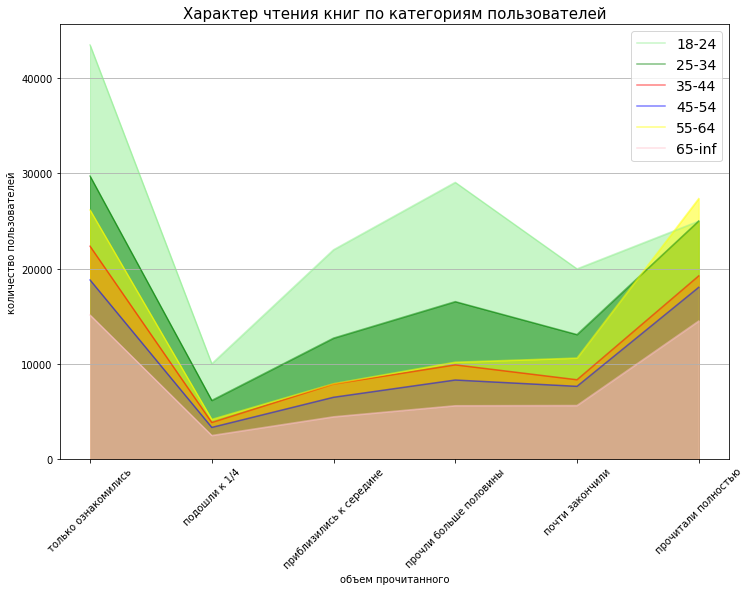

In [17]:
# построим график

period_22month_age_volume.plot(kind='area', stacked=False, figsize=(12, 8), color=['lightgreen','green','red','blue','yellow','pink'], rot=45)

plt.title('Характер чтения книг по категориям пользователей', fontsize=15)

plt.xlabel('объем прочитанного')
plt.ylabel('количество пользователей')
plt.legend(['18-24', '25-34', '35-44', '45-54', '55-64', '65-inf'], fontsize=14)
plt.grid(axis='y')

Данные в целом подтверждают идею о том, как можно читать книгу: пролистать первый десяток страниц и отложить или дочитать ее до конца (по крайней мере - продолжить чтение).

Среди читающих выделяются две группы: кто только ознакомился с книгой и те, кто прочитал её полностью (таких соответственно 30 и 25%). На 1/4 книги остановились немногие (6%): или уже раньше ее закрыли, или все-таки заинтересовались сюжетом.

Кто же уделяет чтению больше времени? Здесь можно рассматривать разные категории читателей: всех, кроме "ознакомившихся" с книгой, или только тех, кто приблизился к середине и продолжил чтение, или исключительно тех, кто "дошел до финала". При этом и о пользователях, которые относятся к категории "только ознакомились", можно сказать, что они уделяют чтению много времени - самую интересную книгу ведь надо выбрать среди множества других...

Так или иначе, самыми читающими оказались:
- пользователи суммарно до 35-ти лет: это молодые и активные люди, которым, в том числе, интересно и чтение книг;
- читатели в возрасте от 55 до 65 лет: это возраст выхода на пенсию, когда появляется больше свободного времени, используемого также и на чтение.

Посмотрим книги каких из 9-ти жанров дочитывают чаще других.

In [18]:
# определим по жанрам количество полностью прочитанных книг

col_1 = ['Боевая фантастика',
 'Боевое фэнтези',
 'Героическое фэнтези',
 'Зарубежные любовные романы',
 'Любовное фэнтези',
 'Попаданцы',
 'Современная русская литература',
 'Современные детективы',
 'Современные любовные романы']

max_readed_9genres = period_22month.loc[period_22month['volume_of_readed'] == 'прочитали полностью'][[x for x in col_1]]
max_readed_9genres.sum().sort_values(ascending=False)

Любовное фэнтези                  38810
Попаданцы                         25281
Героическое фэнтези               19881
Современные детективы             19577
Современные любовные романы       17983
Зарубежные любовные романы        15300
Боевая фантастика                 14438
Боевое фэнтези                    12873
Современная русская литература     9920
dtype: int64

В дополнение получим данные о количестве книг, загруженных в библиотеку (также по 9-ти жанрам).

In [19]:
# создадим словарь

books = {}

# определим по жанрам количество уникальных книг

for xx in col_1:
    count = period_22month.loc[period_22month[xx]==1]['item_id'].nunique()
    books[xx] = count

# отсортируем словарь по значениям (с помощью модуля operator)

books = sorted(books.items(), key = operator.itemgetter(1), reverse=True)
books

[('Современная русская литература', 3839),
 ('Современные детективы', 3166),
 ('Современные любовные романы', 3033),
 ('Боевая фантастика', 2625),
 ('Попаданцы', 2453),
 ('Зарубежные любовные романы', 2224),
 ('Любовное фэнтези', 2207),
 ('Боевое фэнтези', 1922),
 ('Героическое фэнтези', 1841)]

Как определили ранее, основная часть пользователей библиотеки - это читательницы (69%), которые в большинстве своем склонны к любовной тематике. Поэтому неудивительно, что жанр "любовное фэнтези" стал самым дочитываемым, хотя по количеству книг он только на 7-ом месте.

В то же время жанр "современная русская литература", из 9-ти рассмотренных, лидирует по наполнению библиотеки, однако, эти книги дочитывают до конца реже других. Другими словами, каждую книгу, написанную в жанре "любовное фэнтези", дочитывают до конца в среднем 17 раз, а книгу в жанре "современная русская литература" - только 2 раза.

### Рейтинговые оценки и можно ли им доверять

Пользователи библиотеки могут выставить книге любую оценку от 1 до 5. Судя по исходным данным, в которых отсутствует 81% значений, делают это неохотно.

На примере 9-ти жанров всё же посмотрим кто ставит оценки и на каком этапе прочтения делает это чаще (датафрейм - тот же, за период 22 месяца).

In [20]:
# выберем данные с оценками

rating = period_22month.loc[~(period_22month['rating'].isna())]
rating = rating.reset_index(drop=True)
rating

progress  user_id  item_id  rating  \
0             69    42797   315927     5.0   
1             42    18548   153547     5.0   
2             28    91177    52112     2.0   
3             39    32533   303571     4.0   
4             39     3857   241678     4.0   
...          ...      ...      ...     ...   
119762        99    71382   232241     5.0   
119763        31   106162    30252     3.0   
119764         9    69417   308234     5.0   
119765        98    51487   102694     5.0   
119766       100    80826     4111     5.0   

                                          title  \
0                        Рассвет кровавой удачи   
1                            Случайные партнеры   
2                   Старая тайна, новый негодяй   
3       Как отделаться от жениха и не влюбиться   
4                                     Книги 18+   
...                                         ...   
119762                   Одна помолвка на троих   
119763                      Да не судимы будете   
119764                                     Цель   
119765                                   Магиня   
119766                           Аукцион невест   

                          authors_all  year     age  age_group  sex_all  ...  \
0       Андрей Ворон (Mr. Incognito2)  2019   25_34        2.0      0.0  ...   
1                       Карла Кэссиди  2018   18_24        1.0      0.0  ...   
2                     Галина Романова  2009   35_44        3.0      0.0  ...   
3                  Екатерина Романова  2018   35_44        3.0      0.0  ...   
4                   Анжелика Любимова  2019   18_24        1.0      1.0  ...   
...                               ...   ...     ...        ...      ...  ...   
119762                Галина Куликова  2014   45_54        4.0      0.0  ...   
119763              Надежда Черкасова  2019   45_54        4.0      0.0  ...   
119764                    Эль Кеннеди  2016   25_34        2.0      1.0  ...   
119765              Александра Лисина  2017   18_24        1.0      1.0  ...   
119766                 Екатерина Флат  2019  65_inf        6.0      0.0  ...   

        Боевая фантастика  Боевое фэнтези  Героическое фэнтези  \
0                       1               0                    0   
1                       0               0                    0   
2                       0               0                    0   
3                       0               0                    0   
4                       0               0                    0   
...                   ...             ...                  ...   
119762                  0               0                    0   
119763                  0               0                    0   
119764                  0               0                    0   
119765                  0               0                    1   
119766                  0               0                    0   

        Зарубежные любовные романы  Любовное фэнтези  Попаданцы  \
0                                0                 0          0   
1                                1                 0          0   
2                                0                 0          0   
3                                0                 1          0   
4                                0                 0          0   
...                            ...               ...        ...   
119762                           0                 0          0   
119763                           0                 0          0   
119764                           1                 0          0   
119765                           0                 1          0   
119766                           0                 1          1   

        Современная русская литература  Современные детективы  \
0                                    0                      0   
1                                    0                      0   
2                                    0                      1   
3                      

Для информации: книг с оценками и здесь оказалось не много - 23% от исходного датафрейма.

In [21]:
# сохраним данные

rating.to_csv('rating.csv', index=False)

In [22]:
# определим каких и сколько выставлено оценок
rating_total = rating.groupby('rating').count().rename(columns={'age': 'quantity'})[['quantity']]

# добавим удельный вес
s_r = rating_total['quantity'].sum()
rating_total['percent'] = rating_total['quantity'] / s_r

# приведем к процентному формату
rating_total['percent'] = rating_total['percent'].map(lambda pp: '{:,.1%}'.format(pp))

rating_total

quantity percent
rating                  
1.0         2409    2.0%
2.0         2575    2.2%
3.0         7970    6.7%
4.0        17559   14.7%
5.0        89254   74.5%

Общая картина по оценкам понятна: у максимального рейтинга убедительный перевес.

Посмотрим как распределились оценки по прочитанному объему.

In [23]:
# определим количество оценок по прогрессу чтения
rating_progress = rating.groupby(['rating', 'volume_of_readed']).count().unstack('rating').rename(columns={'year': 'quantity'})[['quantity']]

# изменим индексы (в переменную записан нужный порядок)
rating_progress = rating_progress.reindex(new_index)

rating_progress

quantity                          
rating                       1.0   2.0   3.0    4.0    5.0
volume_of_readed                                          
только ознакомились          179   203   611   1425   8017
подошли к 1/4                 86    94   274    577   3285
приблизились к середине      233   221   658   1440   7532
прочли больше половины       306   303   929   1946  10232
почти закончили              260   272   833   1858  11363
прочитали полностью         1345  1482  4665  10313  48825

Как оказалось, пользователи выставляют оценки на всех этапах чтения. Но одно дело, когда прочитаны первые 30-50 страниц и понятно, что книга не заслуживает внимания - оценка "2". Другое дело, когда в подобном случае ставят высокий рейтинг. Возникает вопрос: если книга так хороша, почему не дочитывают до конца? А может за высокую оценку пользователи получают какие-то бонусы? Рассчитывать на объективность в последнем случае не приходится, поэтому если рассматривать тему глубже, лучше брать категории "почти закончили" чтение и "прочитали полностью".

Выставленный рейтинг "1" и "2" очень близок по смыслу. Первый можно трактовать, как *"совсем не понравилось, очень плохо"*, второй - как *"не понравилось, плохо"*. Как пользователи определяют что поставить - единицу или двойку - не известно, однако, полученное распределение данных по этими оценками практически одинаковое.

Из двух оценок - "3" и "4" - пользователи в два раза чаще ставили вторую не зависимо от того, в какой объеме прочитана книга.

Что касается максимального рейтинга, то его читатели больше всего выставили полностью прочитанным книгам - 55% от всех "пятерок".

Определим кому из пользователей интересно оценивать книги - книги, которые почти или полностью прочитаны.

In [24]:
# выберем прочитанный объем
volume = ['почти закончили', 'прочитали полностью']

# сгруппируем данные
rating_2volume = rating.loc[rating['volume_of_readed'].isin(volume)]\
                .groupby(['rating','age']).count()\
                .rename(columns={'user_id': 'amount'})[['amount']]

# представим в "компактном" виде
rating_2volume.unstack('rating')

amount                        
rating    1.0  2.0   3.0   4.0    5.0
age                                  
18_24     256  267   773  1624  12623
25_34     327  303   983  1943  12230
35_44     170  213   741  1896   9036
45_54     198  241   815  1764   8756
55_64     464  541  1418  3087  11053
65_inf    190  189   768  1857   6490

Учитывая сопоставимость данных, построим два графика: первый для оценок "1", "2" и "3", второй - для "4" и "5".

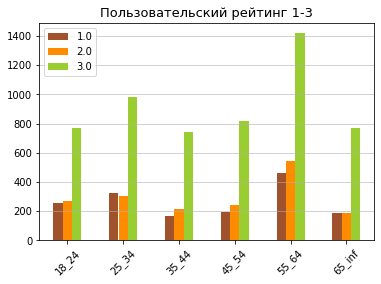

In [25]:
# график для рейтинга с 1-го по 3-ий

rating_2volume\
    .loc[pd.IndexSlice["1.0":"3.0", :], :]\
    .unstack('rating')\
    .plot(kind='bar', color=['sienna','darkorange','yellowgreen'], rot=45)

plt.title('Пользовательский рейтинг 1-3', fontsize=13)
plt.legend(['1.0','2.0','3.0'], loc='upper left')
plt.xlabel('')
plt.grid(axis='y', alpha=0.7)

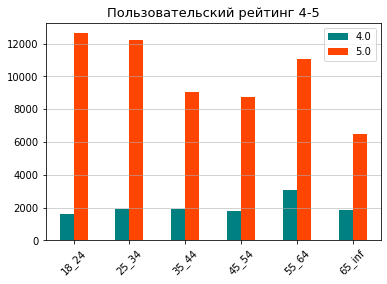

In [26]:
# график для рейтинга "4" и "5"

rating_2volume\
    .loc[pd.IndexSlice["4.0":"5.0", :], :]\
    .unstack('rating')\
    .plot(kind='bar', color=['teal','orangered'], rot=45)

plt.title('Пользовательский рейтинг 4-5', fontsize=13)
plt.legend(['4.0','5.0'])
plt.xlabel('')
plt.grid(axis='y', alpha=0.7)

В исследуемых данных пользователи, которые чаще дочитывают книги, чаще и выставляют книгам рейтинг - речь о пользователях до 35-ти и о возрасте 55-64. Последние, что интересно, более критично относятся к прочитанному: количество низких и средних оценок у них значительно больше, чем у других. А вот читатели до 35-ти лидируют в выставлении максимального рейтинга. Остальные возрастные группы примерно одинаково оценивают прочитанные книги.

Книги жанра "Любовное фэнтези" дочитывают чаще других. А часто ли прочитанным книгам выставляют оценки?

In [27]:
# определим суммарное количество оценок по каждому жанру
# (переменная volume -> почти или полностью прочитанные книги,
# переменная col_1 -> 9 жанров)

rating_2volume_9genres = rating.loc[rating['volume_of_readed'].isin(volume)][[x for x in col_1]]
rating_2volume_9genres.sum().sort_values(ascending=False)

Любовное фэнтези                  23513
Попаданцы                         15852
Героическое фэнтези               12416
Современные детективы             12374
Современные любовные романы       10889
Боевая фантастика                  9742
Зарубежные любовные романы         9054
Боевое фэнтези                     8099
Современная русская литература     6968
dtype: int64

Жанр "Любовное фэнтези" лидирует и по количеству выставленных оценок, что еще раз подтверждает его популярность. А какой прочитанной книге этого жанра пользователи поставили максимальное количество оценок? Окажется ли её автором Елена Звёздная, самый популярный из 629-ти писателей, чьи книги загружены в библиотеку МТС?

In [28]:
# создадим датафрейм из книг жанра "Любовное фэнтези"
# (книги, которые почти или полностью прочитаны)

rating_love_fantasy = rating.loc[(rating['Любовное фэнтези'] == 1) & (rating['volume_of_readed'].isin(volume))]

In [29]:
# определим сколько раз оценили каждую книгу

rating_love_fantasy[['item_id','authors_all','title']].value_counts()

item_id  authors_all                     title                                                
78934    Лена Летняя                     Невеста Смерти                                           170
216356   Валентина Савенко               Вдова мастера теней                                      166
198447   Валентина Савенко               Мечта светлой тьмы                                       150
196238   Милена Завойчинская             Струны волшебства. Книга вторая. Цветная музыка сидхе    120
265425   Екатерина Елизарова             Ключ от твоего мира                                      118
                                                                                                 ... 
265684   Ольга Коробкова                 Секретарь для некроманта                                   1
48462    Ольга Подпалова,Таисс Эринкайт  По следу Зверя. Игры больших кошек                         1
112986   Анастасия Сагран                Осенний дом                                     

In [30]:
# то же, но с максимальным рейтингом

rating_love_fantasy.loc[rating_love_fantasy['rating'] == 5.0][['item_id','authors_all','title']].value_counts()

item_id  authors_all          title                                                
78934    Лена Летняя          Невеста Смерти                                           140
216356   Валентина Савенко    Вдова мастера теней                                      114
196238   Милена Завойчинская  Струны волшебства. Книга вторая. Цветная музыка сидхе    102
106369   Наталья Жильцова     Обрученные кровью. Отбор                                 101
274542   Елена Звёздная       Шепот в темноте                                          101
                                                                                      ... 
84261    Ксения Томашева      Серебряная Маска                                           1
232350   Ксения Болотина      Танец с мечами                                             1
232039   Лина Алфеева         Элементарная магия                                         1
231893   Надежда Волгина      Золушка XY                                                 1
130   

Максимальное количество оценок получил роман Лены Летней "Невеста Смерти" с наивысшим баллом в 82% случаев. Данный автор не вошел в топ-5 самых читаемых в жанре "Любовное фэнтези", в отличие от Елены Звёздной, при этом последняя не заняла верхних строк по количеству выставленных оценок. Посмотрим как пользователи оценили самый читаемый роман Елены Звёздной "Долина драконов. Магическая практика".

In [31]:
# выберем необходимые данные
rating_zvezdnaya = rating.loc[(rating['authors_all'] == "Елена Звёздная") & (rating['title'] == "Долина драконов. Магическая Практика")]

# определим сколько раз оценили книгу (иначе - сколько строк в датафрейме)
rating_zvezdnaya.shape[0]

123

In [32]:
# сгруппируем данные по рейтингу и объему прочитанного
r_z = rating_zvezdnaya.groupby(['rating','volume_of_readed']).count().unstack('rating').rename(columns={'age': 'rating_quantity'})[['rating_quantity']]

# приведем индексы в нужный порядок
r_z = r_z.reindex(new_index)

# заполним пропущенные значения
r_z.fillna("-")

rating_quantity           
rating                              2.0  4.0   5.0
volume_of_readed                                  
только ознакомились                   -  1.0  11.0
подошли к 1/4                         -    -   3.0
приблизились к середине               -    -     -
прочли больше половины                -    -   4.0
почти закончили                     1.0    -   5.0
прочитали полностью                   -  7.0  91.0

Несмотря на высокий интерес к роману про драконов, желание выставить рейтинг возникло только у каждого четвертого читателя кто хотя бы открывал книгу - 123 оценки из 463-х возможных (именно столько раз произведение открывали/читали за два года). Больше всего оценок - 80% - поставлено после завершения чтения, 10% - в самом начале знакомства с книгой.

Тема рейтинга - весьма неоднозначная: и не все пользователи хотят делиться своим мнением о книге, и сами оценки вызывают много вопросов. Понятно, что у каждого читателя свои критерии "нравится / не нравится", свой читательский опыт в том или ином жанре. Но любая оценка должна быть объективной, чтобы можно было ей доверять, а это не всегда получается.

Какие оценки принимать во внимание, а какие отбрасывать, - каждый решает сам. Брать в расчет только те книги, которые почти или полностью прочитаны, - лишь один из вариантов.

### Сезонность и читательская активность: взаимосвязь и тенденции

Для выявления закономерностей рассмотрим дату начала чтения в датафрейме с популярными 9-ю жанрами. Данные возьмем за полные два года: "условности", касающиеся дочитывания книги до конца, здесь не важны.

Сначала определим сколько книг из библиотеки МТС читают ежемесячно / ежедневно.

In [33]:
# выберем данные за 2018 год и определим сколько книг прочитано в каждом месяце

best_9genres_2018 = df_data_all_best_9genres\
                    .loc[df_data_all_best_9genres['start_year'] == 2018]\
                    .groupby('start_month').count()\
                    .rename(columns={'age': 'reads_on_month'})[['reads_on_month']]
best_9genres_2018

reads_on_month
start_month                
1                     19448
2                     19157
3                     20961
4                     20276
5                     21132
6                     21410
7                     24118
8                     23640
9                     23636
10                    24175
11                    24501
12                    25047

In [34]:
# создадим списки с номерами месяцев по количеству дней - 30 и 31
# (для февраля отдельно возьмем 28 дней)
days_30 = [4, 6, 9, 11]
days_31 = [1, 3, 5, 7, 8, 10, 12]

# рассчитаем в новом столбце количество прочитанных книг за день

best_9genres_2018.loc[best_9genres_2018.index.isin(days_30), 'reads_on_day'] = best_9genres_2018['reads_on_month'] / 30
best_9genres_2018.loc[best_9genres_2018.index.isin(days_31), 'reads_on_day'] = best_9genres_2018['reads_on_month'] / 31
best_9genres_2018.loc[best_9genres_2018.index == 2, 'reads_on_day'] = best_9genres_2018['reads_on_month'] / 28

# округлим рассчитанные значения
best_9genres_2018['reads_on_day'] = best_9genres_2018['reads_on_day'].round(0).astype(int)

best_9genres_2018

reads_on_month  reads_on_day
start_month                              
1                     19448           627
2                     19157           684
3                     20961           676
4                     20276           676
5                     21132           682
6                     21410           714
7                     24118           778
8                     23640           763
9                     23636           788
10                    24175           780
11                    24501           817
12                    25047           808

In [35]:
# запишем последние преобразования в функцию

def reads_on_period (df, year):
    rr = df.loc[df.start_year == year].groupby('start_month').count().rename(columns={'age': 'reads_on_month'})[['reads_on_month']]
    
    rr.loc[rr.index.isin(days_30), 'reads_on_day'] = rr.reads_on_month / 30
    rr.loc[rr.index.isin(days_31), 'reads_on_day'] = rr.reads_on_month / 31
    rr.loc[rr.index == 2, 'reads_on_day'] = rr.reads_on_month / 28

    rr.reads_on_day = rr.reads_on_day.round(0).astype(int)

    return rr

In [36]:
# проверим её работу на данных за 2018 год

reads_on_period(df_data_all_best_9genres, 2018)

reads_on_month  reads_on_day
start_month                              
1                     19448           627
2                     19157           684
3                     20961           676
4                     20276           676
5                     21132           682
6                     21410           714
7                     24118           778
8                     23640           763
9                     23636           788
10                    24175           780
11                    24501           817
12                    25047           808

In [37]:
# получим аналогичные данные за 2019 год

best_9genres_2019 = reads_on_period(df_data_all_best_9genres, 2019)
best_9genres_2019

reads_on_month  reads_on_day
start_month                              
1                     25277           815
2                     23315           833
3                     25943           837
4                     25572           852
5                     27011           871
6                     24058           802
7                     25577           825
8                     25952           837
9                     25728           858
10                    25018           807
11                    23413           780
12                    23682           764

In [38]:
# объединим полученные массивы

days_2018_2019 = best_9genres_2018.merge(best_9genres_2019, how='left', on='start_month')
days_2018_2019

reads_on_month_x  reads_on_day_x  reads_on_month_y  \
start_month                                                       
1                       19448             627             25277   
2                       19157             684             23315   
3                       20961             676             25943   
4                       20276             676             25572   
5                       21132             682             27011   
6                       21410             714             24058   
7                       24118             778             25577   
8                       23640             763             25952   
9                       23636             788             25728   
10                      24175             780             25018   
11                      24501             817             23413   
12                      25047             808             23682   

             reads_on_day_y  
start_month                  
1                       815  
2                       833  
3                       837  
4                       852  
5                       871  
6                       802  
7                       825  
8                       837  
9                       858  
10                      807  
11                      780  
12                      764

In [39]:
# переименуем столбцы

days_2018_2019.columns = ['reads_on_month_2018', 'reads_on_day_2018', 'reads_on_month_2019', 'reads_on_day_2019']
days_2018_2019

reads_on_month_2018  reads_on_day_2018  reads_on_month_2019  \
start_month                                                                
1                          19448                627                25277   
2                          19157                684                23315   
3                          20961                676                25943   
4                          20276                676                25572   
5                          21132                682                27011   
6                          21410                714                24058   
7                          24118                778                25577   
8                          23640                763                25952   
9                          23636                788                25728   
10                         24175                780                25018   
11                         24501                817                23413   
12                         25047                808                23682   

             reads_on_day_2019  
start_month                     
1                          815  
2                          833  
3                          837  
4                          852  
5                          871  
6                          802  
7                          825  
8                          837  
9                          858  
10                         807  
11                         780  
12                         764

In [40]:
# рассчитаем средние значения по прочитанным книгам

print("За 2018 год:")
print("- среднее количество читаемых книг в месяц - ", days_2018_2019.reads_on_month_2018.mean().round().astype(int),";", sep='')
print("- в день - ", days_2018_2019.reads_on_day_2018.mean().round().astype(int),".", sep='')
print()
print("За 2019 год:")
print("- среднее количество читаемых книг в месяц - ", days_2018_2019.reads_on_month_2019.mean().round().astype(int),";", sep='')
print("- в день - ", days_2018_2019.reads_on_day_2019.mean().round().astype(int),".", sep='')

За 2018 год:
- среднее количество читаемых книг в месяц - 22292;
- в день - 733.

За 2019 год:
- среднее количество читаемых книг в месяц - 25046;
- в день - 823.


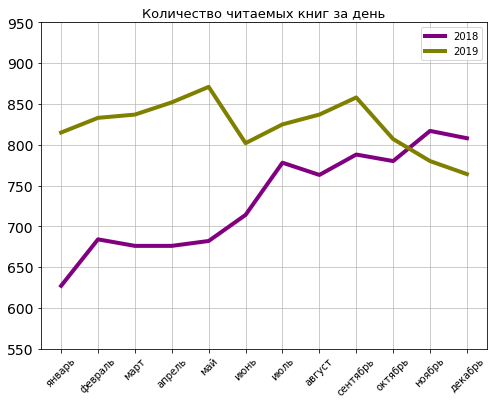

In [41]:
# построим график количества читаемых книг за день

plt.figure(figsize=(8,6))

days_2018_2019['reads_on_day_2018'].plot(linewidth=4, color='purple', rot=45)
days_2018_2019['reads_on_day_2019'].plot(linewidth=4, color='olive', rot=45)

plt.legend(['2018','2019'])

months_list = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']
plt.xticks(range(1,13), months_list)
plt.xlabel('')

plt.ylim(550, 950)
plt.yticks(fontsize=14)

plt.title('Количество читаемых книг за день', fontsize=13)
plt.grid(alpha=0.8)

В 2019 году пользователи проявили б'ольший интерес к книгам: среднее количество читаемых книг за день оказалось на 12% больше, чем в предыдущем периоде. И это при том, что рост читательской активности наблюдался только до мая и в 3-м квартале, а в 2018 - в течение всего года.

Для полноты картины получим аналогичную информацию по самим читателям.

In [42]:
# определим по месяцам количество читателей в 2018 году

best_9genres_2018_user = df_data_all_best_9genres\
                    .loc[df_data_all_best_9genres['start_year'] == 2018]\
                    .groupby('start_month')['user_id'].nunique()

best_9genres_2018_user = best_9genres_2018_user.reset_index()
best_9genres_2018_user.columns = ['start_month', 'users_on_month']

best_9genres_2018_user

start_month  users_on_month
0             1           14568
1             2           14283
2             3           14559
3             4           13926
4             5           13840
5             6           13223
6             7           12639
7             8           12568
8             9           11694
9            10           12382
10           11           12606
11           12           13705

In [43]:
# напишем функцию расчета количества читателей за месяц и день (аналогично книгам)

def users_on_period (df, year):
    uu = df.loc[df.start_year == year].groupby('start_month')['user_id'].nunique()

    uu = uu.reset_index()
    uu.columns = ['start_month', 'users_on_month']

    uu.loc[uu.start_month.isin(days_30), 'users_on_day'] = uu.users_on_month / 30
    uu.loc[uu.start_month.isin(days_31), 'users_on_day'] = uu.users_on_month / 31
    uu.loc[uu.start_month == 2, 'users_on_day'] = uu.users_on_month / 28

    uu.users_on_day = uu.users_on_day.round(0).astype(int)

    return uu

In [44]:
# применим функцию и получим данные за 2018 год ("перезапишем" ранее созданный датафрейм)

best_9genres_2018_user = users_on_period(df_data_all_best_9genres, 2018)
best_9genres_2018_user

start_month  users_on_month  users_on_day
0             1           14568           470
1             2           14283           510
2             3           14559           470
3             4           13926           464
4             5           13840           446
5             6           13223           441
6             7           12639           408
7             8           12568           405
8             9           11694           390
9            10           12382           399
10           11           12606           420
11           12           13705           442

In [45]:
# получим аналогичные данные по читателям за 2019 год

best_9genres_2019_user = users_on_period(df_data_all_best_9genres, 2019)
best_9genres_2019_user

start_month  users_on_month  users_on_day
0             1           11938           385
1             2           11610           415
2             3           12923           417
3             4           13050           435
4             5           13489           435
5             6           12995           433
6             7           12535           404
7             8           11650           376
8             9           11714           390
9            10           13172           425
10           11           12096           403
11           12           11103           358

In [46]:
# объединим полученные массивы
users_2018_2019 = best_9genres_2018_user.merge(best_9genres_2019_user, how='left', on='start_month')

# переименуем столбцы
users_2018_2019.columns = ['start_month', 'users_on_month_2018', 'users_on_day_2018', 'users_on_month_2019', 'users_on_day_2019']

users_2018_2019

start_month  users_on_month_2018  users_on_day_2018  users_on_month_2019  \
0             1                14568                470                11938   
1             2                14283                510                11610   
2             3                14559                470                12923   
3             4                13926                464                13050   
4             5                13840                446                13489   
5             6                13223                441                12995   
6             7                12639                408                12535   
7             8                12568                405                11650   
8             9                11694                390                11714   
9            10                12382                399                13172   
10           11                12606                420                12096   
11           12                13705                442                11103   

    users_on_day_2019  
0                 385  
1                 415  
2                 417  
3                 435  
4                 435  
5                 433  
6                 404  
7                 376  
8                 390  
9                 425  
10                403  
11                358

In [47]:
# рассчитаем средние значения по читателям библиотеки

print("За 2018 год:")
print("- среднее количество читателей в месяц - ", users_2018_2019.users_on_month_2018.mean().round().astype(int),";", sep='')
print("- в день - ", users_2018_2019.users_on_day_2018.mean().round().astype(int),".", sep='')
print()
print("За 2019 год:")
print("- среднее количество читателей в месяц - ", users_2018_2019.users_on_month_2019.mean().round().astype(int),";", sep='')
print("- в день - ", users_2018_2019.users_on_day_2019.mean().round().astype(int),".", sep='')

За 2018 год:
- среднее количество читателей в месяц - 13333;
- в день - 439.

За 2019 год:
- среднее количество читателей в месяц - 12356;
- в день - 406.


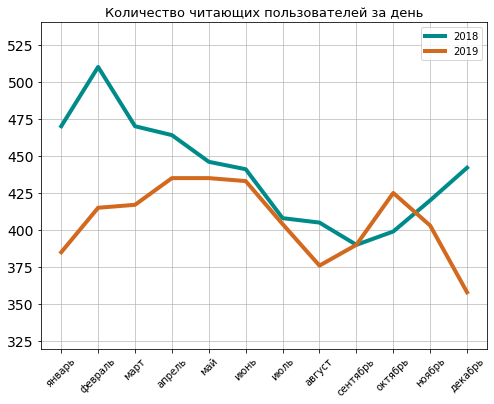

In [48]:
# построим график количества читающих пользователей за день

plt.figure(figsize=(8,6))

users_2018_2019['users_on_day_2018'].plot(linewidth=4, color='darkcyan', rot=45)
users_2018_2019['users_on_day_2019'].plot(linewidth=4, color='chocolate', rot=45)

plt.legend(['2018','2019'])

plt.xticks(range(0,12), months_list)
plt.xlabel('')

plt.ylim(320, 540)
plt.yticks(fontsize=14)

plt.title('Количество читающих пользователей за день', fontsize=13)
plt.grid(alpha=0.8)

Наблюдается парадокс: количество читающих в день пользователей в 2019 году уменьшилось на 7% в сравнении с 2018, а среднее количество читаемых книг наоборот - увеличилось на 12%. Эта тенденция хорошо заметна в летний период, когда число желающих читать снижается, а те, кто остается верен книгам, скачивают их всё больше. Кстати, в другие месяцы какие-либо четкие закономерности не прослеживаются. (Напомню, что речь идет о читателях 9-ти популярных жанров. Вся же библиотека - 633 "выделенных" жанра - за год по числу пользователей уменьшилась всего на 1%.)

Примечательно, и это явное совпадение, что каждый год к февралю происходит увеличение читательской аудитории на 8%. Количество читаемых книг в этот период также увеличивается - на 9% в 2018 и 2% в 2019. Рост числа пользователей заметен и в октябре, но разный: в 2018 - +2% к сентябрю, в 2019 - +9%, одновременно наблюдается спад по количеству читаемых книг.

Что конкретно является причиной таких изменений - или пополнение библиотеки новыми произведениями, или проведение маркетинговых акций для пользователей МТС library, или что-то другое - это темы отдельных исследований (при наличиии необходимых данных).

А сейчас рассмотрим влияние времени года на выбираемый к прочтению жанр книги. Эту взаимосвязь, или ее отсутствие, также рассмотрим на примере уже известных 9-ти жанров.

In [59]:
# напишем функцию

def months_genres (df, year, g_1, g_2, g_3, g_4, g_5, g_6, g_7, g_8, g_9):
        
    """ Создает датафрейм из прочитанных книг по 9-ти жанрам за выбранный год в разрезе месяцев """
    
    # создадим датафрейм с данными по первому жанру
    m_g = df.loc[(df['start_year'] == year) & (df[g_1] == 1)].groupby('start_month').count()[[g_1]]

    # создадим список из остальных 8-ми жанров
    col_2 = [g_2, g_3, g_4, g_5, g_6, g_7, g_8, g_9]

    # добавим по очереди в созданный датафрейм данные по другим жанрам
    for gg in col_2:
        m_g[gg] = df.loc[(df['start_year'] == year) & (df[gg] == 1)].groupby('start_month').count()[[gg]]
    
    return m_g

In [60]:
# получим данные за 2018 год

months_genres_2018 = months_genres(df_data_all_best_9genres,
 2018,
 'Боевая фантастика',
 'Боевое фэнтези',
 'Героическое фэнтези',
 'Зарубежные любовные романы',
 'Любовное фэнтези',
 'Попаданцы',
 'Современная русская литература',
 'Современные детективы',
 'Современные любовные романы')

months_genres_2018

Боевая фантастика  Боевое фэнтези  Героическое фэнтези  \
start_month                                                           
1                         2267            1916                 2102   
2                         2183            2049                 2184   
3                         2537            2244                 2504   
4                         2636            2131                 2561   
5                         2679            2278                 2731   
6                         2745            2222                 2795   
7                         2784            2801                 3674   
8                         2910            2586                 3463   
9                         2808            2603                 3485   
10                        3021            2555                 3370   
11                        3023            2369                 3077   
12                        3355            2632                 3172   

             Зарубежные любовные романы  Любовное фэнтези  Попаданцы  \
start_month                                                            
1                                  2488              2774       2444   
2                                  2542              2662       2292   
3                                  2373              3466       2888   
4                                  2254              3554       2799   
5                                  2477              3400       2990   
6                                  2400              3678       3088   
7                                  2916              4537       3554   
8                                  3367              4118       3827   
9                                  2876              4309       3587   
10                                 2762              4380       3848   
11                                 2792              4953       4072   
12                                 2939              4584       3963   

             Современная русская литература  Современные детективы  \
start_month                                                          
1                                      3816                   3259   
2                                      3838                   3229   
3                                      3990                   3271   
4                                      3507                   3261   
5                                      3534                   3276   
6                                      3397                   3441   
7                                      3730                   3754   
8                                      3395                   3616   
9                                      3531                   4517   
10                                     3956                   4146   
11                                     3843                   4034   
12                                     3864                   4056   

             Современные любовные романы  
start_month                               
1                                   2703  
2                                   2493  
3                                   2765  
4                                   2707  
5                                   3006  
6                                   3211  
7                                   3448  
8                                   3388  
9                                   2679  
10                                  2939  
11                                  3319  
12                                  3644

In [61]:
# и аналогично за 2019 год

months_genres_2019 = months_genres(df_data_all_best_9genres,
 2019,
 'Боевая фантастика',
 'Боевое фэнтези',
 'Героическое фэнтези',
 'Зарубежные любовные романы',
 'Любовное фэнтези',
 'Попаданцы',
 'Современная русская литература',
 'Современные детективы',
 'Современные любовные романы')

months_genres_2019

Боевая фантастика  Боевое фэнтези  Героическое фэнтези  \
start_month                                                           
1                         3243            2502                 3042   
2                         2829            2184                 2816   
3                         3298            2472                 3153   
4                         2896            2352                 2986   
5                         2731            2472                 3076   
6                         2825            2173                 2710   
7                         2959            2653                 3426   
8                         3076            2670                 3528   
9                         3023            2994                 3853   
10                        3443            2623                 3051   
11                        3109            2281                 2712   
12                        3113            2552                 2970   

             Зарубежные любовные романы  Любовное фэнтези  Попаданцы  \
start_month                                                            
1                                  3198              4922       3947   
2                                  2988              4700       3582   
3                                  3345              5718       4193   
4                                  3150              5379       3763   
5                                  3484              5422       3661   
6                                  2891              5033       3629   
7                                  3018              5439       4001   
8                                  3125              5566       4312   
9                                  2636              5517       4306   
10                                 2253              5192       4467   
11                                 2034              4710       3804   
12                                 1924              5186       4017   

             Современная русская литература  Современные детективы  \
start_month                                                          
1                                      3932                   3814   
2                                      3638                   3465   
3                                      3819                   3790   
4                                      4158                   4036   
5                                      4745                   3955   
6                                      3631                   3551   
7                                      3476                   3697   
8                                      3266                   3736   
9                                      3527                   3631   
10                                     3534                   3491   
11                                     3564                   3072   
12                                     2880                   3121   

             Современные любовные романы  
start_month                               
1                                   3892  
2                                   3615  
3                                   4056  
4                                   4060  
5                                   4639  
6                                   4213  
7                                   4343  
8                                   4768  
9                                   4451  
10                                  4413  
11                                  4497  
12                                  4552

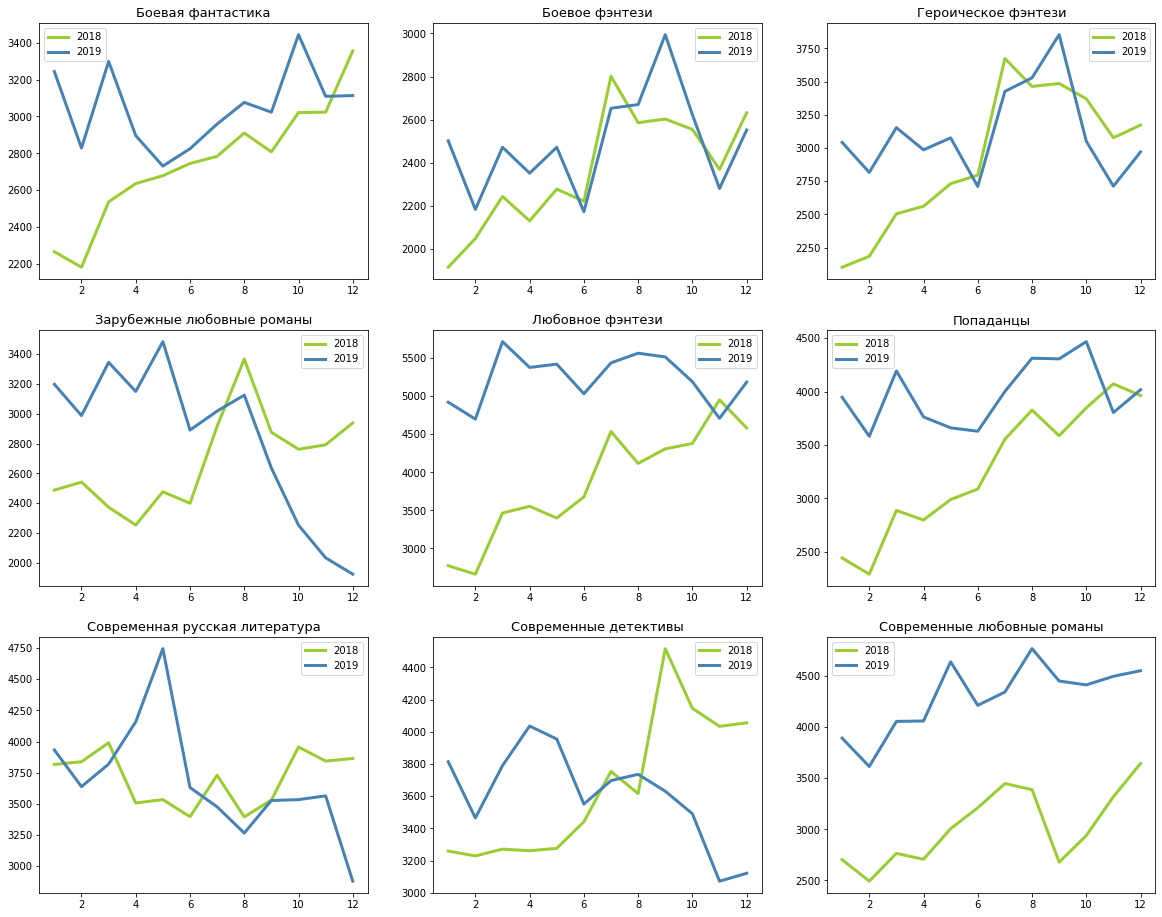

In [62]:
# построим графики по каждому жанру за два года

plt.figure(figsize=(20,16))

nn = 1

# (в переменной col_1 список из 9-ти жанров)
for gg in col_1:
    plt.subplot(3,3,nn)
    months_genres_2018[gg].plot(linewidth=3, color='yellowgreen')
    months_genres_2019[gg].plot(linewidth=3, color='steelblue')

    plt.title(gg, fontsize=13)
    plt.legend(['2018','2019'])
    plt.xlabel('')

    nn += 1

Построенные графики приводят к выводу, что выбор жанра книги от времени года совсем не зависит. Читателям интересны конкретные авторы с их мастерством придумывать захватывающие сюжеты.

Вместе с тем на графиках можно выделить жанры, пользующиеся неизменным спросом у читателей на протяжении всего рассматриваемого периода: "Современные любовные романы", "Попаданцы", "Любовное фэнтези".

Можно увидеть и подтверждение тому факту, что книги редко относятся строго к одному жанру - схожие по развитию сюжета жанры имеют похожие "кривые": "Любовное фэнтези" и "Попаданцы", "Боевое фэнтези" и "Героическое фэнтези".

Можно заметить и смену читательских предпочтений. Так, например, в сентябре 2018 года пользователи библиотеки "переключились" с жанра "Современные любовные романы" на "Современные детективы": у первого произошел резкий спад, у второго - еще б'ольший рост (для анализа причин необходимы дополнительные данные о датах загрузки книг в приложение, о сделанных по новинкам анонсах и т.п.).

Заключение.

В данной аналитической работе проведено исследование литературных предпочтений пользователей библиотеки МТС library. Несмотря на то, что из всех жанров детально рассмотрены только девять самых популярных, использованный подход в анализе данных можно применить и к другим жанрам.

Сделанные в работе выводы относительно читательской активности, востребованности писателей и других параметров можно использовать для:

- развития продукта (приложения): пополнение библиотеки в первую очередь книгами наиболее читаемых авторов, пересмотр невостребованных изданий и т.д.;
- построения рекомендательной системы продаж: использование жанровых предпочтений для разных категорий пользователей (по возрастным сегментам) для адресного составления книжных подборок, в т.ч. при анонсах книжных новинок.

Книжные издательства и книжные магазины также могут принять во внимание полученные результаты работы:

- какие авторы и книги хорошо читаются, соответственно, что может лучше продаваться (что будет прибыльнее, в первую очередь, для издательства), каким образом формировать ассортимент книжных полок;
- каких писателей приглашать на встречи с читателями (для повышения популярности книжного магазина и расширения читательской аудитории) и т.п..

За время работы над дипломом МТС library преобразовалось в другой сервис для читающих людей - приложение "Строки". Но несмотря на это, читатели с их предпочтениями остались прежними. Совершенно очевидно, что с формированием новых литературных трендов, созданием новых жанров, появлением новых авторов могут измениться и интересы пользователей, но тогда это уже будут другие данные и другие выводы.